# Capstone project 

#### Objectives/ Problem Statement
To predict the price of new HDB launch before the launch <br>
_**Input a set of features and output a price **_

#### why this problem?
A practical problem that most Singaporeans (including myself) face 

## Part3_ Modelling_Round1a

**[Iteration 1: ](#iter1)** [SLR](#1slr)  ||  [MLR by category](#1mlrcat) || [MLR all](#1mlrall) || [ridge,lasso,enet](#1regularization)<br> 
X = resale data <br>
y = resale['resale_price'] <br>

**[Iteration 2: ](#iter2)** [SLR](#2slr)  ||  [MLR by category](#2mlrcat) || [MLR all](#2mlrall) || [ridge,lasso,enet](#2regularization)<br>
X = resale data <br>
y = resale['adj_price'] <br>


**[Iteration 3](#iter3)** <br>
X = resale data without time data<br>
y = resale['adj_price'] <br>
**[Iter3 - no yr:       ](#iter3a)**[MLR all](#3amlrall) || [ridge,lasso,enet](#3aregularization) <br>
**[Iter3 - no yr&month: ](#iter3b)**:[MLR all](#3bmlrall) || [ridge,lasso,enet](#3bregularization)


**[Iteration 4: ](#iter4)** [SLR](#4slr)  ||  [MLR by category](#4mlrcat) || [MLR all](#4mlrall) || [ridge,lasso,enet](#4regularization)<br> 
*Train_test_split by time* <br>
X = resale data without time data<br>
y = resale['adj_price'] and y = resale['resale_price'] <br>
**[Iter4a - no yr:       ](#iter4a)**[MLR all](#4amlrall) || [ridge,lasso,enet](#4aregularization) <br>
**[Iter3 - no yr&month: ](#iter4b)**:[MLR all](#4bmlrall) || [ridge,lasso,enet](#4bregularization)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Quick Cleaning 
(code and analysis taken from Part2_EDA)

In [3]:
resale = pd.read_csv('./datasets/resale_all.csv')
resale.drop([u'Unnamed: 0',u'geo_data',u'full_address','new full_address'],axis = 1,inplace=True)

#time
resale['date'] = pd.to_datetime(resale['month'])
resale['year'] = resale['date'].apply(lambda x:x.year)
resale['month'] = resale['date'].apply(lambda x:x.month)

#lease
resale['lease_commence_date'] = resale['lease_commence_date'].astype(int)
resale['calculated_remaining_lease'] = 99 - (resale['year'] - resale['lease_commence_date'])
resale['calculated_remaining_lease'] = [99 if yr >99 else yr for yr in resale['calculated_remaining_lease']]

#block 
resale['block_num'] = [re.findall('\d+',str(block_num))[0] for block_num in resale['block']]
resale['block_num'] = resale['block_num'].astype('int')

# flat model 
resale['flat_model'] = [model.upper() for model in resale['flat_model']]
resale['flat_model_PREMIUM'] = [1 if 'PREMIUM' in model else 0 for model in resale['flat_model']]
resale['flat_model_IMPROVED'] = [1 if 'IMPROVED' in model else 0 for model in resale['flat_model']]
resale['flat_model_MODEL_A'] = [1 if 'MODEL A' in model else 0 for model in resale['flat_model']]
resale.replace({'flat_model':{'MODEL A2':'OTHERS',
                              'PREMIUM APARTMENT':'APARTMENT',
                              'PREMIUM APARTMENT.':'APARTMENT',
                              'PREMIUM APARTMENT LOFT':'APARTMENT',
                              'MULTI GENERATION':'OTHERS',
                              '2-ROOM':'OTHERS',
                              'IMPROVED-MAISONETTE':'MAISONETTE',
                              'PREMIUM MAISONETTE':'MAISONETTE',
                              'IMPROVED-MAISONETTE':'MAISONETTE',
                              'MODEL A-MAISONETTE':'MAISONETTE',
                              'MODEL A':'OTHERS',
                              'IMPROVED':'OTHERS',
                              'TYPE S1': 'TYPE S',
                              'TYPE S2': 'TYPE S'
                              }},inplace=True)

#flat type
resale.replace({'flat_type':{'MULTI-GENERATION':'MULTI GENERATION'}},inplace=True)

#storey
resale['storey'] = [7 if floor == '06 TO 10' else 
                        13 if floor == '11 TO 15' else 
                        16 if floor == '19 TO 21' else
                        20 if floor[0] =='2' else 
                        30 if int(floor[0]) >= 3 else 
                        int(floor[:2]) for floor in resale['storey_range']]

resale.head()

C:\Users\ngyen\Anaconda2python2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


block flat_model flat_type  floor_area_sqm  lease_commence_date  month  \
0   309     OTHERS    1 ROOM            31.0                 1977      1   
1   309     OTHERS    1 ROOM            31.0                 1977      1   
2   309     OTHERS    1 ROOM            31.0                 1977      1   
3   309     OTHERS    1 ROOM            31.0                 1977      1   
4   309     OTHERS    1 ROOM            31.0                 1977      2   

   remaining_lease  resale_price storey_range       street_name   ...    \
0              NaN        9000.0     10 TO 12  ANG MO KIO AVE 1   ...     
1              NaN        6000.0     04 TO 06  ANG MO KIO AVE 1   ...     
2              NaN        8000.0     10 TO 12  ANG MO KIO AVE 1   ...     
3              NaN        6000.0     07 TO 09  ANG MO KIO AVE 1   ...     
4              NaN        8000.0     04 TO 06  ANG MO KIO AVE 1   ...     

                 formatted_address  postal_code       date  year  \
0  309 Ang Mo Kio Ave 1, Singapore          NaN 1990-01-01  1990   
1  309 Ang Mo Kio Ave 1, Singapore          NaN 1990-01-01  1990   
2  309 Ang Mo Kio Ave 1, Singapore          NaN 1990-01-01  1990   
3  309 Ang Mo Kio Ave 1, Singapore          NaN 1990-01-01  1990   
4  309 Ang Mo Kio Ave 1, Singapore          NaN 1990-02-01  1990   

   calculated_remaining_lease block_num  flat_model_PREMIUM  \
0                          86       309                   0   
1                          86       309                   0   
2                          86       309                   0   
3                          86       309                   0   
4                          86       309                   0   

   flat_model_IMPROVED  flat_model_MODEL_A  storey  
0                    1                   0      10  
1                    1                   0       4  
2                    1                   0      10  
3                    1                   0       7  
4                    1                   0       4  

[5 rows x 23 columns]

In [4]:
# Setting columns as string for sucessful pd.get_dummies 
resale['month_str'] = ['0'+str(x) if x <10 else str(x) for x in resale['month']]
resale['storey'] = resale['storey'].astype(str)
resale['year_str'] = resale['year'].astype(str)
dummy_col = ['flat_type','storey','year_str','month_str','town']

In [5]:
# From Part2_EDA, some of the flat models have been subsumed into 'flat_model_OTHERS' 
# Instead of dropping the first variable, we will drop 'falt_model_Others instead
df1 = resale[['flat_model_PREMIUM', 'flat_model_IMPROVED', 'flat_model_MODEL_A']]
df2 = pd.get_dummies(resale[['flat_model']]).drop('flat_model_OTHERS',axis = 1)
df3 = pd.get_dummies(resale[dummy_col],drop_first=True)
df4 = resale[['latitude', 'longitude']]
df5 = resale[['calculated_remaining_lease','floor_area_sqm','lease_commence_date']]

In [6]:
#Taking into consideration inflation across the years, we adjust the resale_price accordingly 
# inflation_rate is obtained from MAS website

inflation = pd.read_csv('./datasets/inflation_rate.csv')
inflation['value_of_1000_today'] = inflation['value_of_1000_today'].astype(int)/1000
inflate = inflation[['Year','value_of_1000_today']].values.tolist()

resale['adj_price'] = [price*change for p_year,price in zip(resale['year'],resale['resale_price']) 
                                        for [year,change] in inflate 
                                        if p_year == year]

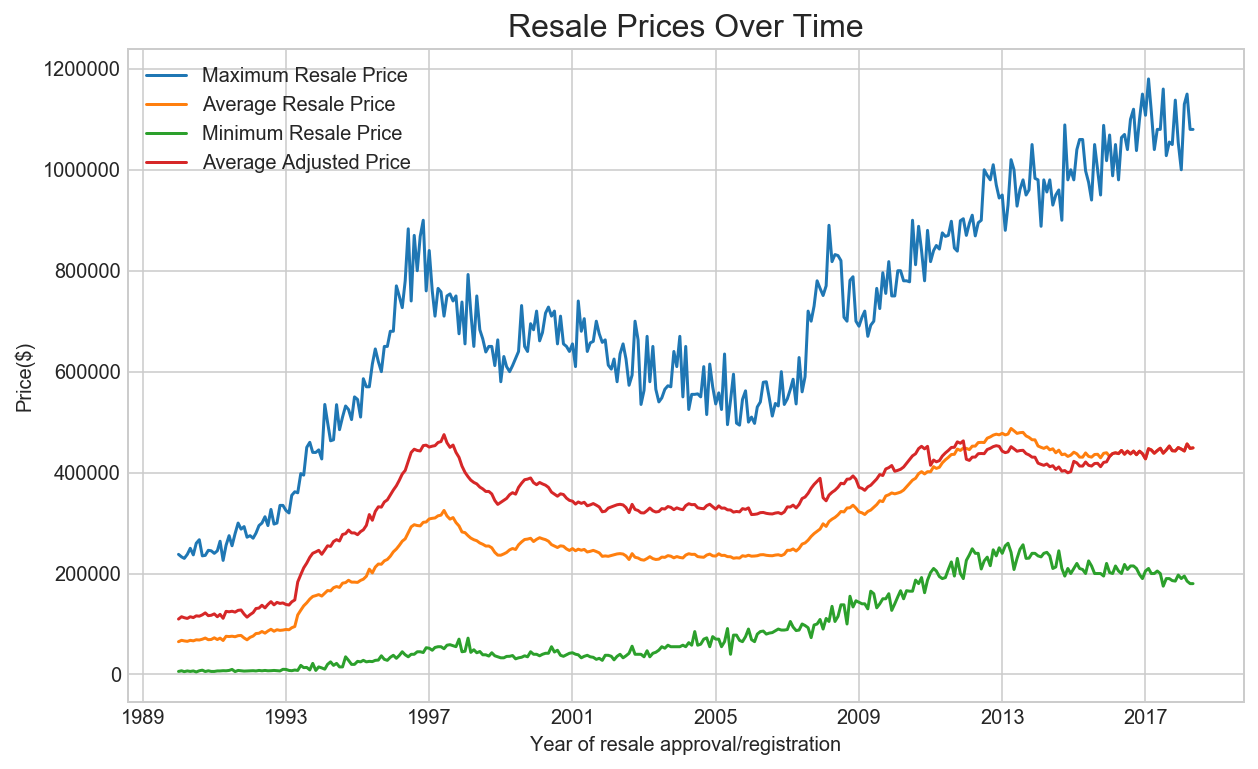

In [11]:
plt.figure(figsize=(10,6))

plt.plot(resale.groupby('date').max()['resale_price'])
plt.plot(resale.groupby('date').mean()['resale_price'])
plt.plot(resale.groupby('date').min()['resale_price'])
plt.plot(resale.groupby('date').mean()['adj_price'])

plt.legend(('Maximum Resale Price','Average Resale Price','Minimum Resale Price','Average Adjusted Price'))
plt.title('Resale Prices Over Time',fontsize = 16)
plt.xlabel('Year of resale approval/registration')
plt.ylabel('Price($)');

## Modelling 


In [436]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [445]:
def Obtain_summary(estimator,X_train, y_train, X_test, y_test):
    scores = cross_val_score(estimator, X_train, y_train, cv=10)
    score_test = estimator.score(X_test,y_test)
    print 'Mean of scores: {} | Std of scores: {}'.format(np.mean(scores), np.std(scores))
    print 'Test score: {}'.format(score_test)
    
    return {'mean_score':np.mean(scores), 
            'std_score':np.std(scores), 
            'scores':scores,
            'for_compare': [np.mean(scores),np.std(scores), score_test]
           }

def Obtain_coefficients(estimator,X_train,y_train,X):
    coefficient = pd.DataFrame({'variable':X.columns,
                                'coef':estimator.coef_,
                                'abs_coef':np.abs(estimator.coef_)})
    feat_coeff = coefficient[coefficient['abs_coef']>0]
    print '{} out of {} features are selected.' .format(feat_coeff.shape[0],len(X.columns))
    return coefficient
    

def Add_model(model_name,summary,df):
    row = pd.DataFrame([model_name]+summary['for_compare'],
                       index=['model','train_mean_score','train_std_score','test_score']).T
    
    if type(df) == list:
        df = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
        new_df = pd.concat([df,row])
    else:
        new_df = pd.concat([df,row])
        
    return new_df

In [568]:
def Analyse_coef(coefficient,df):
    print 'Coefficients not used: {}'.format([col for col in df.columns if col not in list(coefficient.variable)])
    
    print coefficient.sort_values('abs_coef',ascending = False).head(10)
    
    ##################First Row of Graphs##################
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,3))
    #STOREY_RANGE Graph [0][0]
    storey_col = [col for col in X.columns if 'storey' in col] 
    df_storey_col = pd.DataFrame(coefficient.set_index('variable')['coef'].T[storey_col].sort_values(ascending=False))

    sns.barplot(y=df_storey_col.index,x = df_storey_col.coef,orient='h',ax=ax[0])
    ax[0].set_ylabel('Storey Range')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Storey Range')

    #FLAT_TYPE Graph [0][1]
    flat_type_col = [col for col in X.columns if 'flat_type' in col] 
    df_flat_type = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_type_col ].sort_values(ascending =False))
    sns.barplot(y=df_flat_type.index,x = df_flat_type.coef,orient='h',ax=ax[1])
    ax[1].set_yticklabels([col[10:] for col in df_flat_type.index])
    ax[1].set_ylabel('Flat Type')
    ax[1].set_xlabel('Coefficients')
    ax[1].set_title('Analysis of Coefficients for Flat Type');

    ##################Second Row of Graphs##################
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,4))
    #FLAT_MODEL Graph [1][0]
    flat_model_col = [col for col in X.columns if 'flat_model' in col] 
    df_flat_model = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_model_col].sort_values(ascending = False))
    sns.barplot(y=df_flat_model.index,x = df_flat_model.coef,orient='h',ax=ax[0])
    ax[0].set_yticklabels([col[11:] for col in df_flat_model.index])
    ax[0].set_ylabel('Flat Model')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Flat Model');

    #Month Graph [1][1]
    try: 
        flat_month = [col for col in X.columns if 'month' in col] 
        df_month = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_month])
        sns.barplot(y=df_month.index,x = df_month.coef,orient='h',ax=ax[1])
        ax[1].set_yticklabels([col[:6]+col[-2:] for col in df_month.index])
        ax[1].set_ylabel('Flat Model')
        ax[1].set_xlabel('Coefficients')
        ax[1].set_title('Analysis of Coefficients for Flat Model');
    except:
        pass

    ##################ThirdRow of Graphs################## 
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,6))
    #TOWN ax[0]
    flat_town = [col for col in X.columns if 'town' in col] 
    df_town = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_town].sort_values(ascending=False))
    sns.barplot(y=df_town.index,x = df_town.coef,orient='h',ax=ax[0])
    ax[0].set_yticklabels([col[5:] for col in df_town.index])
    ax[0].set_ylabel('Flat Model')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Flat Model');

    #YEAR ax[1]
    try:
        flat_year = [col for col in X.columns if 'year' in col] 
        df_year = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_year])
        sns.barplot(y=df_year.index,x = df_year.coef,orient='h',ax=ax[1])
        ax[1].set_yticklabels([col[5:] for col in df_year.index])
        ax[1].set_ylabel('Flat Model')
        ax[1].set_xlabel('Coefficients')
        ax[1].set_title('Analysis of Coefficients for Flat Model')
    except:
        pass

In [437]:
ss= StandardScaler()

<a id='iter1'></a>
## Iteration 1
| **X** | **y**|
|------|------|
| dummy: ['flat_model','flat_type', 'storey', 'year', 'month_str', 'town']] <br> cont.: ['latitude', 'longitude',calculated remaining lease]  | resale['resale_price']|

<a id='1slr'></a>
#### Iteration1: Single Variable Linear Regression
want to see the effect of each single variable on resale_price

In [533]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
X_df = pd.concat([df1,df2,df3,df4,df5],axis=1)
y = resale['resale_price']

for col in X_df.columns:
    X = X_df[[col]]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        train_size=0.25, 
                                                        random_state=42)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '--------------------------------------'

flat_model_PREMIUM
Mean of scores: 0.0266388027912 | Std of scores: 0.00146482144837
Test score: 0.0272534752291
--------------------------------------
flat_model_IMPROVED
Mean of scores: 0.00279399342718 | Std of scores: 0.000728804400191
Test score: 0.00300042507812
--------------------------------------
flat_model_MODEL_A
Mean of scores: 0.00104345170632 | Std of scores: 0.000392697829407
Test score: 0.000846069162675
--------------------------------------
flat_model_ADJOINED FLAT
Mean of scores: -9.37026217267e-05 | Std of scores: 8.84644000211e-05
Test score: 5.96124243513e-06
--------------------------------------
flat_model_APARTMENT
Mean of scores: 0.0976236461434 | Std of scores: 0.00115155303757
Test score: 0.0982618330832
--------------------------------------
flat_model_DBSS
Mean of scores: 0.0111840532918 | Std of scores: 0.0023811861171
Test score: 0.0112977479658
--------------------------------------
flat_model_MAISONETTE
Mean of scores: 0.0568860517213 | Std of scores:

Mean of scores: 0.00025825650425 | Std of scores: 0.000311094512463
Test score: 0.000352179136506
--------------------------------------
month_str_06
Mean of scores: -6.19930327648e-05 | Std of scores: 0.000117821965988
Test score: 3.1988579599e-05
--------------------------------------
month_str_07
Mean of scores: -6.75715633699e-05 | Std of scores: 8.56027251605e-05
Test score: -2.23785121163e-05
--------------------------------------
month_str_08
Mean of scores: -1.20088264411e-05 | Std of scores: 8.09917295779e-05
Test score: 5.21495307493e-07
--------------------------------------
month_str_09
Mean of scores: -2.66591862821e-05 | Std of scores: 0.000120832798684
Test score: 2.300402147e-05
--------------------------------------
month_str_10
Mean of scores: -1.76966440164e-06 | Std of scores: 0.000121607183639
Test score: 5.81550145953e-05
--------------------------------------
month_str_11
Mean of scores: -5.50172698044e-05 | Std of scores: 0.000104799949016
Test score: 2.67757651

In [534]:
summary_SLR.sort_values('train_mean_score',ascending=False).head(20)

model train_mean_score train_std_score test_score
0             floor_area_sqm         0.407726      0.00287922   0.407498
0           flat_type_3 ROOM         0.259527      0.00345736   0.258195
0        lease_commence_date         0.240506      0.00266939   0.241985
0        flat_type_EXECUTIVE         0.141186      0.00510496   0.142441
0           flat_type_5 ROOM         0.134468      0.00375787   0.133093
0       flat_model_APARTMENT        0.0976236      0.00115155  0.0982618
0  flat_model_NEW GENERATION        0.0833812      0.00232148  0.0826475
0      flat_model_MAISONETTE        0.0568861      0.00453982  0.0568526
0                  year_2012        0.0460567      0.00343784  0.0477523
0                  year_1992        0.0372057      0.00219784  0.0371655
0                  year_1991        0.0371102      0.00196296  0.0363441
0                  year_2013        0.0370378      0.00308734  0.0386197
0                  year_2017        0.0331875      0.00265629  0.0335672
0                  year_2016        0.0312379      0.00271318  0.0294827
0                  year_2011        0.0287984      0.00232454  0.0288236
0                  year_2015        0.0270078      0.00203547  0.0256122
0         flat_model_PREMIUM        0.0266388      0.00146482  0.0272535
0                  year_1993        0.0264523      0.00138274  0.0267427
0                  year_2014        0.0257379      0.00231006  0.0260898
0                  year_1994        0.0213017       0.0019514  0.0213156

In [535]:
summary_SLR.sort_values('train_mean_score',ascending=True).head(20)

model train_mean_score train_std_score   test_score
0    flat_model_ADJOINED FLAT     -9.37026e-05     8.84644e-05  5.96124e-06
0           town_CENTRAL AREA     -7.92969e-05     8.89329e-05 -1.50136e-06
0                month_str_03      -7.4812e-05     7.26918e-05 -3.01071e-05
0              town_WOODLANDS     -7.39338e-05     7.66442e-05 -1.07973e-05
0                month_str_07     -6.75716e-05     8.56027e-05 -2.23785e-05
0                town_HOUGANG     -6.22459e-05     7.44299e-05  1.34666e-05
0                month_str_06      -6.1993e-05     0.000117822  3.19886e-05
0                   year_1996     -5.64288e-05      8.9854e-05  3.99682e-05
0                month_str_11     -5.50173e-05       0.0001048  2.67758e-05
0                month_str_09     -2.66592e-05     0.000120833   2.3004e-05
0                month_str_08     -1.20088e-05     8.09917e-05  5.21495e-07
0                month_str_10     -1.76966e-06     0.000121607   5.8155e-05
0        town_KALLANG/WHAMPOA      2.97692e-05     0.000211152  3.55841e-05
0                month_str_12      5.71245e-05     0.000204646  9.73726e-05
0                month_str_04      6.57291e-05     0.000178567  0.000140944
0  calculated_remaining_lease      6.85418e-05     0.000109687  0.000185728
0                   storey_10      0.000112923     0.000230776  0.000206019
0          town_BUKIT PANJANG      0.000131144     0.000199228  0.000164073
0           town_LIM CHU KANG      0.000150362     0.000128057  0.000172567
0          town_MARINE PARADE      0.000193544     0.000285465  0.000375791

**Insights** <br>
From the summary scores, the factors that are quite important to resale_price are: 
- floor_area_sqm
- 3 room, 5 room, executive etc --> flat_type
- new generation, apartments, premium etc --> flat_model (a few factors only)
- year
- lease_commence_date <br>

The factors that are not important are:
- month 
- certain towns 

<a id='1mlrcat'></a>
#### Iteration 1: Multiple Variable Linear Regression by Category

In [387]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
X_df = pd.concat([df1,df2,df3,df4,df5],axis=1)
y = resale['resale_price']

for cat in ['flat_type','storey','year','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in X_df.columns if cat in col]
    X = X_df[cat_pred ]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        train_size=0.25, 
                                                        random_state=42)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: 0.430417138078 | Std of scores: 0.0030602861634
Test score: 0.429867053339
6 out of 6 features are selected.
--------------------------------
storey
Mean of scores: 0.0574939847516 | Std of scores: 0.00301959872567
Test score: 0.0578050429222
7 out of 7 features are selected.
--------------------------------
year
Mean of scores: 0.465925346305 | Std of scores: 0.00551395880622
Test score: 0.466375632303
28 out of 28 features are selected.
--------------------------------
month_str
Mean of scores: 0.00164215651938 | Std of scores: 0.000531005447811
Test score: 0.00164599240851
11 out of 11 features are selected.
--------------------------------
town
Mean of scores: 0.0970904482759 | Std of scores: 0.00451630806381
Test score: 0.0972623463854
26 out of 26 features are selected.
--------------------------------
flat_model
Mean of scores: 0.261225850883 | Std of scores: 0.00372362013109
Test score: 0.261283715328
12 out of 12 features are selected.
---------------

In [388]:
summary_MLR.sort_values('train_mean_score',ascending=False)

model train_mean_score train_std_score  test_score no_of_feat
0        year         0.465925      0.00551396    0.466376         28
0   flat_type         0.430417      0.00306029    0.429867          6
0  flat_model         0.261226      0.00372362    0.261284         12
0        town        0.0970904      0.00451631   0.0972623         26
0      storey         0.057494       0.0030196    0.057805          7
0   month_str       0.00164216     0.000531005  0.00164599         11

**Insights** <br>
From the summary scores, the dummy factors that are quite important to resale_price are:
- year 
- flat_type
- flat_model

The factors that are not important are:
- month and surprisingly,
- storey

This is in sync with the SLR results above. 

<a id='1mlrall'></a>
#### Iteration 1: Multiple Variable Linear Regression - ALL

In [536]:
X = pd.concat([df1,df2,df3,df4,df5],axis=1)
ss = StandardScaler()
y = resale['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.25, 
                                                    random_state=42)

Mean of scores: 0.912605109936 | Std of scores: 0.00103202193281
Test score: 0.912679098763
95 out of 95 features are selected.
Coefficients not used: []
        abs_coef          coef          variable
46  66169.069614  66169.069614         year_2012
44  63306.953849  63306.953849         year_2010
45  59309.447477  59309.447477         year_2011
51  58519.986806  58519.986806         year_2017
50  58139.009499  58139.009499         year_2016
47  57962.800878  57962.800878         year_2013
15  57073.098214  57073.098214  flat_type_5 ROOM
49  55084.084092  55084.084092         year_2015
48  54570.507333  54570.507333         year_2014
43  50473.856082  50473.856082         year_2009


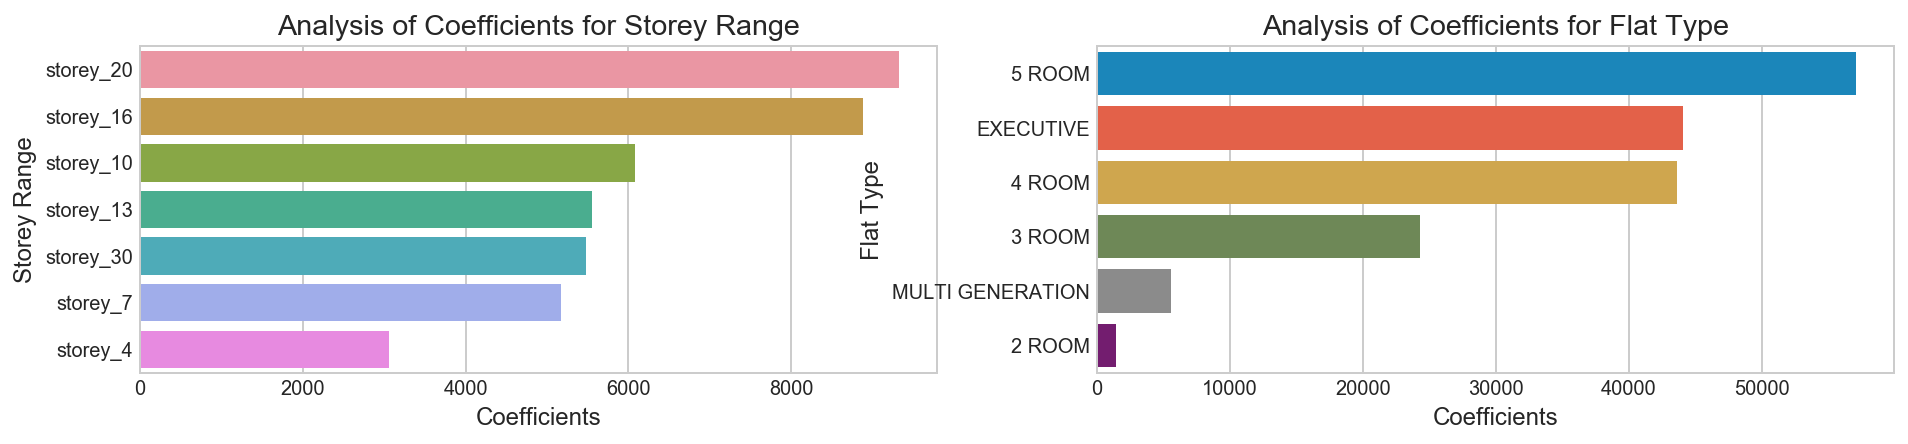

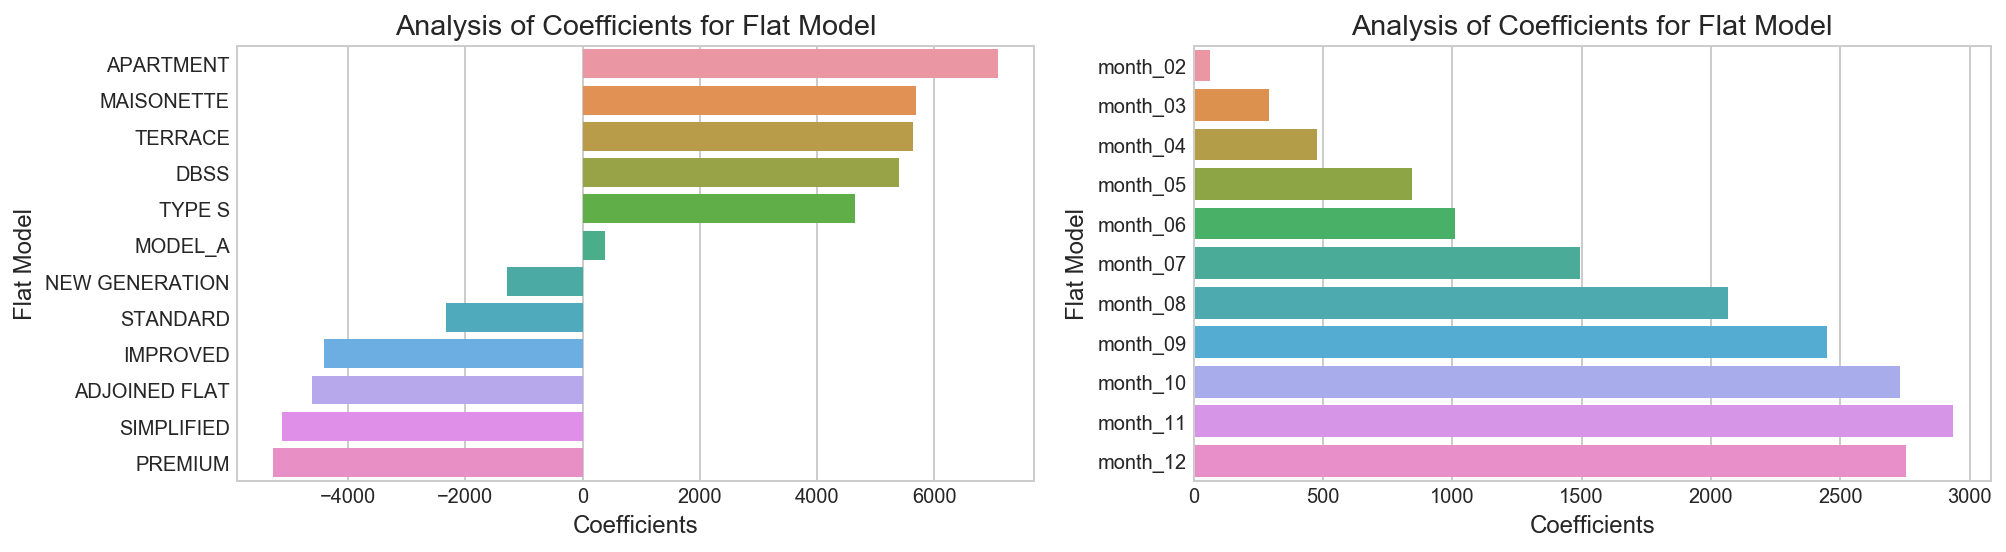

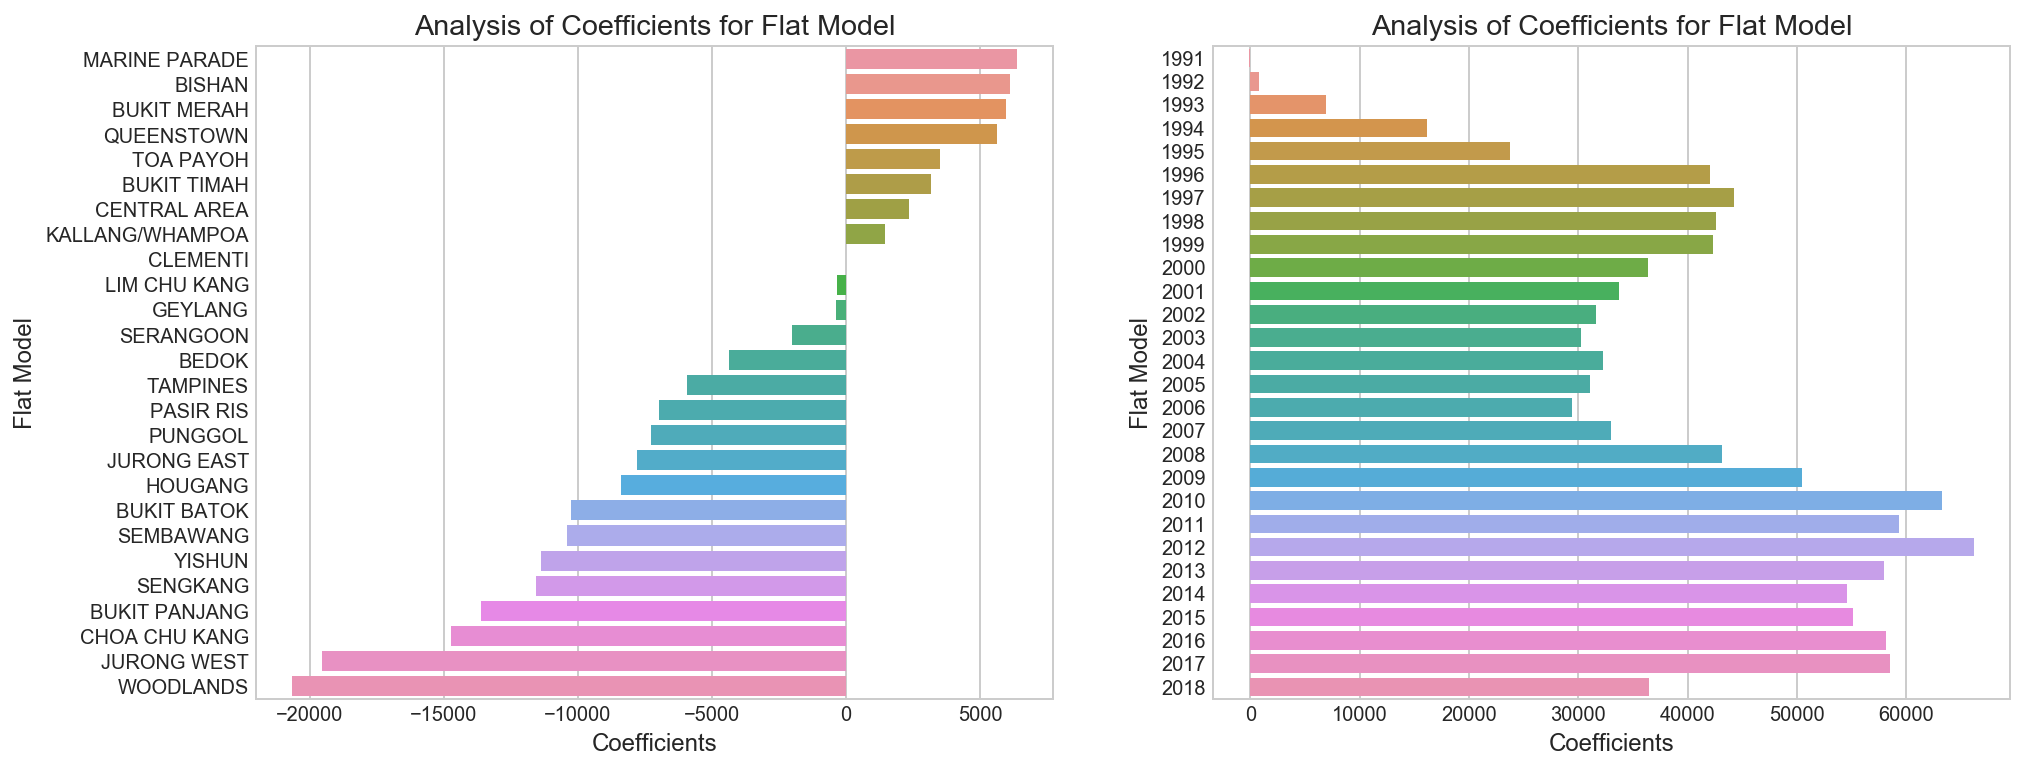

In [542]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter1_basic linreg',summary_model,[])

coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='1regularization'></a>
#### Iteration 1: Ridge,Lasso,Enet

Mean of scores: 0.912606931946 | Std of scores: 0.00103116664896
Test score: 0.912678028073
95 out of 95 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
94  79336.757136  79336.757136         lease_commence_date
92  58638.563290 -58638.563290  calculated_remaining_lease
15  56961.632578  56961.632578            flat_type_5 ROOM
16  43966.148111  43966.148111         flat_type_EXECUTIVE
14  43522.615152  43522.615152            flat_type_4 ROOM
93  42656.499538  42656.499538              floor_area_sqm
46  35217.542816  35217.542816                   year_2012
31  32612.923418  32612.923418                   year_1997
30  31648.719156  31648.719156                   year_1996
47  30859.304539  30859.304539                   year_2013


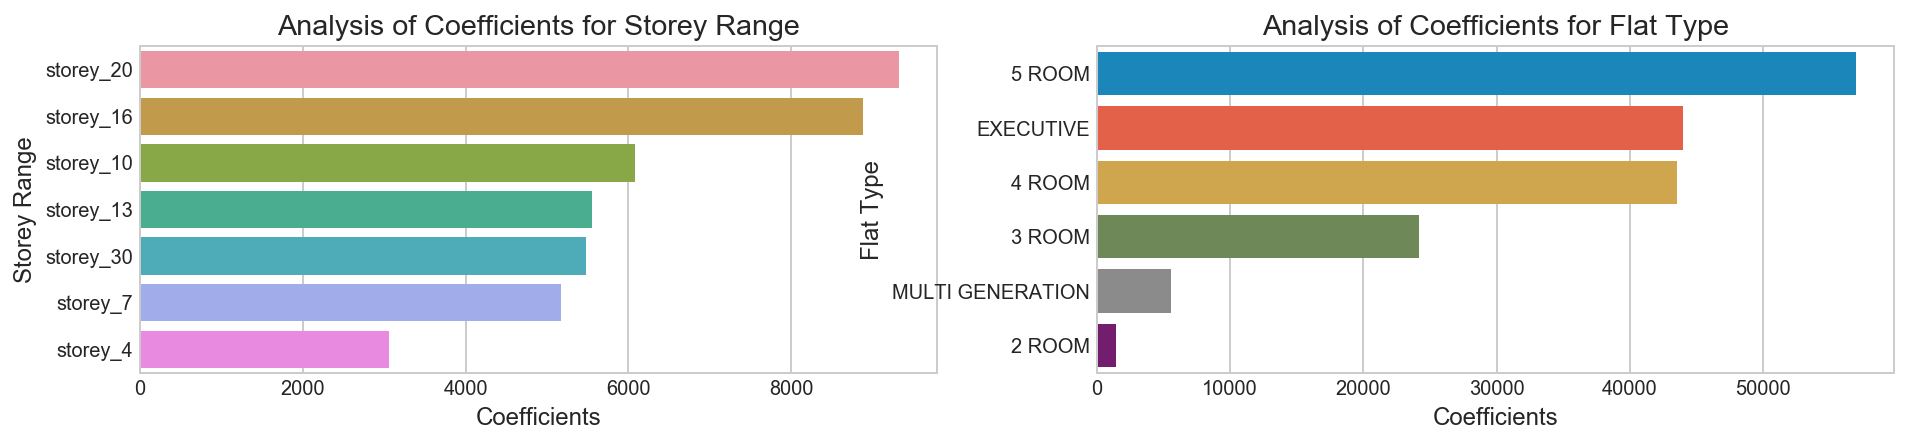

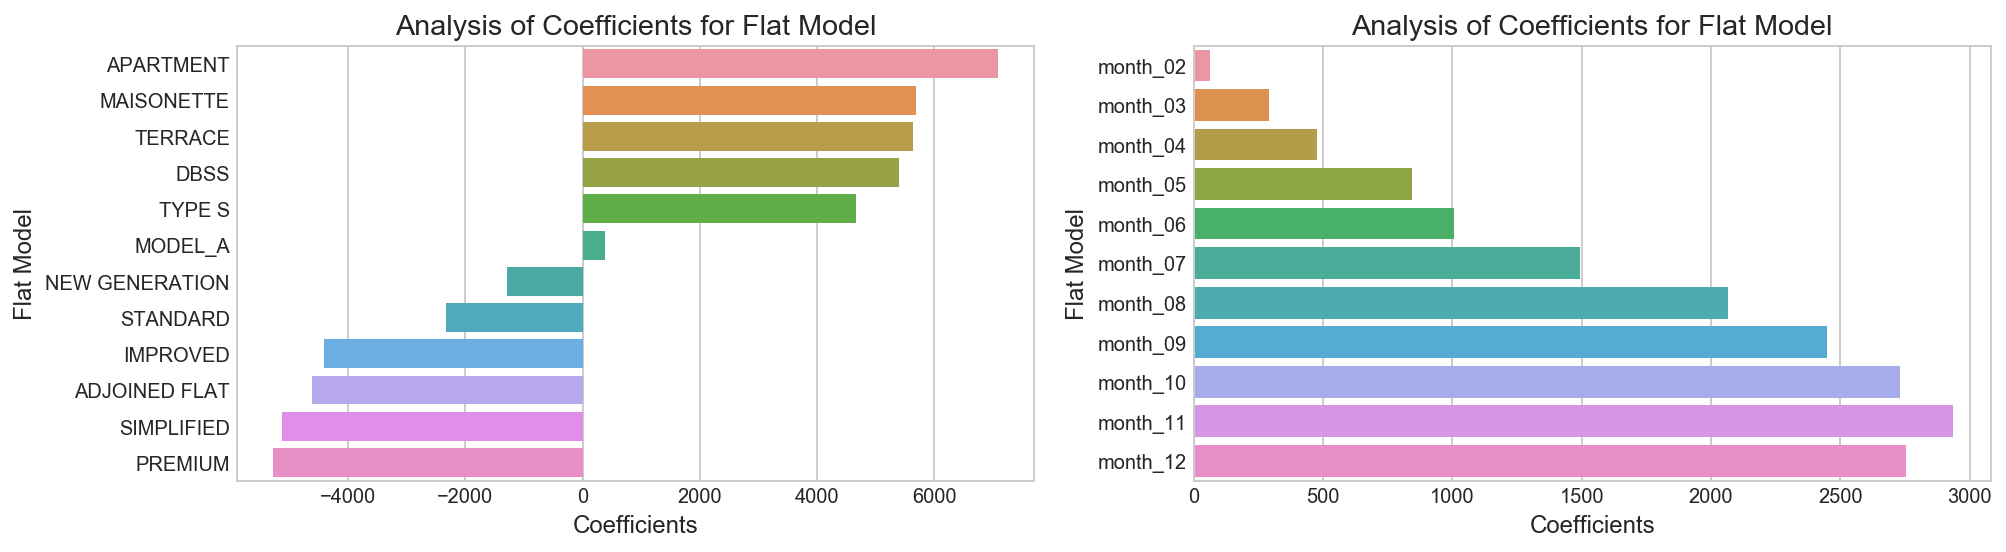

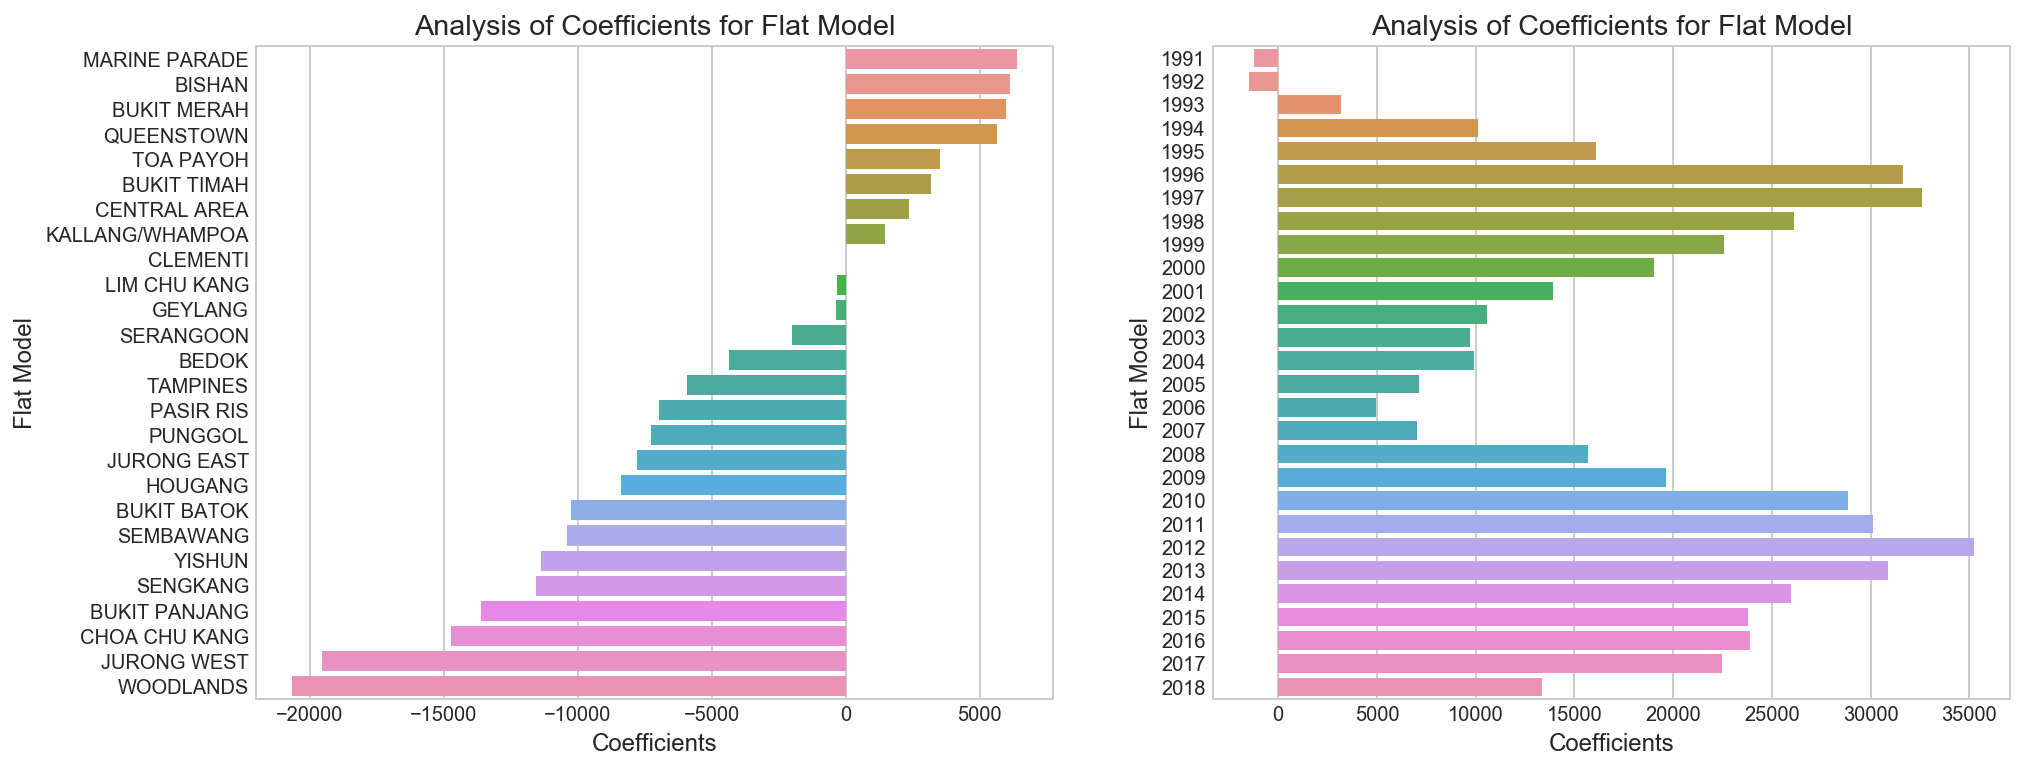

In [543]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)
summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter1_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.912251100765 | Std of scores: 0.00103462504084
Test score: 0.91232547874
87 out of 95 features are selected.
Coefficients not used: []
         abs_coef           coef                    variable
94  123809.269708  123809.269708         lease_commence_date
92  104950.835136 -104950.835136  calculated_remaining_lease
93   48606.188098   48606.188098              floor_area_sqm
15   30942.731037   30942.731037            flat_type_5 ROOM
16   27544.229963   27544.229963         flat_type_EXECUTIVE
31   24242.333990   24242.333990                   year_1997
30   23984.640725   23984.640725                   year_1996
88   18636.515239  -18636.515239              town_WOODLANDS
76   17756.716816  -17756.716816            town_JURONG WEST
14   15785.284481   15785.284481            flat_type_4 ROOM


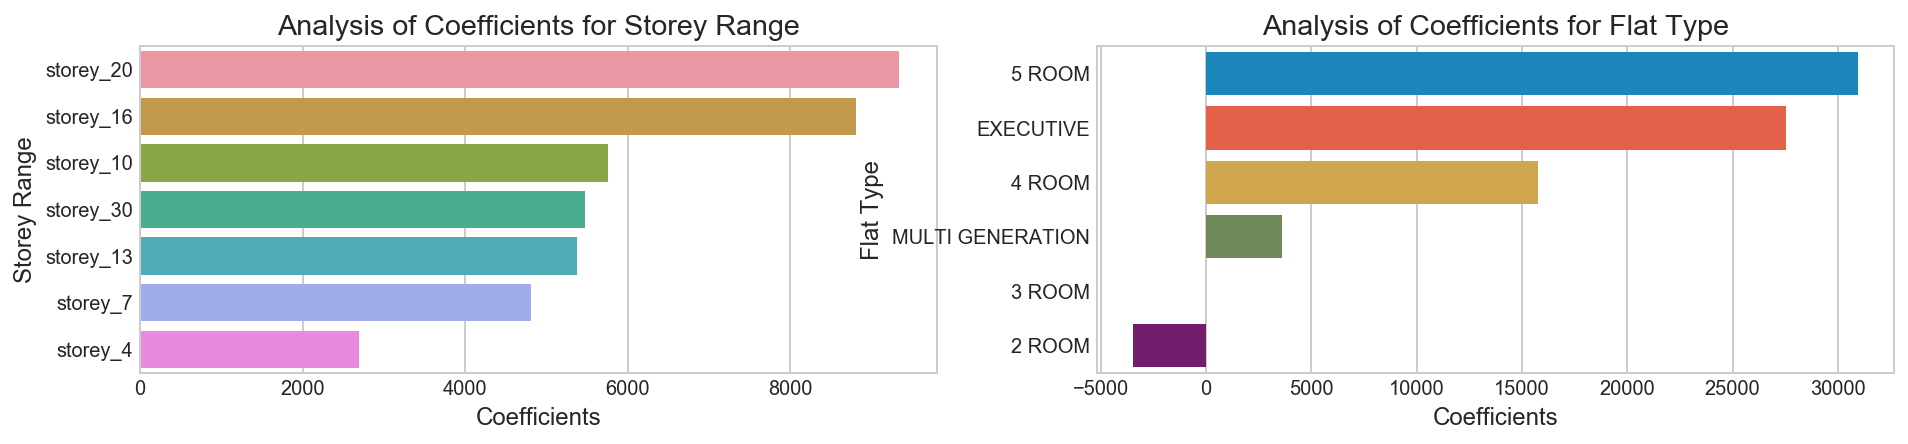

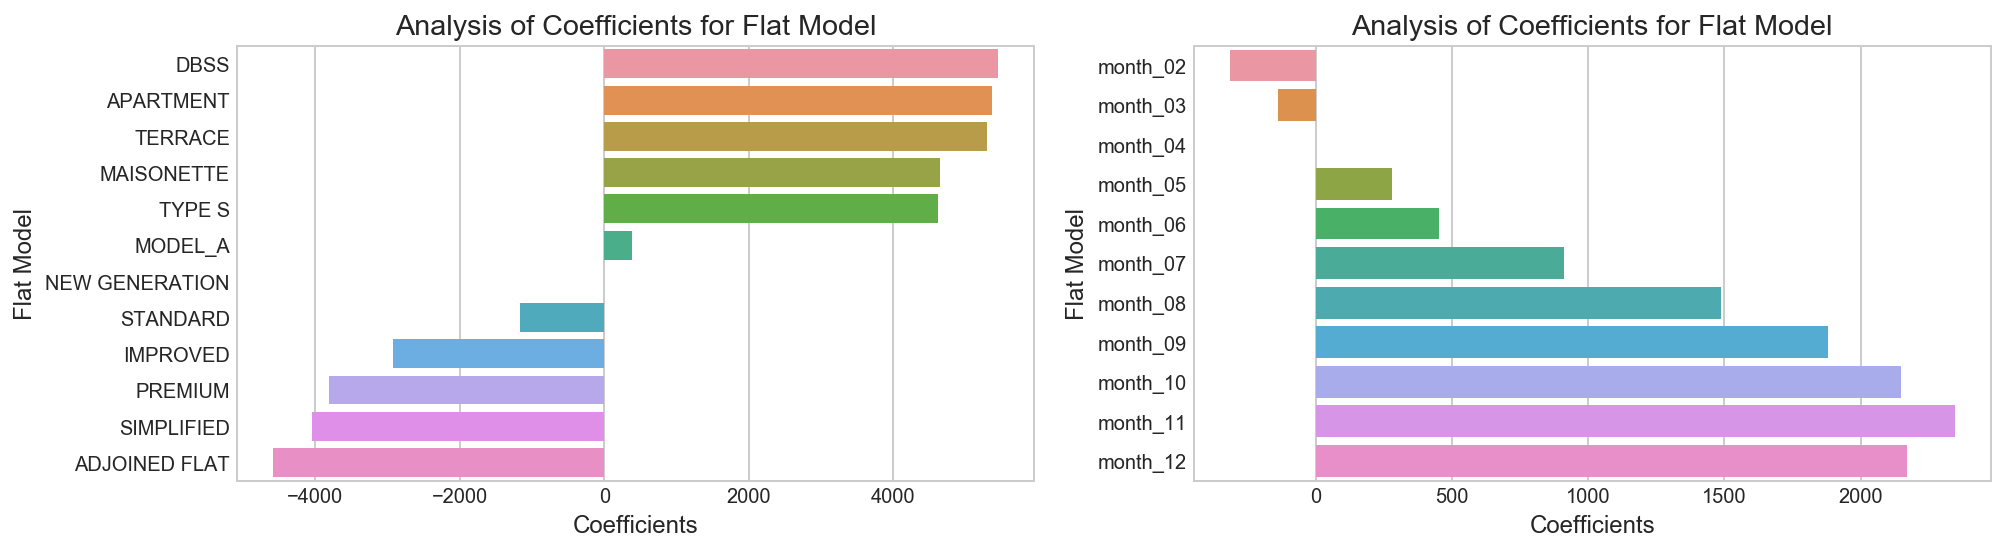

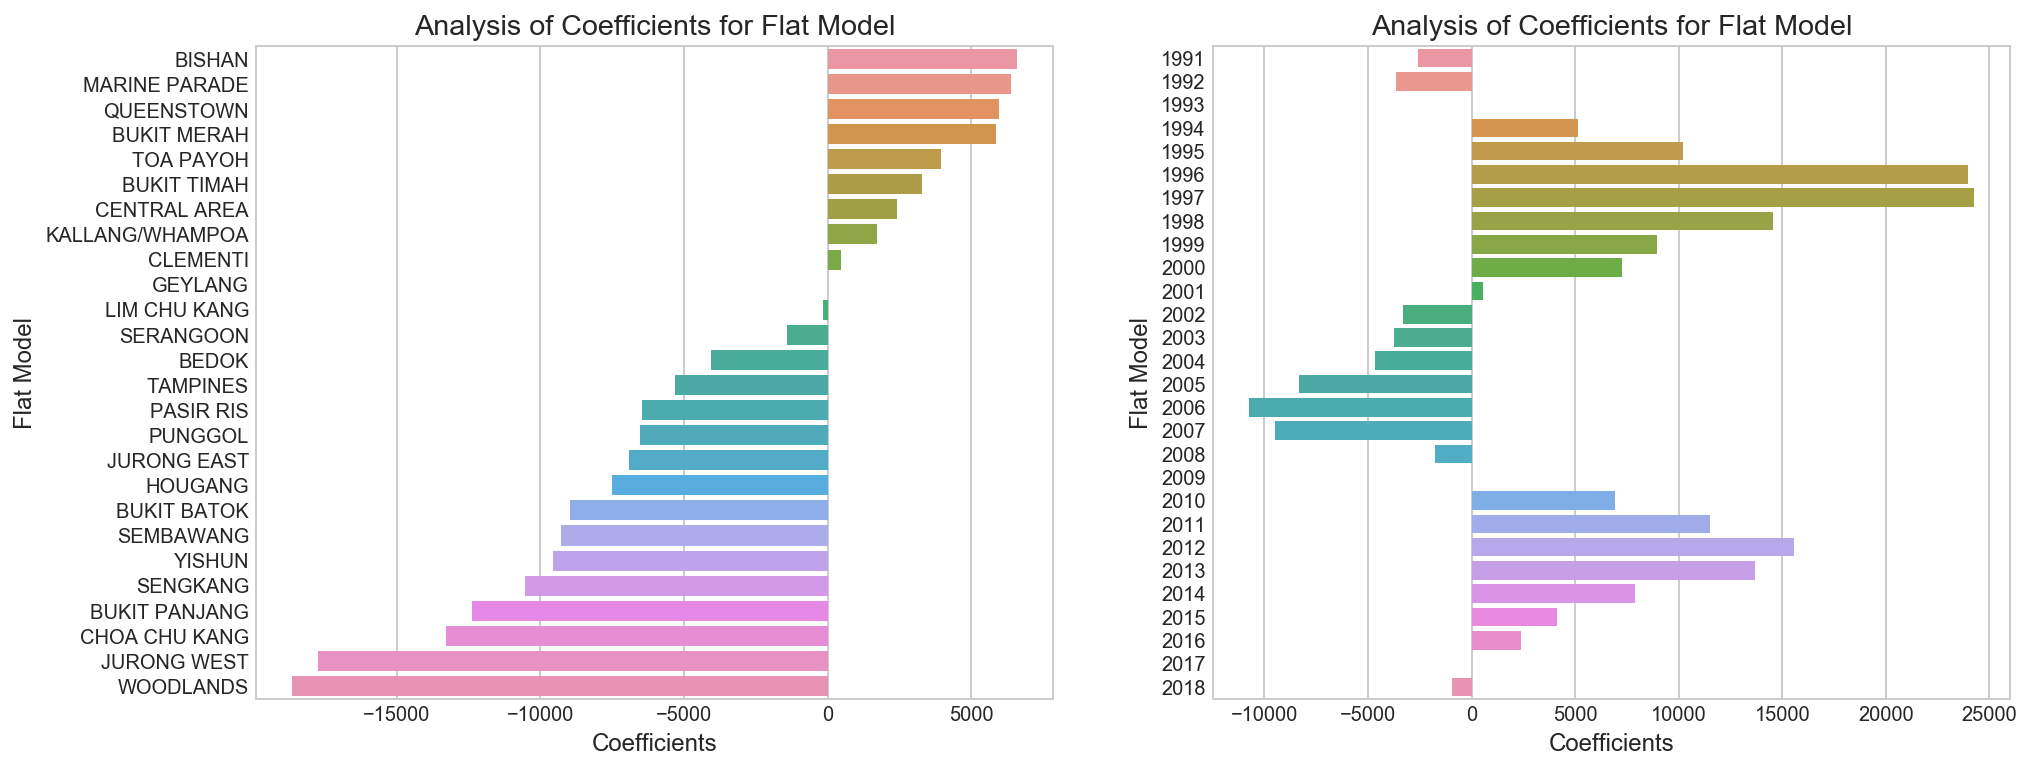

In [544]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter1_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.912251100765 | Std of scores: 0.00103462504084
Test score: 0.91232547874
87 out of 95 features are selected.
Coefficients not used: []
         abs_coef           coef                    variable
94  123809.269708  123809.269708         lease_commence_date
92  104950.835136 -104950.835136  calculated_remaining_lease
93   48606.188098   48606.188098              floor_area_sqm
15   30942.731037   30942.731037            flat_type_5 ROOM
16   27544.229963   27544.229963         flat_type_EXECUTIVE
31   24242.333990   24242.333990                   year_1997
30   23984.640725   23984.640725                   year_1996
88   18636.515239  -18636.515239              town_WOODLANDS
76   17756.716816  -17756.716816            town_JURONG WEST
14   15785.284481   15785.284481            flat_type_4 ROOM


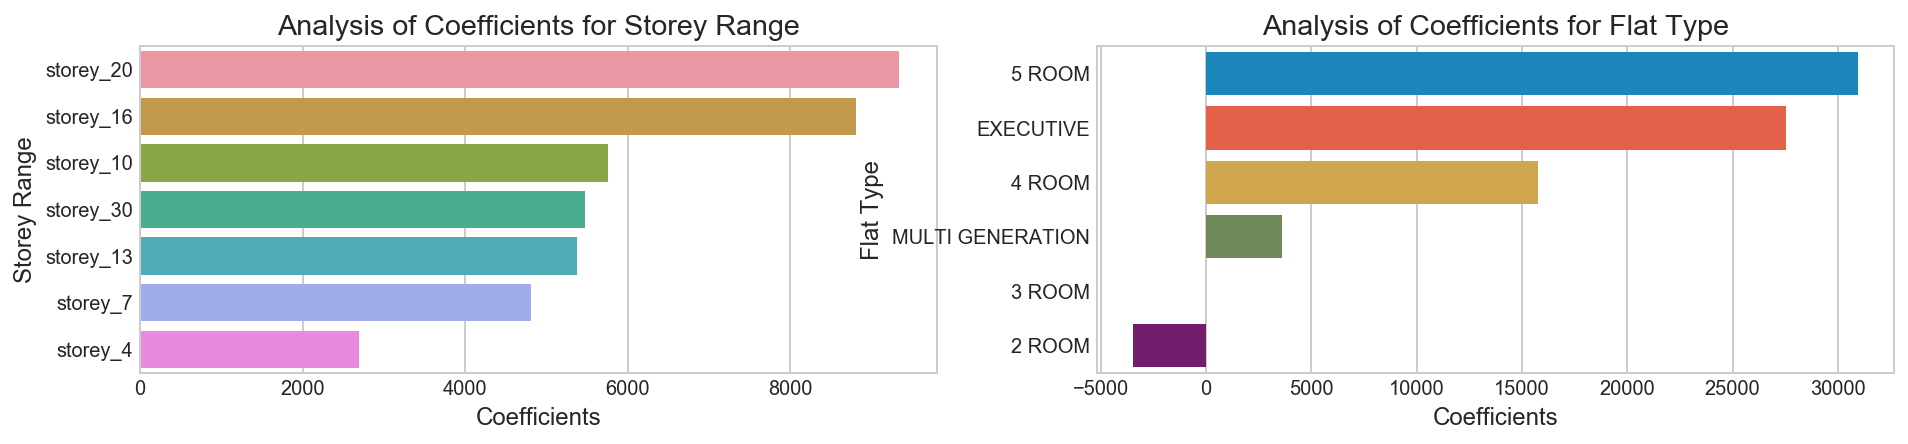

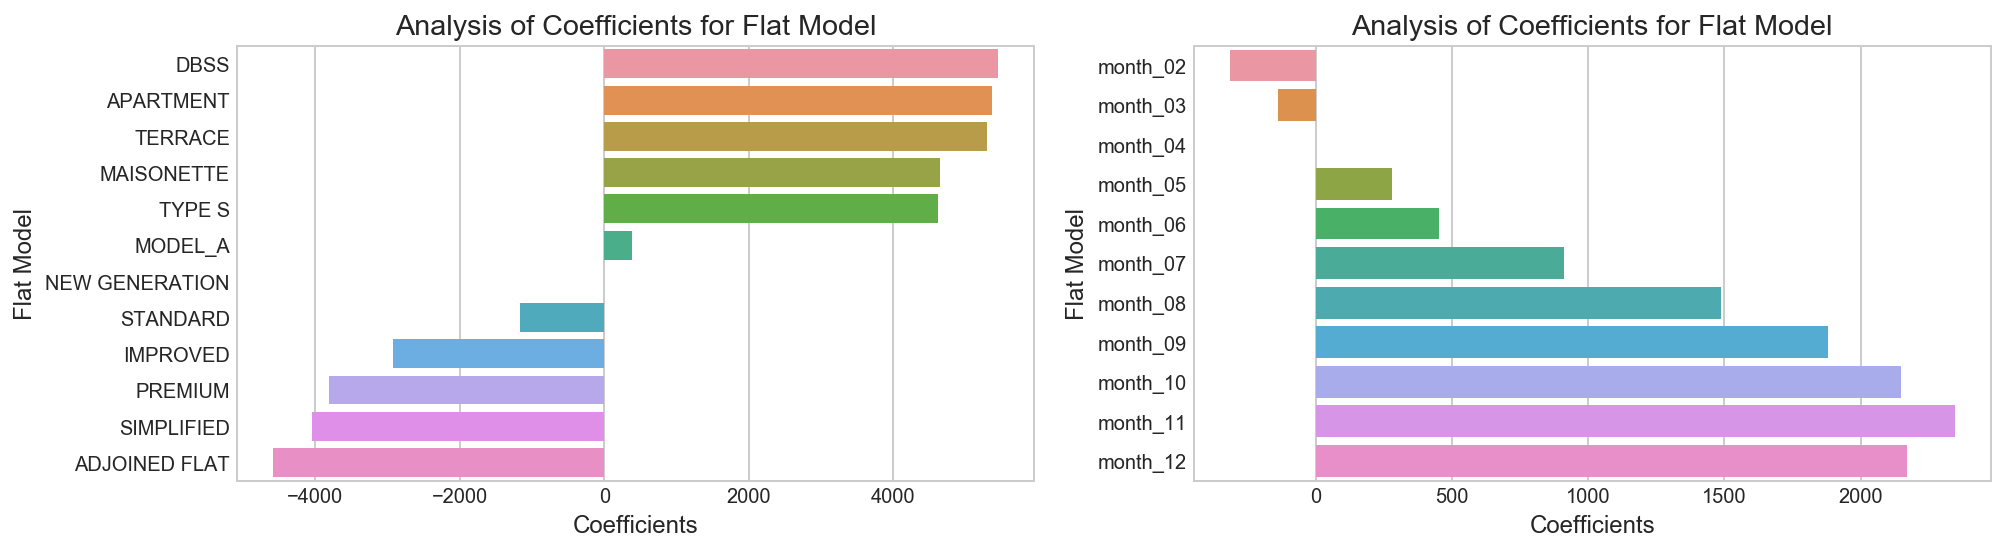

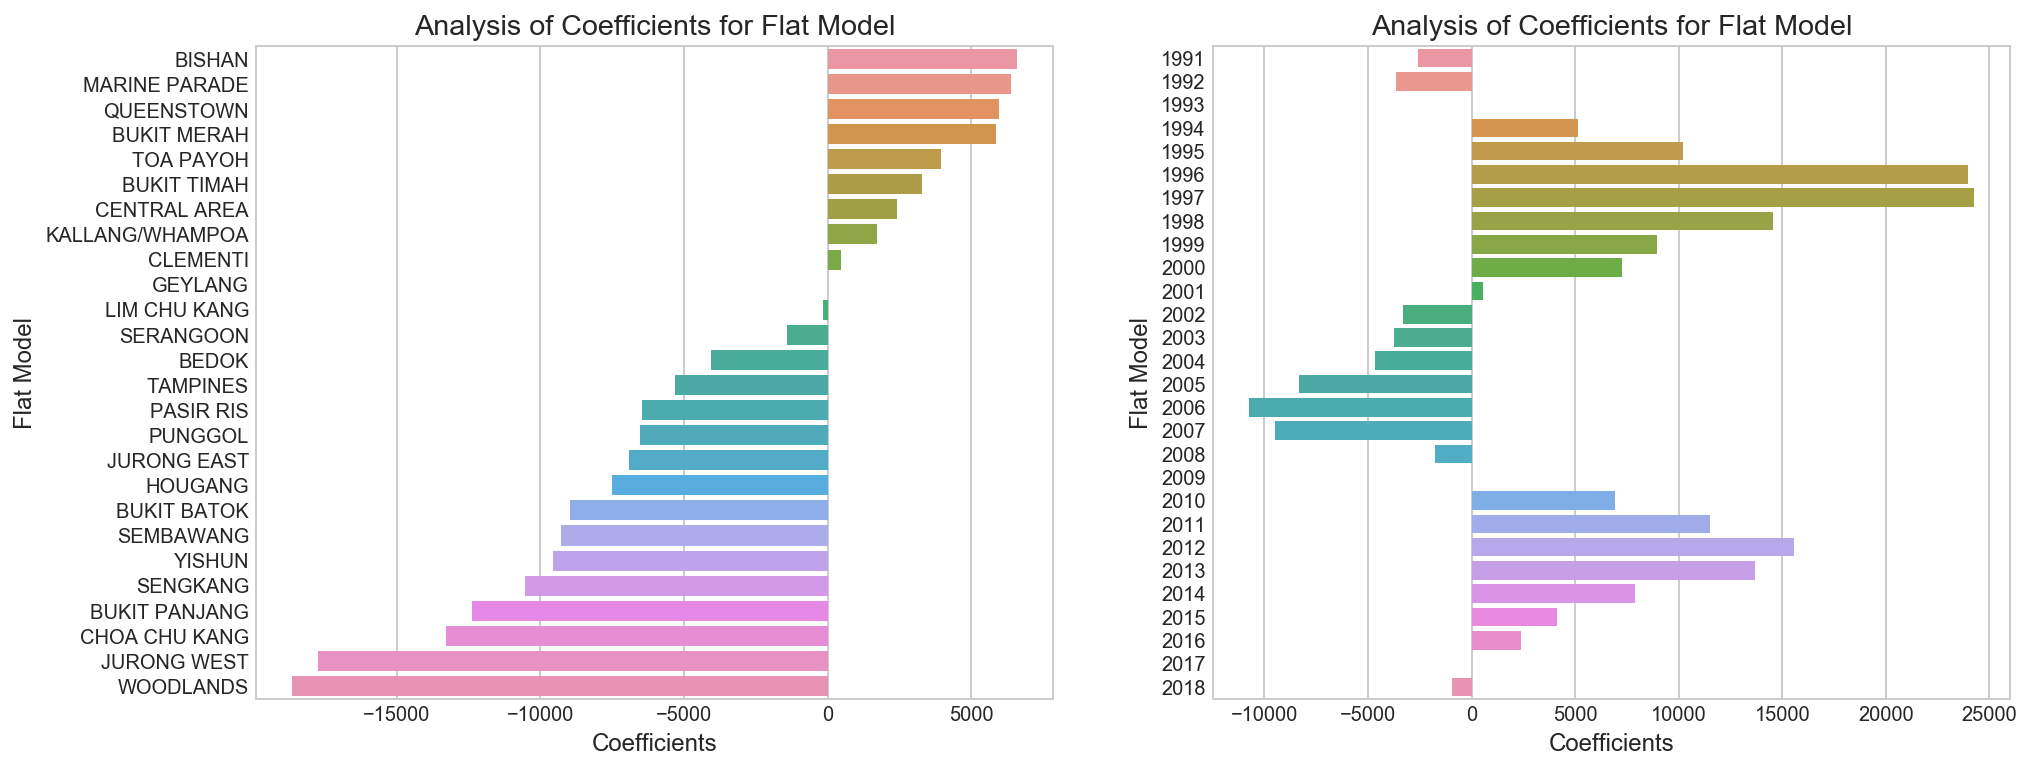

In [545]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter1_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

In [546]:
summary

model train_mean_score train_std_score test_score
0  iter1_basic linreg         0.912605      0.00103202   0.912679
0   iter1_basic ridge         0.912607      0.00103117   0.912678
0   iter1_basic lasso         0.912251      0.00103463   0.912325
0    iter1_basic enet         0.912251      0.00103463   0.912325

<a id='iter2'></a>
## Iteration 2
| **X** | **y**|
|------|------|
| dummy: ['flat_model','flat_type', 'storey', 'year', 'month_str', 'town']] <br> cont.: ['latitude', 'longitude',calculated remaining lease]  | resale['adj_price']|

<a id='2slr'></a>
#### Iteration2: Single Variable Linear Regression
Want to see the effect of each single variable on resale_price

In [547]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
X_df = pd.concat([df1,df2,df3,df4,df5],axis=1)
y = resale['adj_price']

for col in X_df.columns:
    X = X_df[[col]]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        train_size=0.25, 
                                                        random_state=42)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '-----------------------------'

flat_model_PREMIUM
Mean of scores: 0.0117605653797 | Std of scores: 0.000728815231971
Test score: 0.012330093974
-----------------------------
flat_model_IMPROVED
Mean of scores: 0.00359444495322 | Std of scores: 0.000770307887927
Test score: 0.00385999010205
-----------------------------
flat_model_MODEL_A
Mean of scores: 0.00101810634767 | Std of scores: 0.000394136869051
Test score: 0.00087838866476
-----------------------------
flat_model_ADJOINED FLAT
Mean of scores: -9.91385035741e-05 | Std of scores: 7.17313772439e-05
Test score: 5.55378846478e-06
-----------------------------
flat_model_APARTMENT
Mean of scores: 0.0974013851117 | Std of scores: 0.00197922210546
Test score: 0.0970919958514
-----------------------------
flat_model_DBSS
Mean of scores: 0.00653358835837 | Std of scores: 0.00145474282129
Test score: 0.00674868323687
-----------------------------
flat_model_MAISONETTE
Mean of scores: 0.093135877386 | Std of scores: 0.00465950698791
Test score: 0.0940848582329
-------

month_str_08
Mean of scores: 3.50822934913e-05 | Std of scores: 0.000132566162343
Test score: 1.9149221605e-05
-----------------------------
month_str_09
Mean of scores: 3.01957223905e-05 | Std of scores: 0.000188174816679
Test score: 6.21370313831e-05
-----------------------------
month_str_10
Mean of scores: 0.000126316382124 | Std of scores: 0.000193756977084
Test score: 0.000181450722359
-----------------------------
month_str_11
Mean of scores: -9.13329205034e-05 | Std of scores: 7.3277550344e-05
Test score: -7.19312076436e-06
-----------------------------
month_str_12
Mean of scores: -8.08928687934e-05 | Std of scores: 9.39311869514e-05
Test score: -7.10269518223e-06
-----------------------------
town_BEDOK
Mean of scores: 0.00351280157011 | Std of scores: 0.00112303592871
Test score: 0.00413857745926
-----------------------------
town_BISHAN
Mean of scores: 0.0205611278509 | Std of scores: 0.00282293017504
Test score: 0.0209391134226
-----------------------------
town_BUKIT BATO

In [548]:
summary_SLR.sort_values('train_mean_score',ascending=False).head(20)

model train_mean_score train_std_score test_score
0              floor_area_sqm         0.578903      0.00364711   0.579729
0            flat_type_3 ROOM          0.33969      0.00383253   0.339497
0         lease_commence_date         0.212147      0.00344968   0.213952
0         flat_type_EXECUTIVE         0.206754      0.00615289   0.207267
0            flat_type_5 ROOM         0.171241      0.00497928   0.170758
0   flat_model_NEW GENERATION        0.0984898      0.00218629  0.0982864
0        flat_model_APARTMENT        0.0974014      0.00197922   0.097092
0       flat_model_MAISONETTE        0.0931359      0.00465951  0.0940849
0                   year_1991        0.0393468      0.00254816  0.0387476
0                   year_1992        0.0387426      0.00237915  0.0388388
0  calculated_remaining_lease        0.0379457       0.0013746  0.0386713
0              town_PASIR RIS        0.0294536      0.00165393  0.0291776
0                   year_1993        0.0225013      0.00156224  0.0226244
0            flat_type_2 ROOM         0.020622      0.00103078  0.0219369
0                 town_BISHAN        0.0205611      0.00282293  0.0209391
0                   storey_20        0.0201475      0.00226872  0.0185487
0       flat_model_SIMPLIFIED        0.0183779      0.00125045  0.0181466
0                   storey_16        0.0162611      0.00246517   0.015845
0                   year_1997        0.0152552      0.00209525   0.015214
0                   longitude        0.0147711      0.00129353  0.0140606

In [549]:
summary_SLR.sort_values('train_mean_score',ascending=True).head(20)

model train_mean_score train_std_score   test_score
0  flat_model_ADJOINED FLAT     -9.91385e-05     7.17314e-05  5.55379e-06
0              month_str_11     -9.13329e-05     7.32776e-05 -7.19312e-06
0                 year_2000     -8.93705e-05     8.16651e-05  2.82443e-05
0              month_str_04     -8.93421e-05     7.46782e-05 -4.43637e-06
0                 year_2007     -8.23739e-05     7.77822e-05  1.09048e-05
0              month_str_12     -8.08929e-05     9.39312e-05  -7.1027e-06
0              month_str_06     -7.66739e-05     0.000134177  4.59513e-05
0        town_BUKIT PANJANG     -7.06172e-05     9.58616e-05  7.57133e-06
0              month_str_07     -6.62928e-05     9.24097e-05 -1.48207e-05
0                 storey_10     -6.19593e-05      0.00011404  2.94495e-05
0              month_str_03     -3.43697e-06     0.000141376  -4.2788e-07
0         town_CENTRAL AREA      5.90029e-07     0.000165396  0.000128785
0          town_BUKIT MERAH      4.04116e-06     0.000138396  0.000157135
0            town_WOODLANDS      5.85224e-06     0.000136356  0.000121054
0                 year_1999      1.58239e-05     0.000151337  0.000151723
0              month_str_09      3.01957e-05     0.000188175   6.2137e-05
0          flat_type_4 ROOM      3.09671e-05      0.00022761  0.000116694
0              month_str_08      3.50823e-05     0.000132566  1.91492e-05
0              month_str_05      4.44151e-05     0.000168955  0.000143973
0              town_HOUGANG      8.45749e-05     0.000126557  0.000200249

**Insights** <br>
From the summary scores, the factors that are quite important to adj_price are:
- floor_area_sqm
- 3 room, 5 room, executive etc --> flat_type
- lease_commence_date
- new generation, apartments, premium etc --> flat_model (a few factors only)
- Certain years
- Calculated_remaining_lease
- Storey height

The factors that are not important are:
- month
- certain towns
- certain years

Effect on adj_price is higher than effect on resale_price

<a id='2mlrcat'></a>
#### Iteration 2: Multiple Variable Linear Regression by Category

In [517]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
X_df = pd.concat([df1,df2,df3,df4],axis=1)
y = resale['adj_price']

for cat in ['flat_type','storey','year','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in X_df.columns if cat in col]
    X = X_df[cat_pred ]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        train_size=0.25, 
                                                        random_state=42)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: 0.581830058957 | Std of scores: 0.00372813714757
Test score: 0.582199769449
--------------------------------
storey
Mean of scores: 0.0509506230381 | Std of scores: 0.00236199609166
Test score: 0.0509185823419
--------------------------------
year
Mean of scores: 0.239839764287 | Std of scores: 0.00497490570762
Test score: 0.239265382107
--------------------------------
month_str
Mean of scores: 0.00168251058747 | Std of scores: 0.000553941008705
Test score: 0.00151001921989
--------------------------------
town
Mean of scores: 0.109087515937 | Std of scores: 0.00544307360285
Test score: 0.109227902813
--------------------------------
flat_model
Mean of scores: 0.322242677859 | Std of scores: 0.00424282611202
Test score: 0.321740753872
--------------------------------


In [520]:
summary_MLR.sort_values('train_mean_score',ascending = False)

model train_mean_score train_std_score  test_score
0   flat_type          0.58183      0.00372814      0.5822
0  flat_model         0.322243      0.00424283    0.321741
0        year          0.23984      0.00497491    0.239265
0        town         0.109088      0.00544307    0.109228
0      storey        0.0509506        0.002362   0.0509186
0   month_str       0.00168251     0.000553941  0.00151002

<a id='2mlrall'></a>
#### Iteration 2: Multiple Variable Linear Regression: ALL

In [550]:
X = pd.concat([df1,df2,df3,df4,df5],axis=1)
ss = StandardScaler()
y = resale['adj_price']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.25, 
                                                    random_state=42)

Mean of scores: 0.881516650921 | Std of scores: 0.00140950342526
Test score: 0.881432523858
95 out of 95 features are selected.
Coefficients not used: []
         abs_coef           coef                    variable
94  265078.587411  265078.587411         lease_commence_date
92  251698.211324 -251698.211324  calculated_remaining_lease
15   77931.220402   77931.220402            flat_type_5 ROOM
51   76775.498919  -76775.498919                   year_2017
50   70630.561689  -70630.561689                   year_2016
49   65625.427665  -65625.427665                   year_2015
14   61145.697692   61145.697692            flat_type_4 ROOM
44   59202.391456  -59202.391456                   year_2010
93   59197.085248   59197.085248              floor_area_sqm
43   58745.464297  -58745.464297                   year_2009


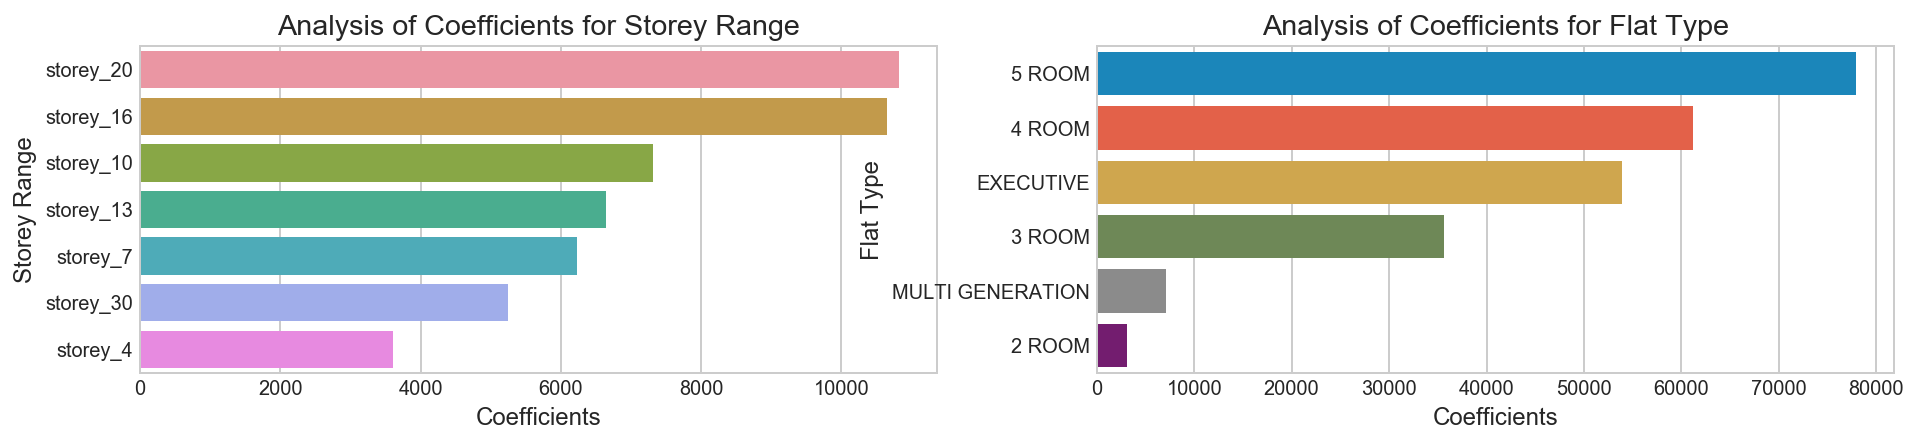

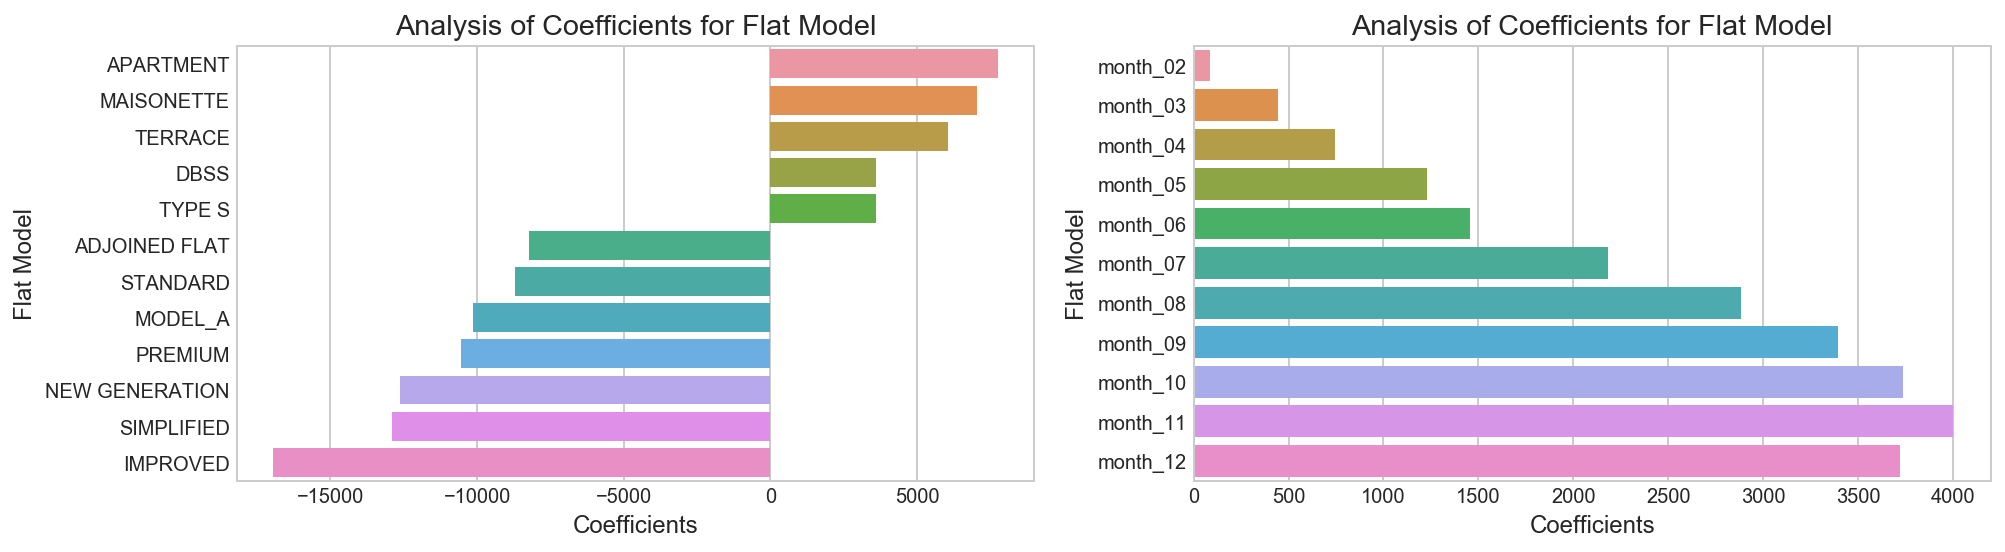

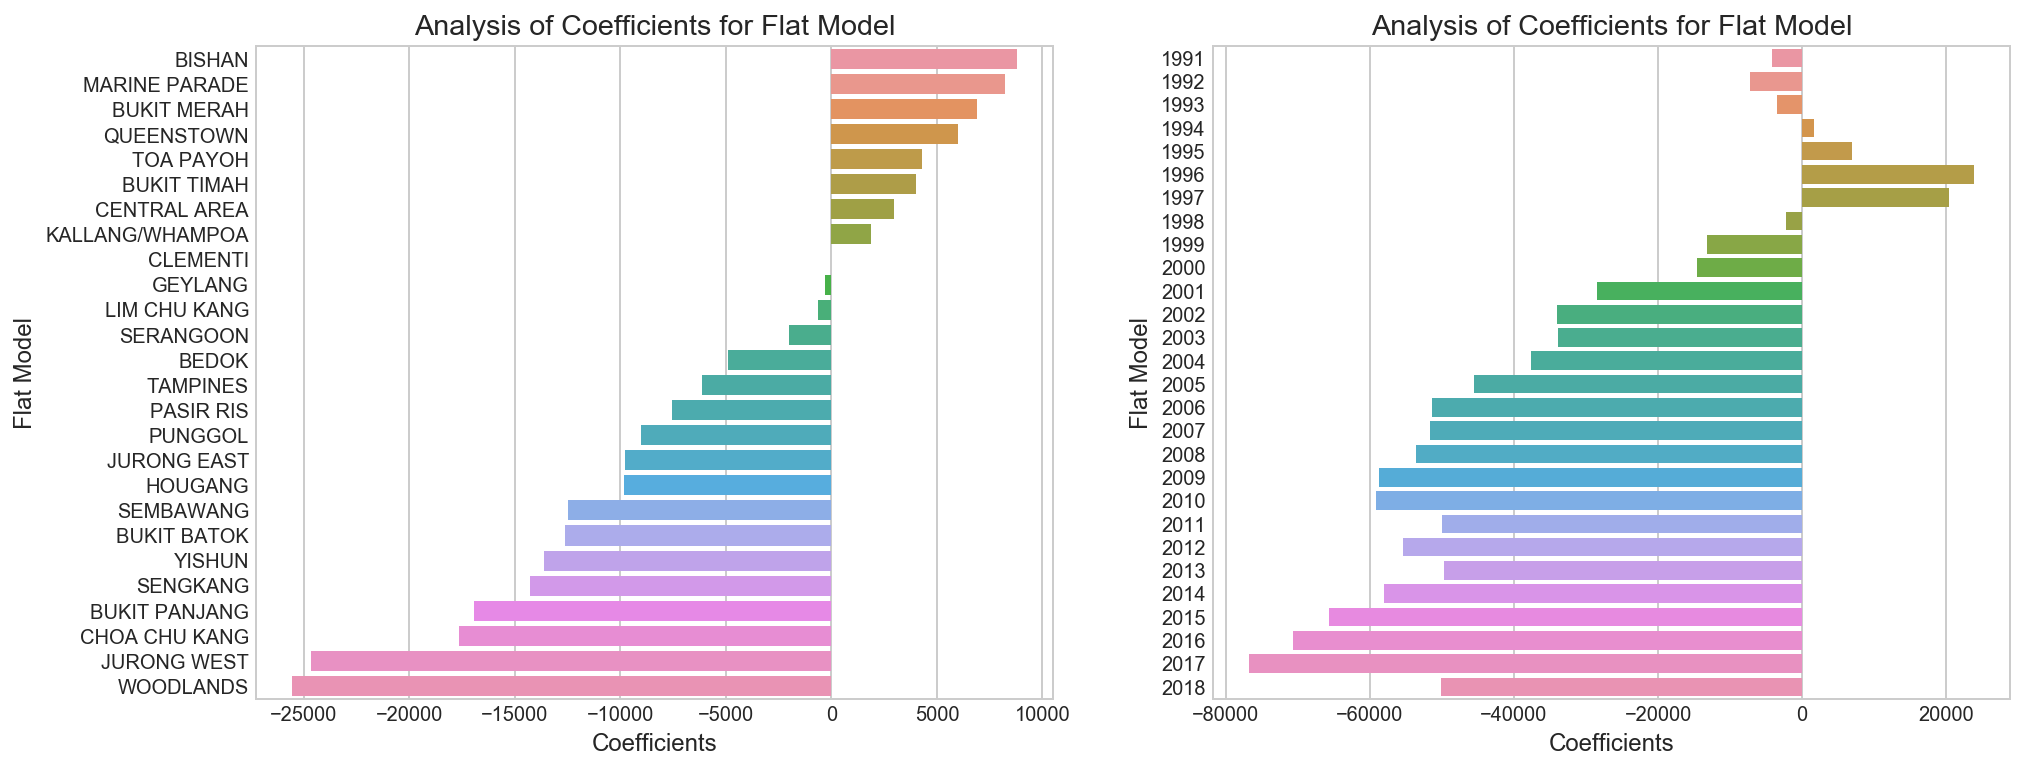

In [551]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter2_basic linreg',summary_model,summary)
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='2_regularization'></a>
#### Iteration 2: ridge, lasso,enet

Mean of scores: 0.881519485559 | Std of scores: 0.00141536421733
Test score: 0.881432541551
95 out of 95 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
94  91214.727862  91214.727862         lease_commence_date
15  77771.170315  77771.170315            flat_type_5 ROOM
92  69569.748828 -69569.748828  calculated_remaining_lease
14  60969.663954  60969.663954            flat_type_4 ROOM
93  59225.876490  59225.876490              floor_area_sqm
16  53817.508213  53817.508213         flat_type_EXECUTIVE
30  48136.639787  48136.639787                   year_1996
31  47669.868101  47669.868101                   year_1997
32  36341.768768  36341.768768                   year_1998
13  35429.646589  35429.646589            flat_type_3 ROOM


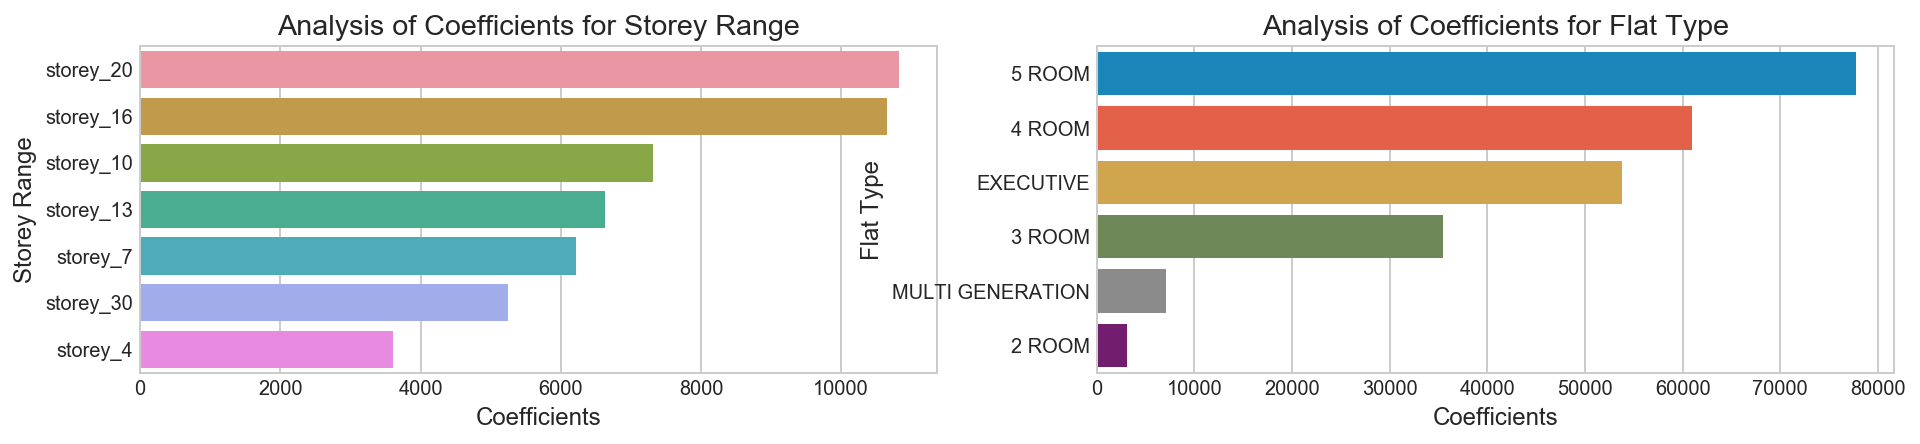

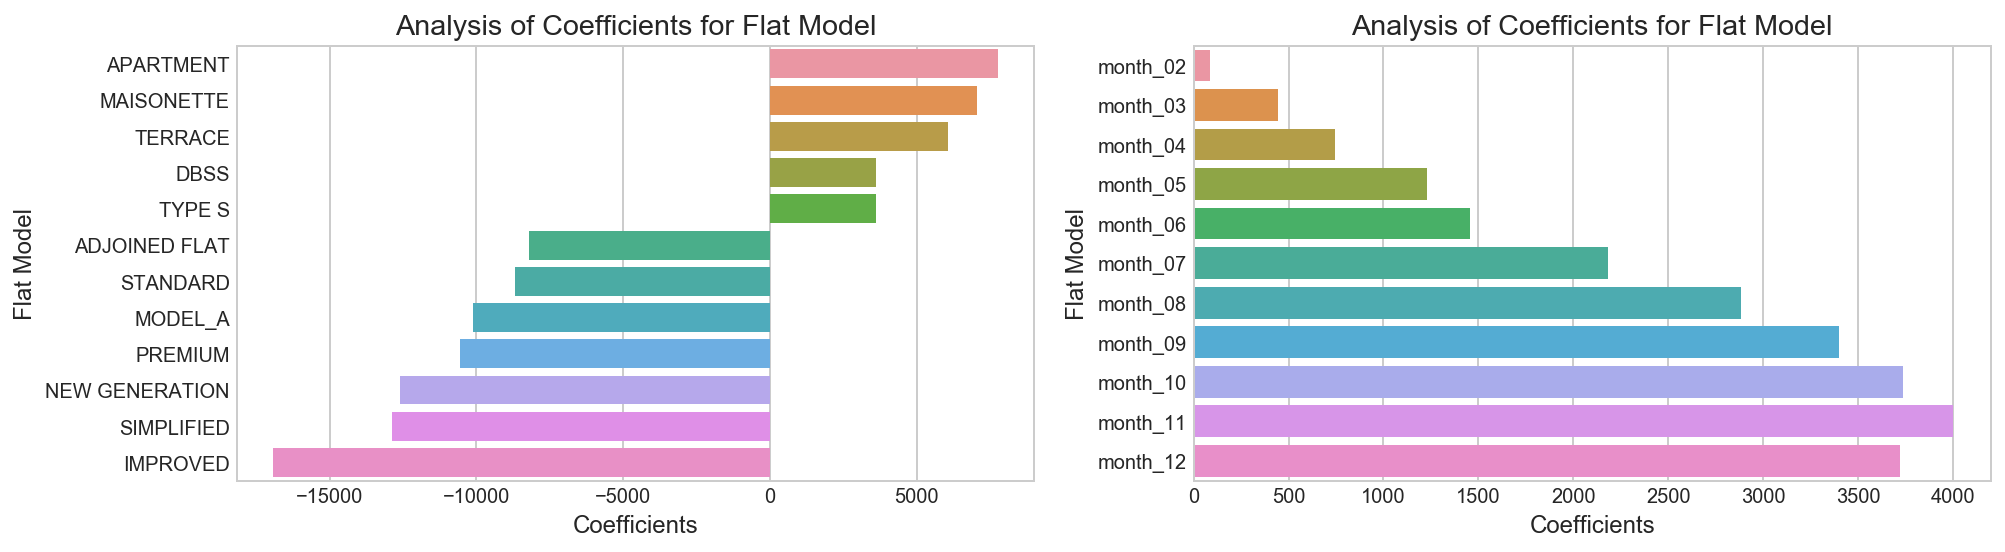

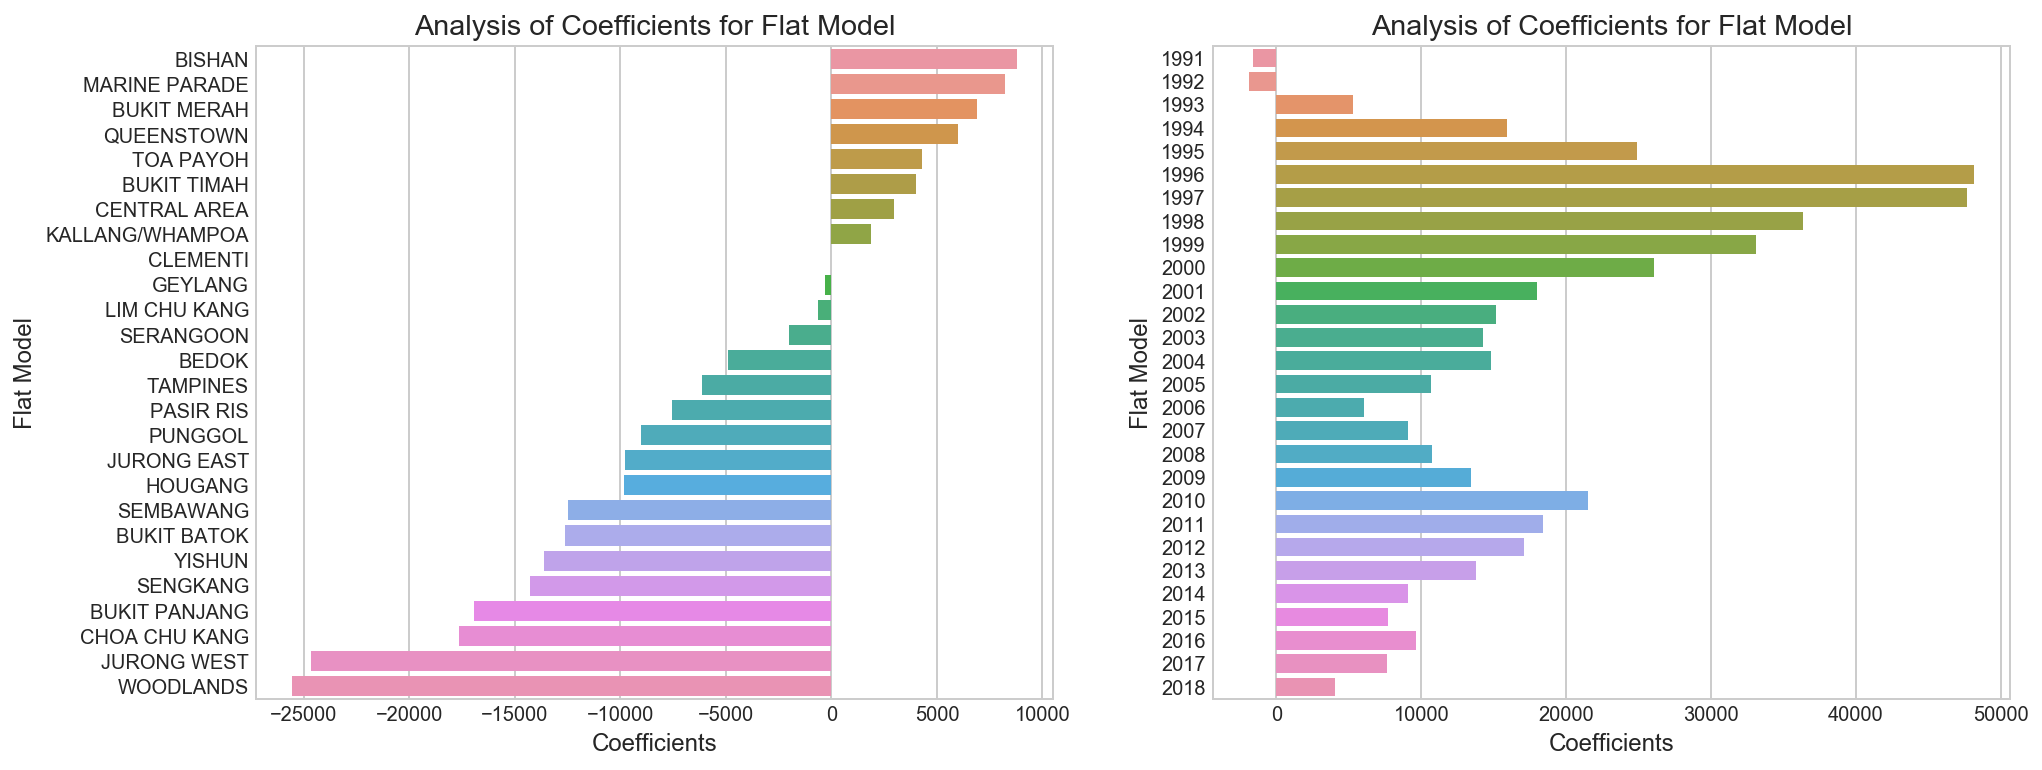

In [552]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter2_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.880748760464 | Std of scores: 0.0014147437331
Test score: 0.880648456741
89 out of 95 features are selected.
Coefficients not used: []
         abs_coef           coef                    variable
94  113097.426648  113097.426648         lease_commence_date
92   91827.715323  -91827.715323  calculated_remaining_lease
93   67463.347643   67463.347643              floor_area_sqm
30   41736.782695   41736.782695                   year_1996
31   41014.755550   41014.755550                   year_1997
15   39936.848201   39936.848201            flat_type_5 ROOM
16   32311.629564   32311.629564         flat_type_EXECUTIVE
32   27575.289141   27575.289141                   year_1998
33   23060.882626   23060.882626                   year_1999
88   22732.027575  -22732.027575              town_WOODLANDS


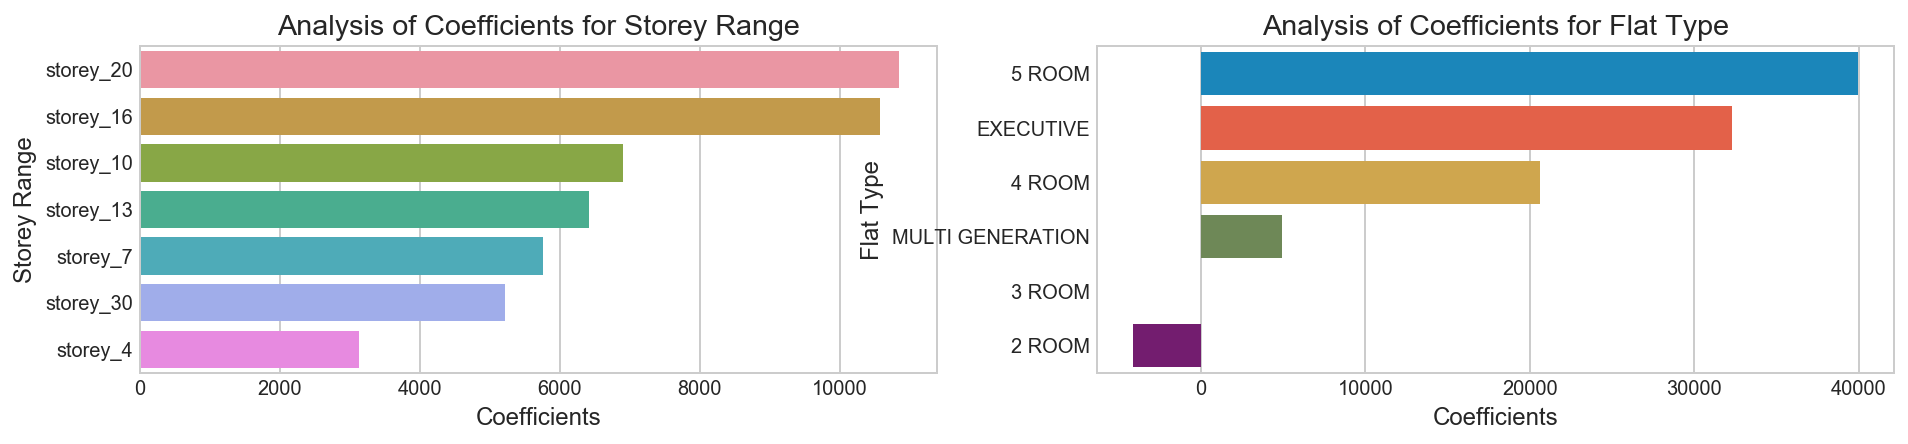

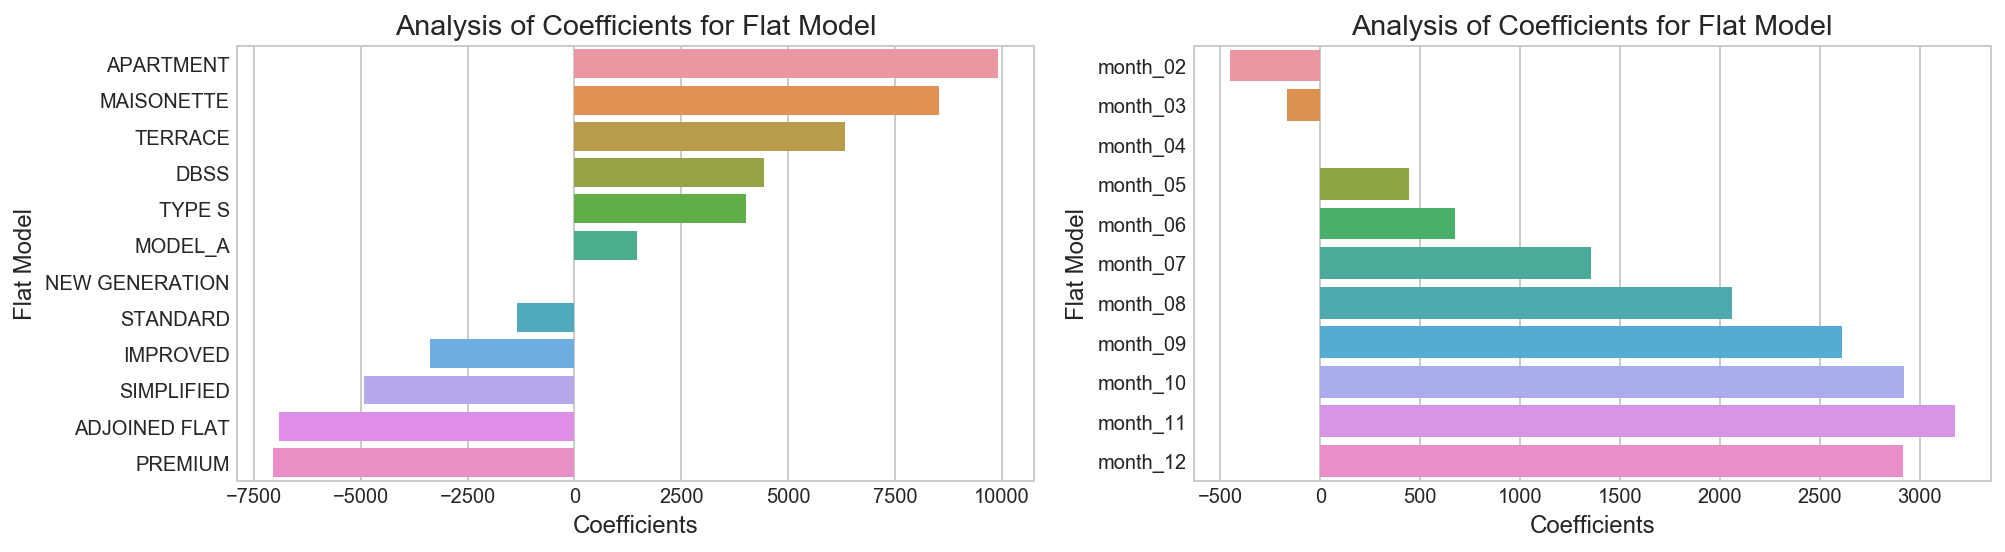

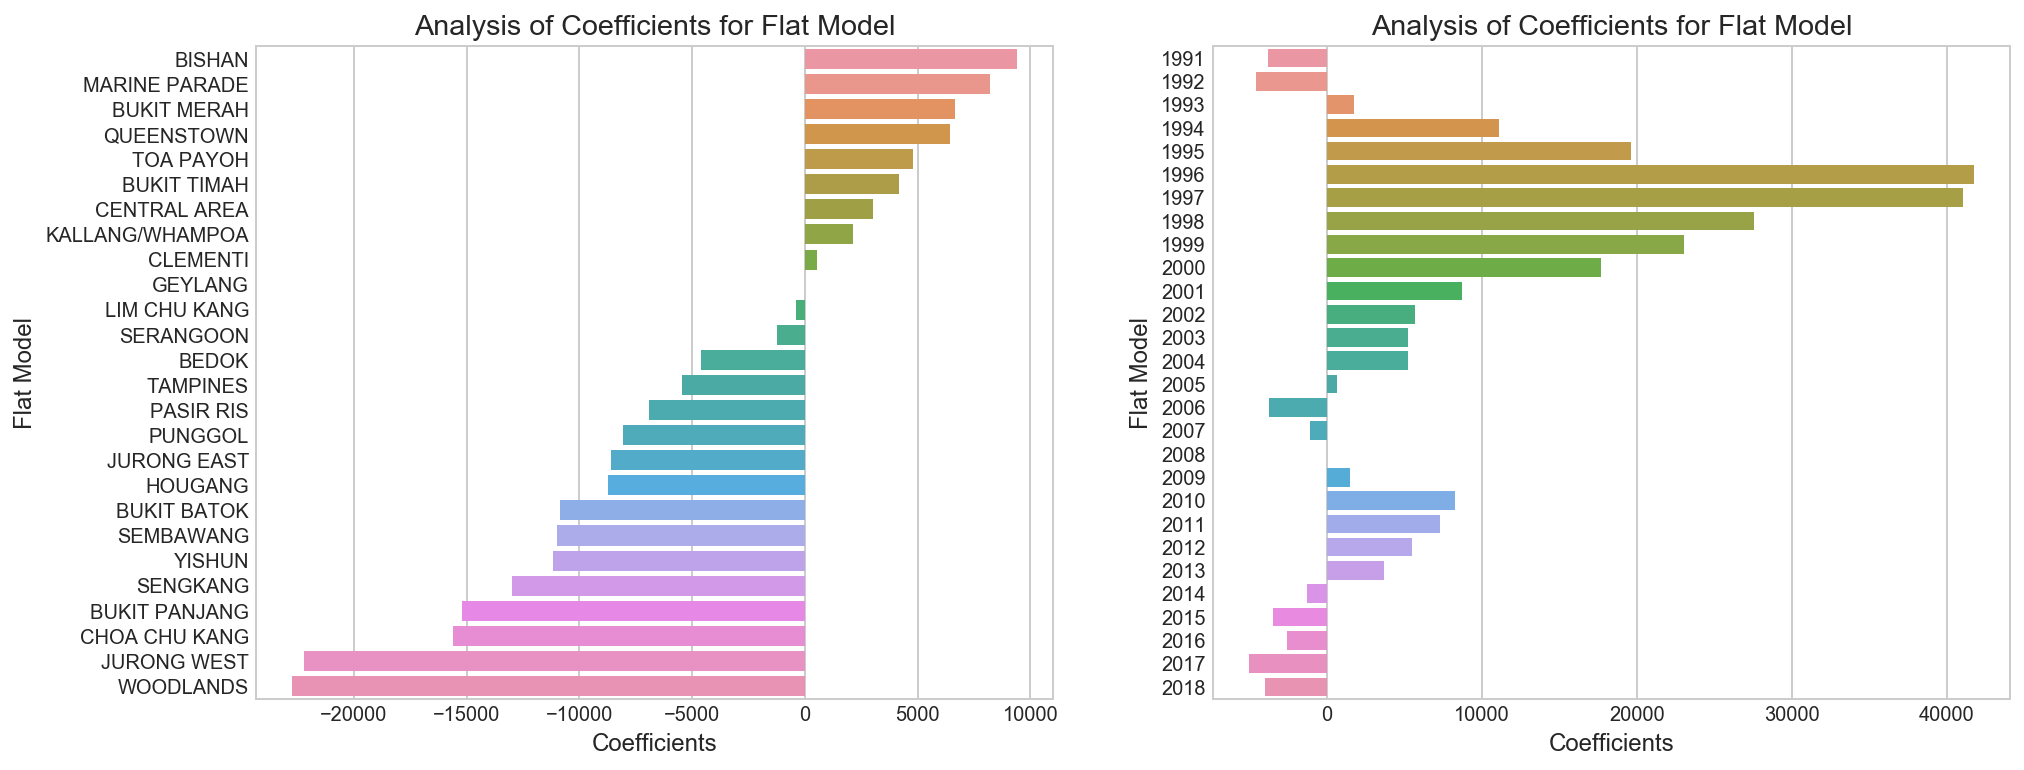

In [553]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter2_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.880748760464 | Std of scores: 0.0014147437331
Test score: 0.880648456741
89 out of 95 features are selected.
Coefficients not used: []
         abs_coef           coef                    variable
94  113097.426648  113097.426648         lease_commence_date
92   91827.715323  -91827.715323  calculated_remaining_lease
93   67463.347643   67463.347643              floor_area_sqm
30   41736.782695   41736.782695                   year_1996
31   41014.755550   41014.755550                   year_1997
15   39936.848201   39936.848201            flat_type_5 ROOM
16   32311.629564   32311.629564         flat_type_EXECUTIVE
32   27575.289141   27575.289141                   year_1998
33   23060.882626   23060.882626                   year_1999
88   22732.027575  -22732.027575              town_WOODLANDS


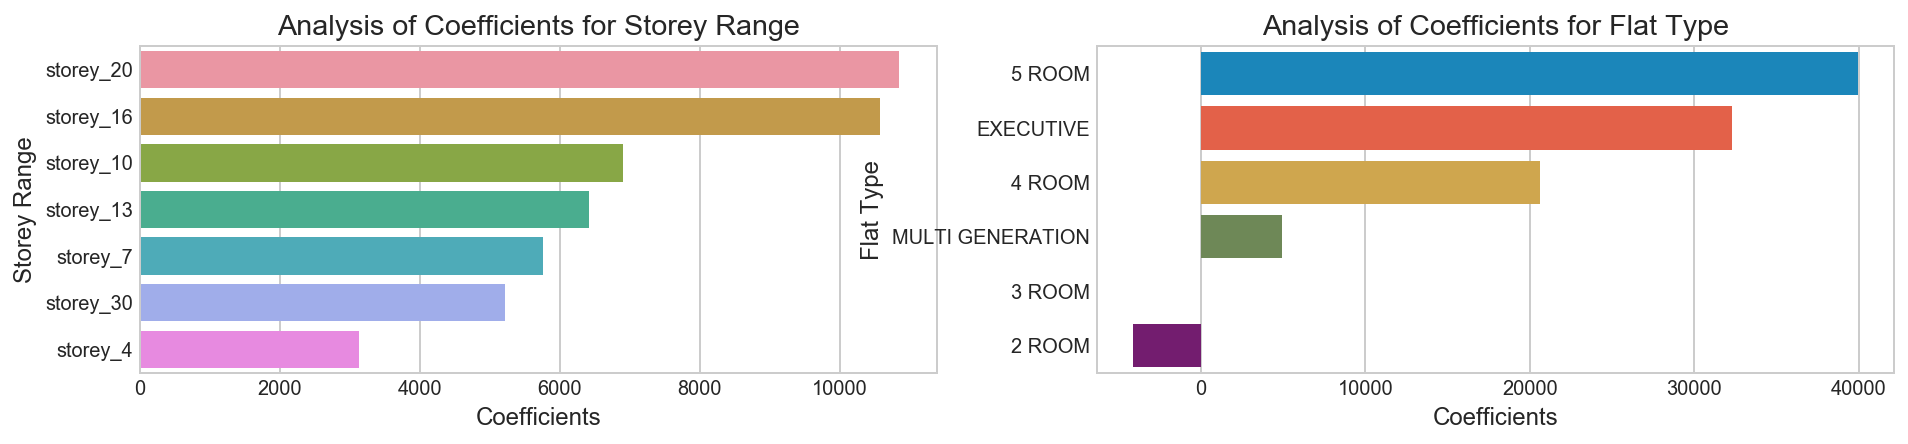

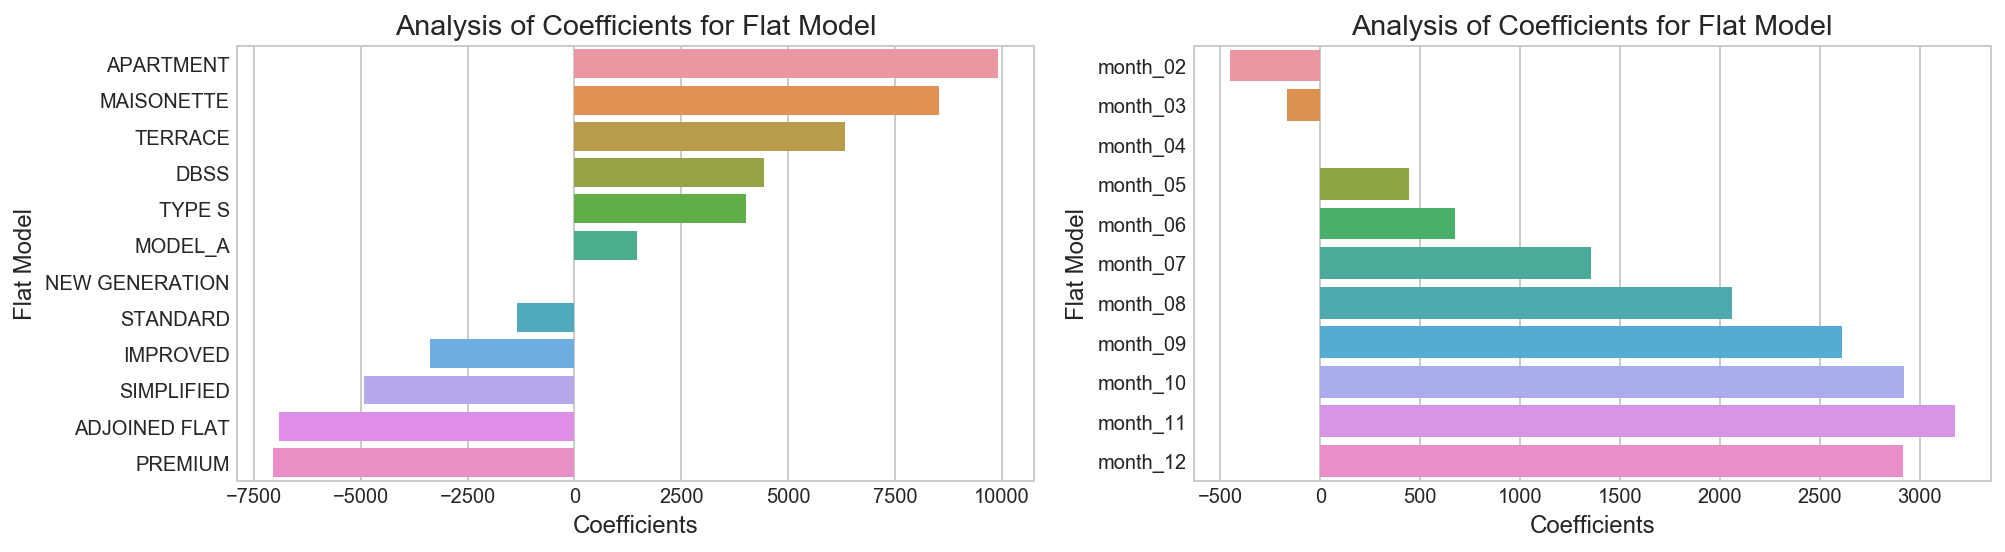

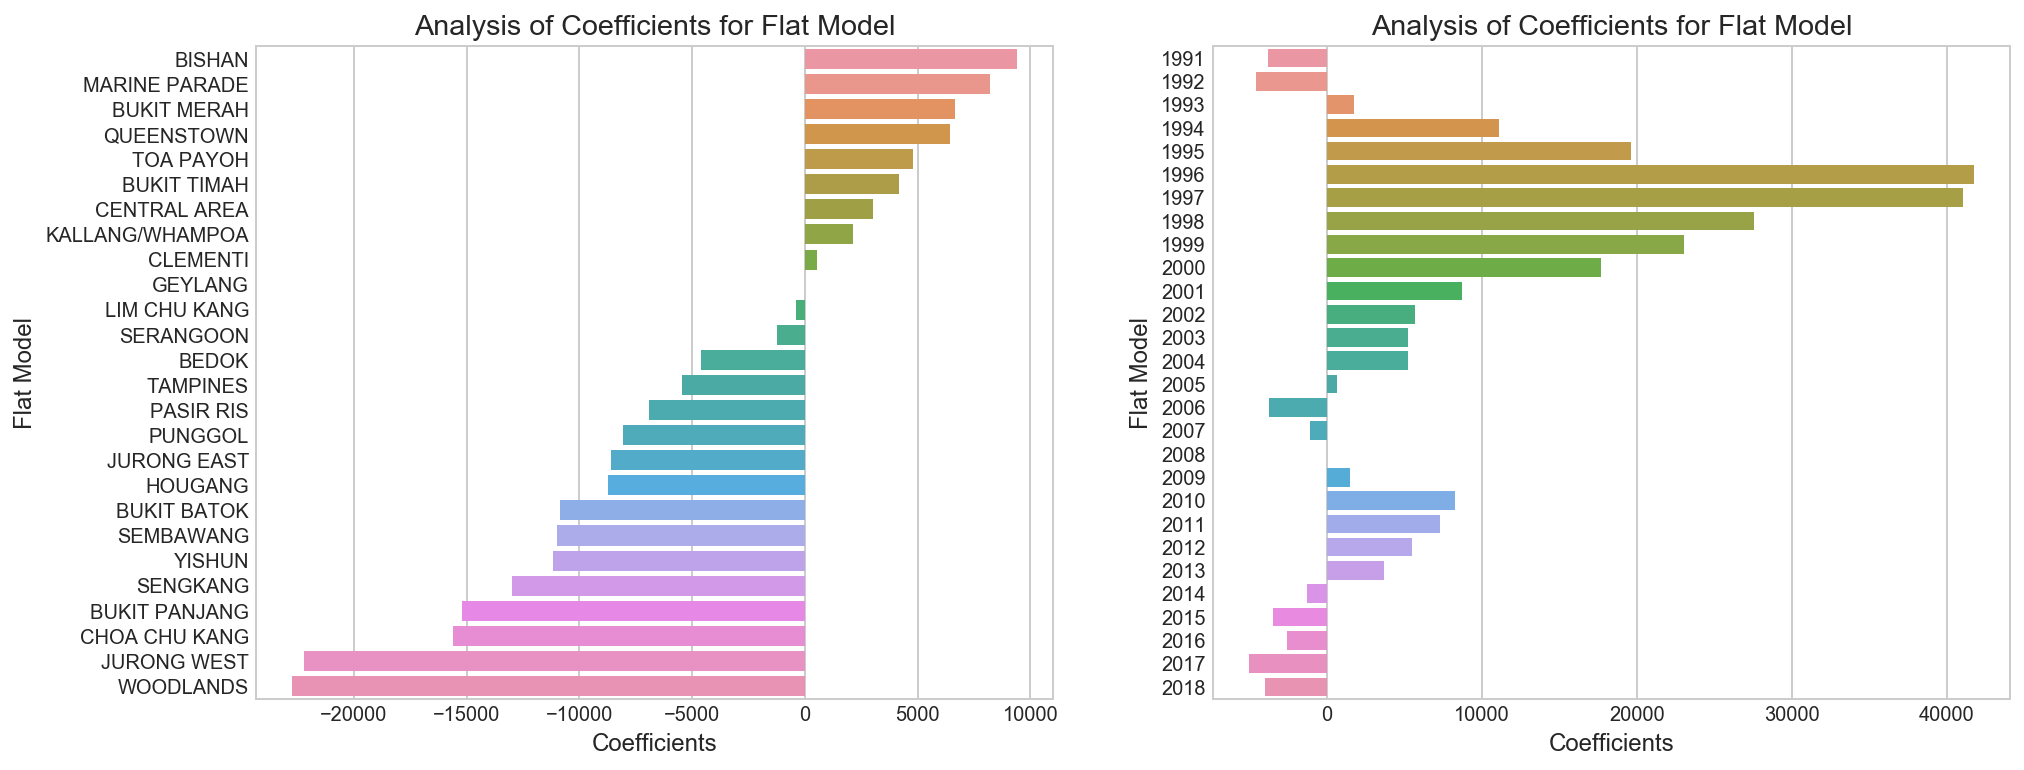

In [554]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter2_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

In [555]:
summary

model train_mean_score train_std_score test_score
0  iter1_basic linreg         0.912605      0.00103202   0.912679
0   iter1_basic ridge         0.912607      0.00103117   0.912678
0   iter1_basic lasso         0.912251      0.00103463   0.912325
0    iter1_basic enet         0.912251      0.00103463   0.912325
0  iter2_basic linreg         0.881517       0.0014095   0.881433
0   iter2_basic ridge         0.881519      0.00141536   0.881433
0   iter2_basic lasso         0.880749      0.00141474   0.880648
0    iter2_basic enet         0.880749      0.00141474   0.880648

<a id='iter3a'></a>
### Iteration 3a

In [556]:
X = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col]],df4,df5],axis=1)
ss = StandardScaler()
y = resale['adj_price']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.25, 
                                                    random_state=42)

<a id='3amlrall'></a>
#### Iteration 3a: Multiple variable Linear regression: ALL 

Mean of scores: 0.758121632317 | Std of scores: 0.00204435476955
Test score: 0.758708773231
67 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
15  73230.392627  73230.392627            flat_type_5 ROOM
66  69216.507316  69216.507316         lease_commence_date
65  64239.312611  64239.312611              floor_area_sqm
14  56384.482877  56384.482877            flat_type_4 ROOM
16  50917.145655  50917.145655         flat_type_EXECUTIVE
64  50594.256752 -50594.256752  calculated_remaining_lease
13  31648.531451  31648.531451            flat_type_3 ROOM
60  25081.957983 -25081.957983              town_WOODLANDS
48  22823.810887 -22823.810887            town_JURONG WEST
1   18849.072208 -18849.072208         flat_model_IMPROVED


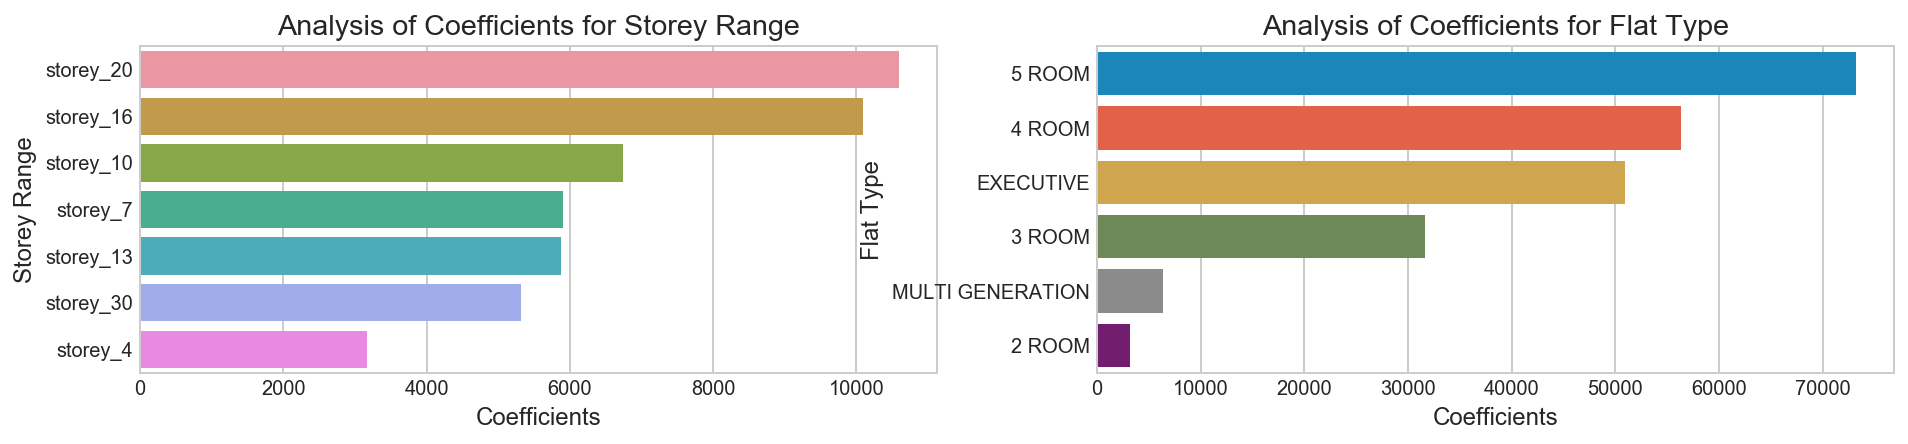

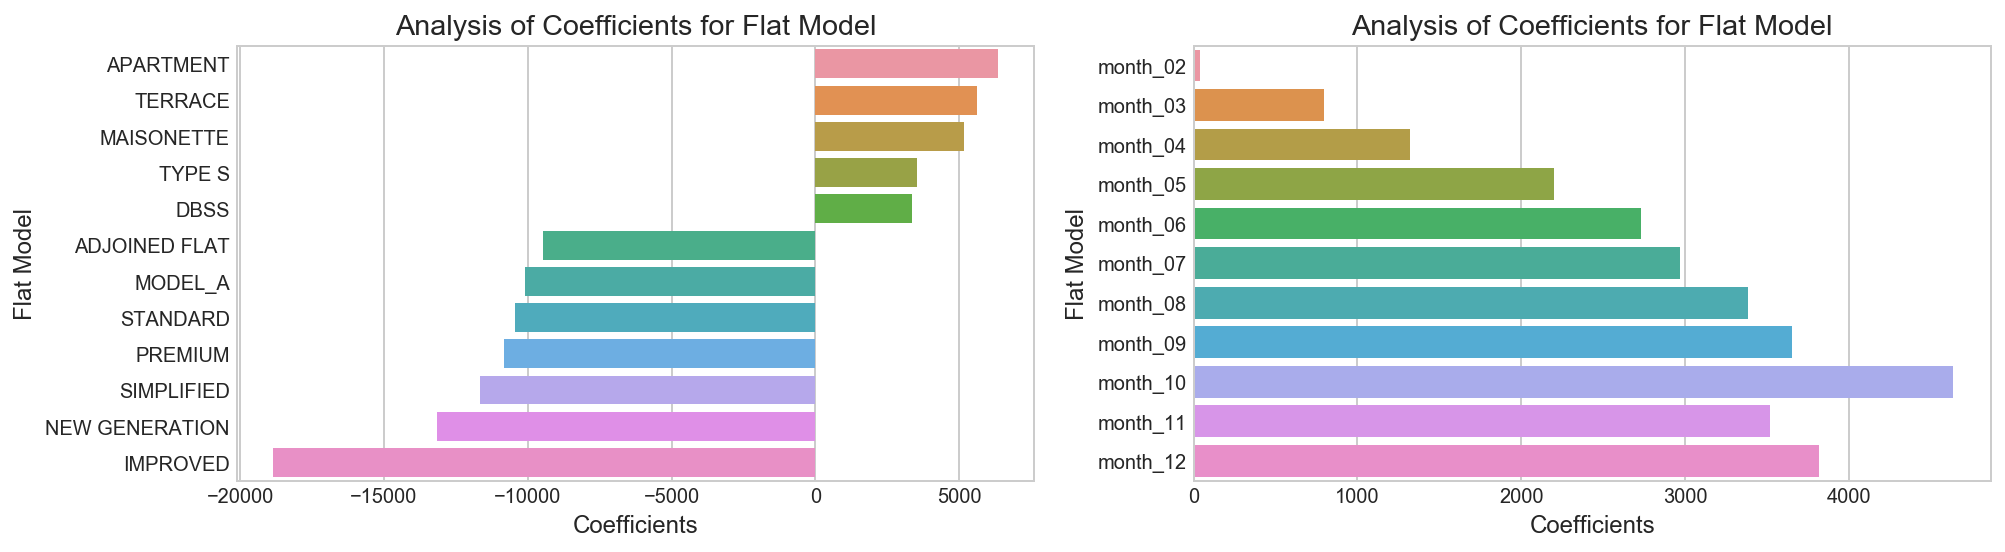

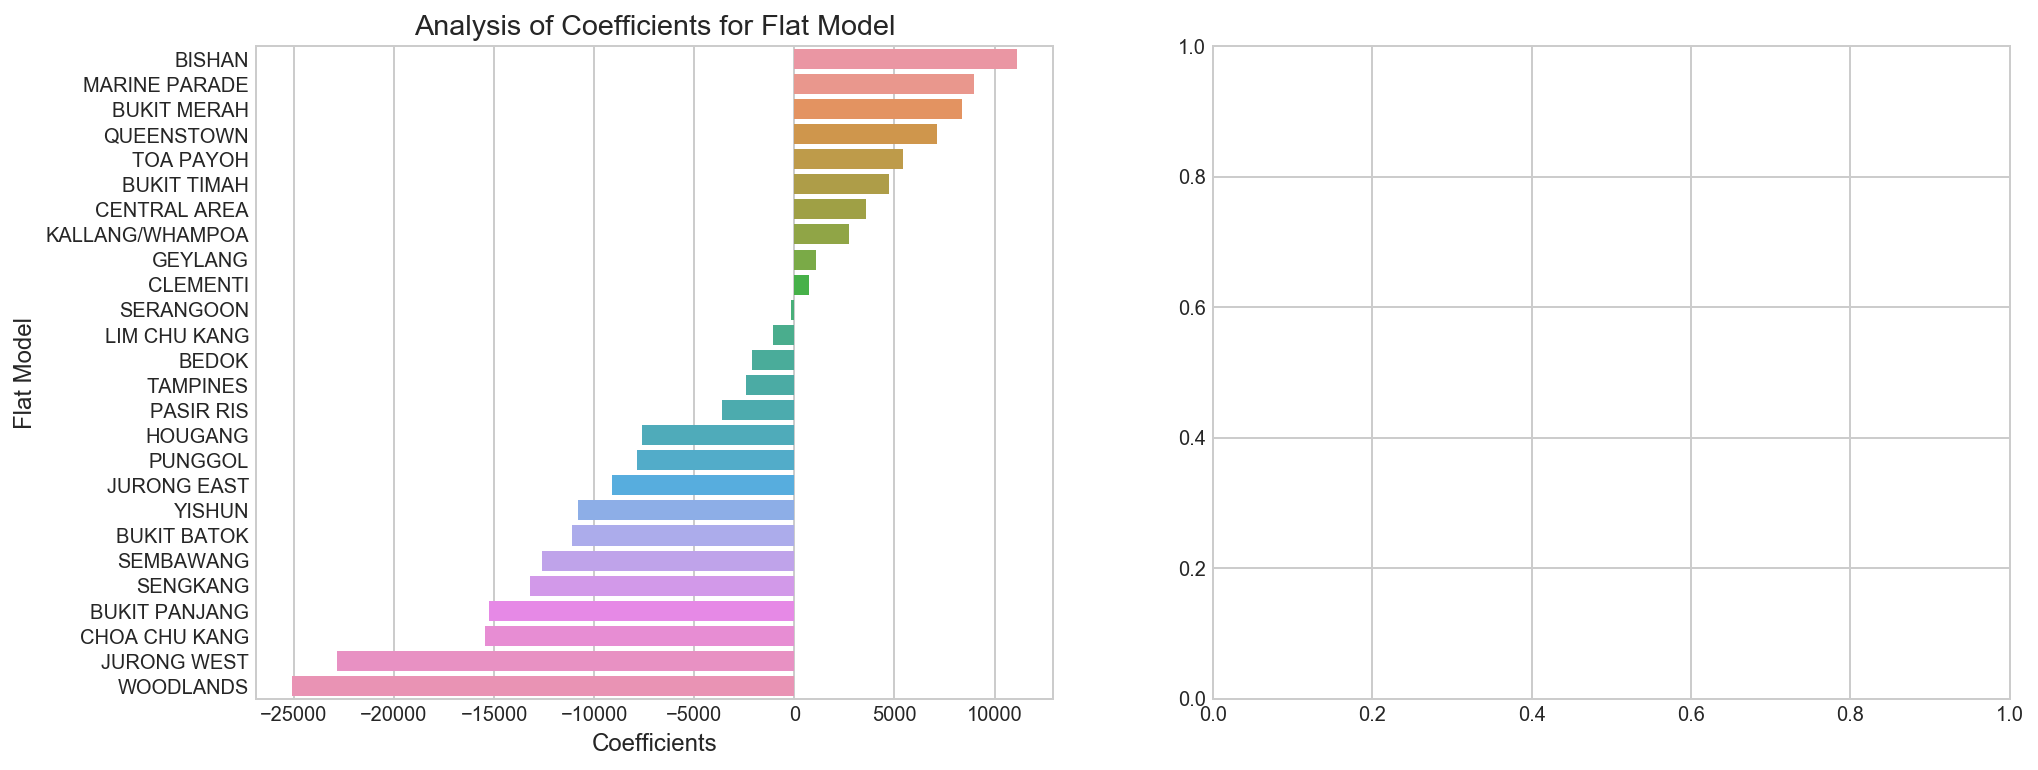

In [557]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic linreg',summary_model,summary)
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='3aregularization'></a>
#### Iteration 3a: Ridge, Lasso, enet 

Mean of scores: 0.758121664126 | Std of scores: 0.00204410899048
Test score: 0.758708787817
67 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
15  73087.643553  73087.643553            flat_type_5 ROOM
66  69218.334253  69218.334253         lease_commence_date
65  64260.618674  64260.618674              floor_area_sqm
14  56225.827716  56225.827716            flat_type_4 ROOM
16  50824.675968  50824.675968         flat_type_EXECUTIVE
64  50593.659951 -50593.659951  calculated_remaining_lease
13  31503.934835  31503.934835            flat_type_3 ROOM
60  25079.330186 -25079.330186              town_WOODLANDS
48  22820.441512 -22820.441512            town_JURONG WEST
1   18818.228379 -18818.228379         flat_model_IMPROVED


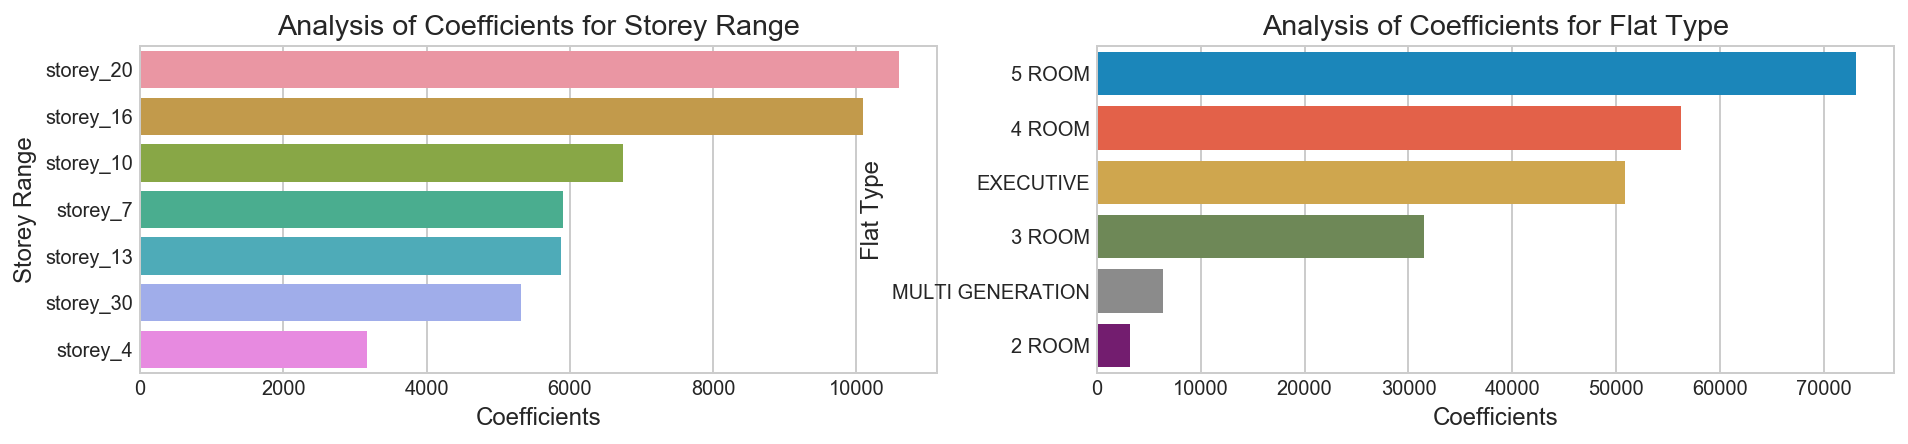

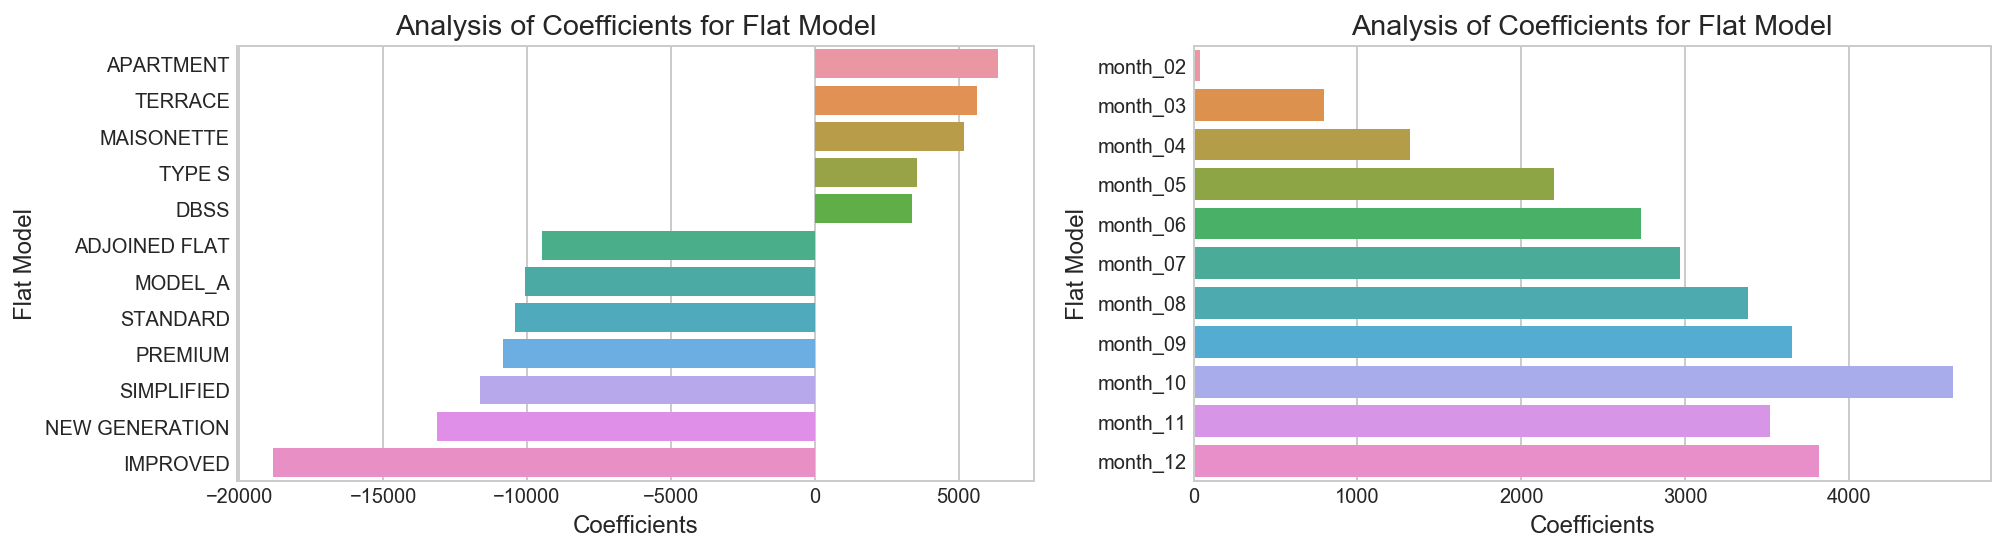

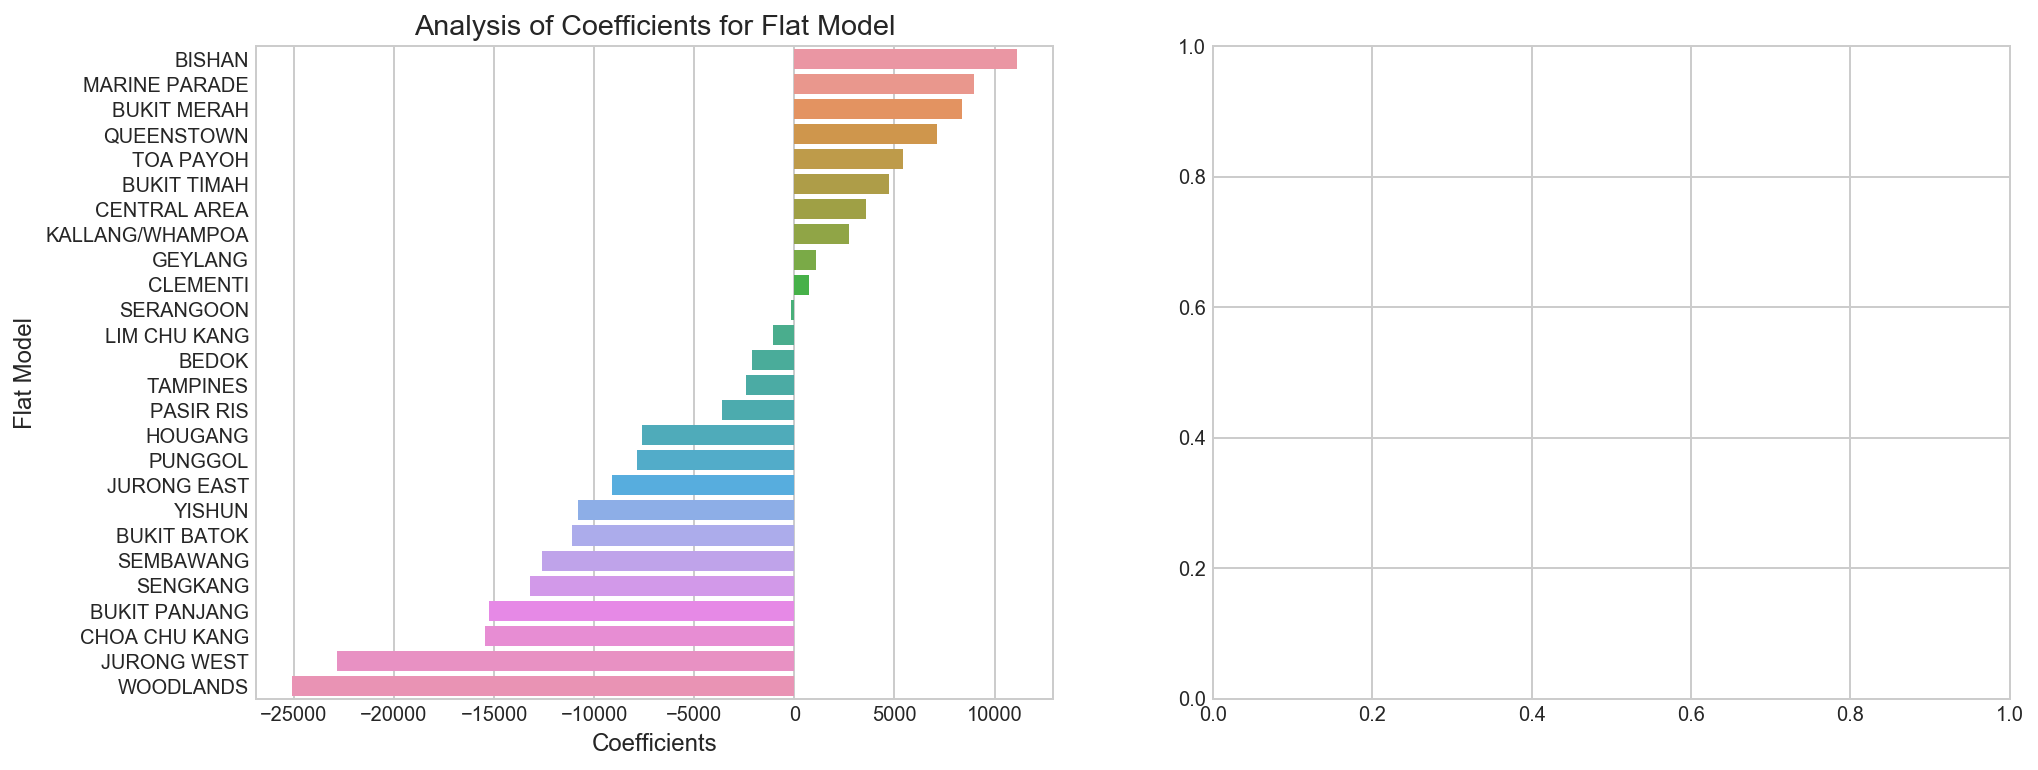

In [558]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.757609349156 | Std of scores: 0.00199710348315
Test score: 0.758223602765
62 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
65  71852.067203  71852.067203              floor_area_sqm
66  69599.389721  69599.389721         lease_commence_date
64  50310.174744 -50310.174744  calculated_remaining_lease
15  39007.929049  39007.929049            flat_type_5 ROOM
16  31974.686563  31974.686563         flat_type_EXECUTIVE
60  22171.082218 -22171.082218              town_WOODLANDS
48  20259.172897 -20259.172897            town_JURONG WEST
14  20160.813433  20160.813433            flat_type_4 ROOM
40  13602.680320 -13602.680320          town_BUKIT PANJANG
43  13343.013731 -13343.013731          town_CHOA CHU KANG


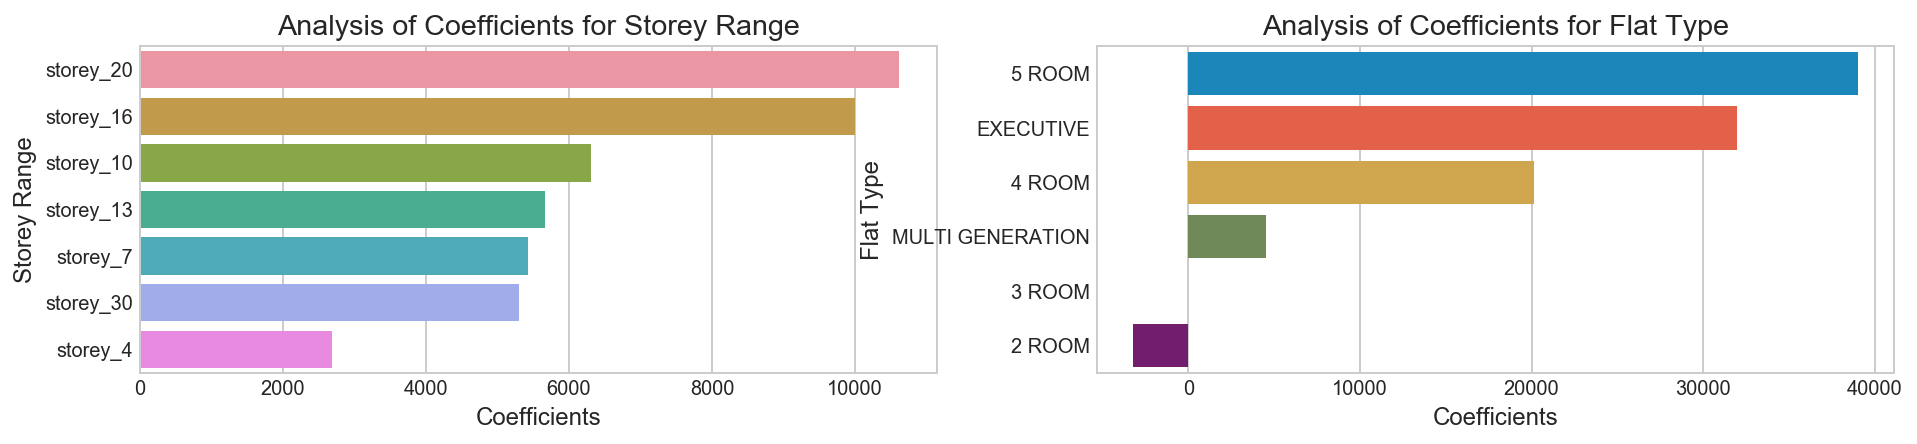

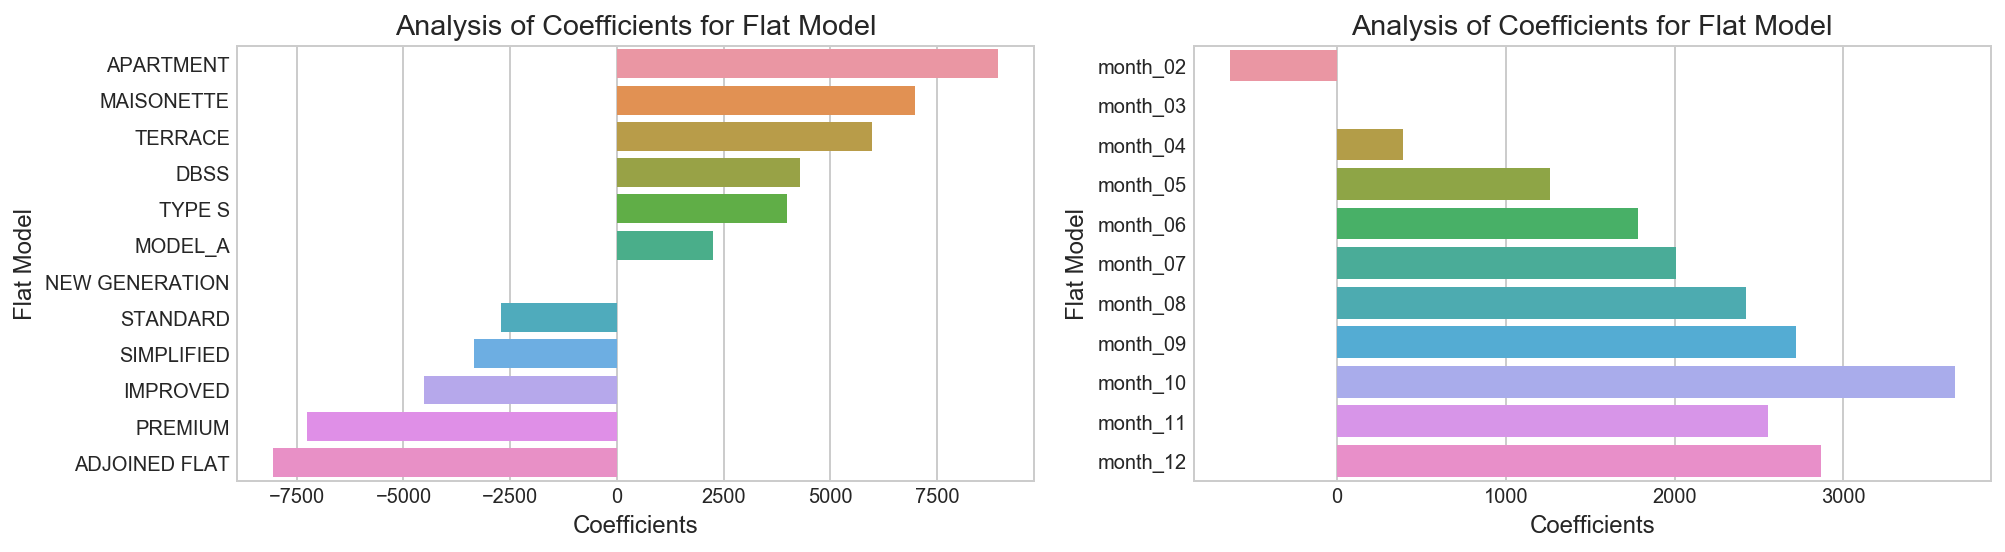

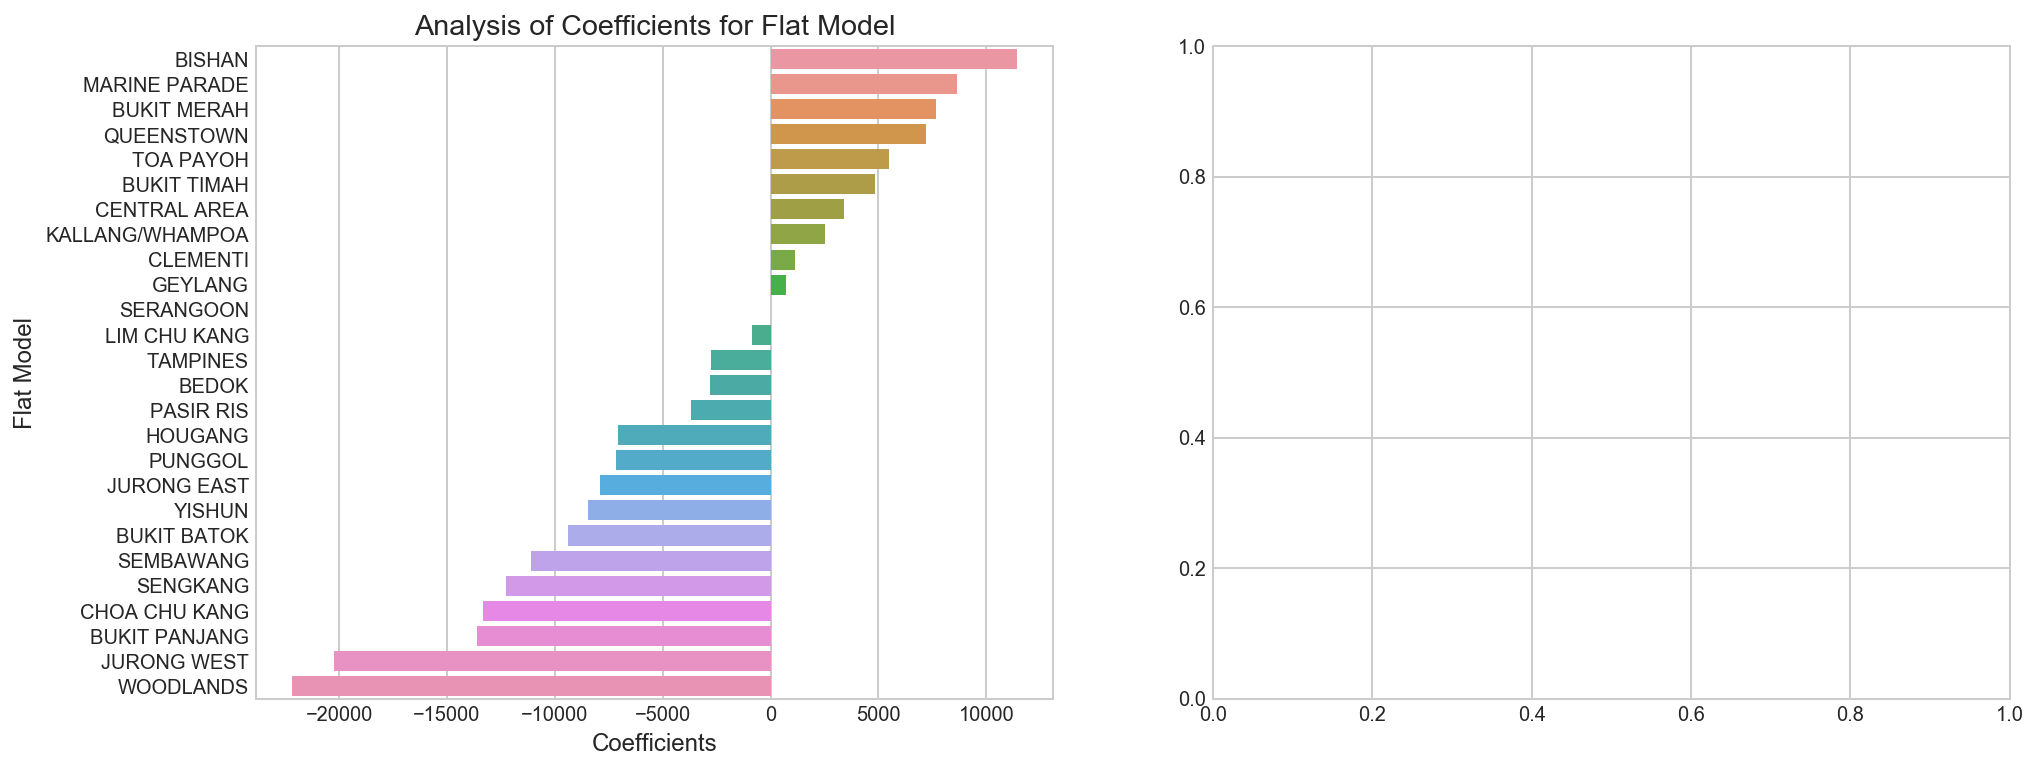

In [559]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.757609349156 | Std of scores: 0.00199710348315
Test score: 0.758223602765
62 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
65  71852.067203  71852.067203              floor_area_sqm
66  69599.389721  69599.389721         lease_commence_date
64  50310.174744 -50310.174744  calculated_remaining_lease
15  39007.929049  39007.929049            flat_type_5 ROOM
16  31974.686563  31974.686563         flat_type_EXECUTIVE
60  22171.082218 -22171.082218              town_WOODLANDS
48  20259.172897 -20259.172897            town_JURONG WEST
14  20160.813433  20160.813433            flat_type_4 ROOM
40  13602.680320 -13602.680320          town_BUKIT PANJANG
43  13343.013731 -13343.013731          town_CHOA CHU KANG


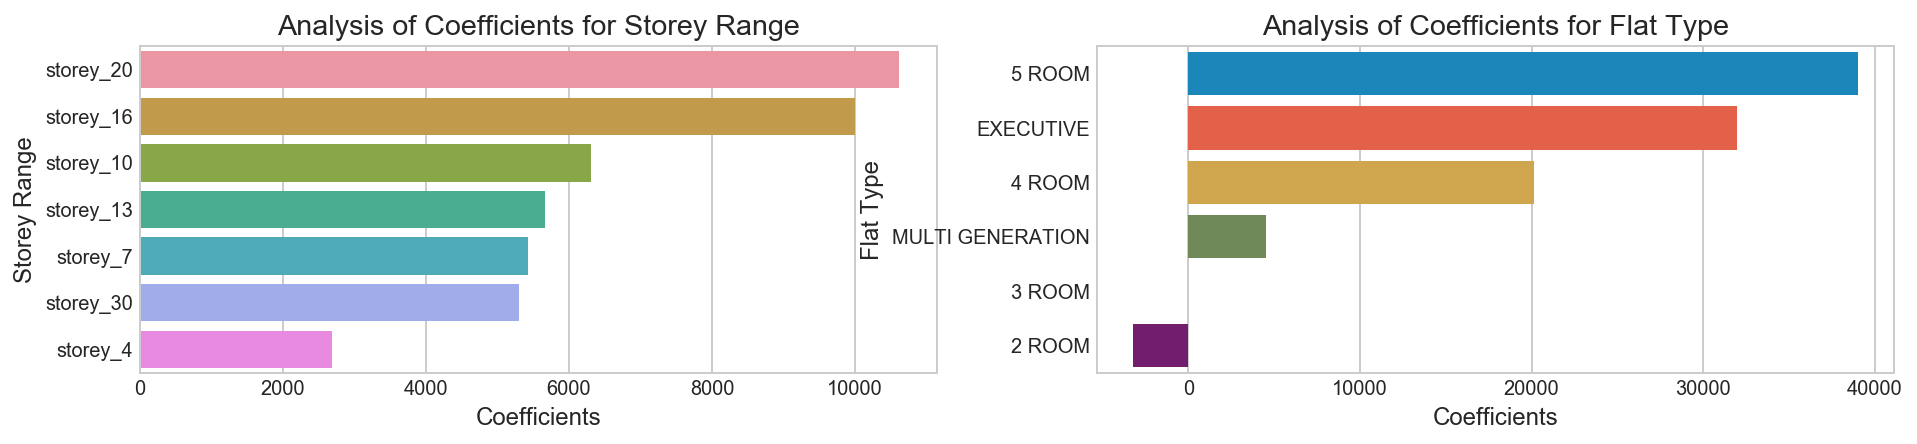

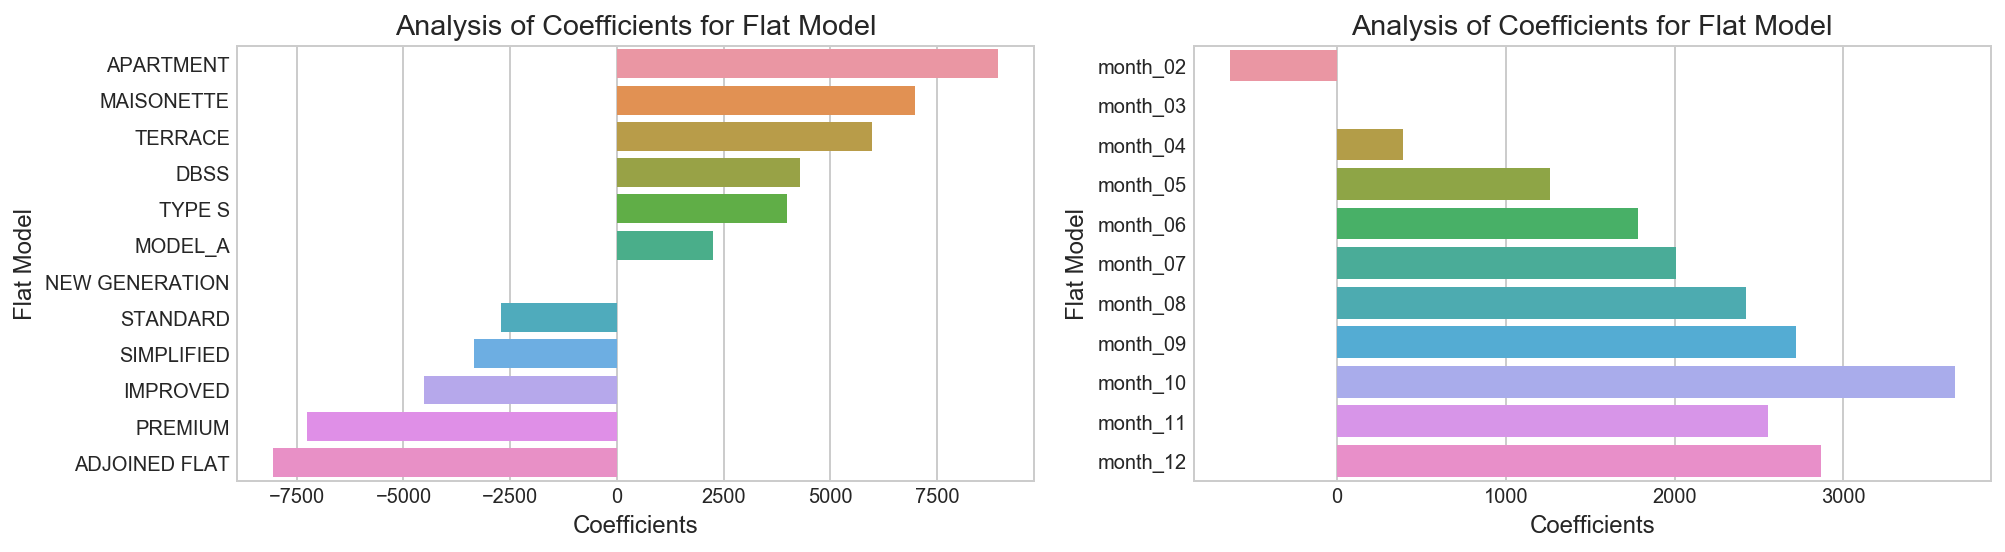

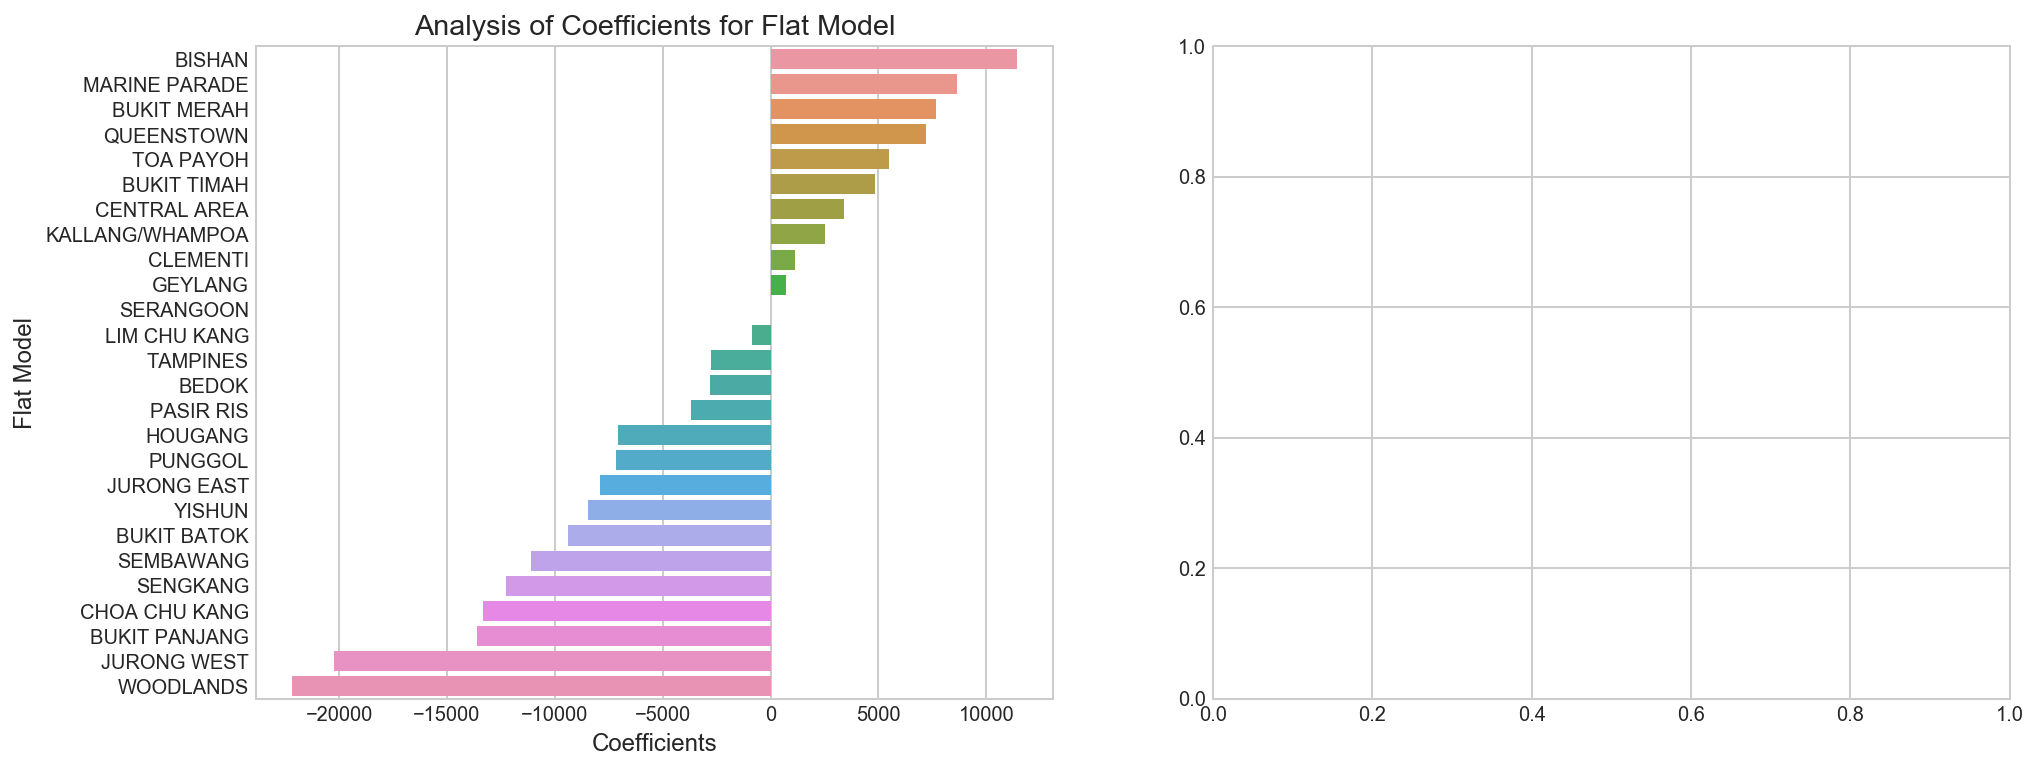

In [560]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

In [561]:
summary

model train_mean_score train_std_score test_score
0   iter1_basic linreg         0.912605      0.00103202   0.912679
0    iter1_basic ridge         0.912607      0.00103117   0.912678
0    iter1_basic lasso         0.912251      0.00103463   0.912325
0     iter1_basic enet         0.912251      0.00103463   0.912325
0   iter2_basic linreg         0.881517       0.0014095   0.881433
0    iter2_basic ridge         0.881519      0.00141536   0.881433
0    iter2_basic lasso         0.880749      0.00141474   0.880648
0     iter2_basic enet         0.880749      0.00141474   0.880648
0  iter3a_basic linreg         0.758122      0.00204435   0.758709
0   iter3a_basic ridge         0.758122      0.00204411   0.758709
0   iter3a_basic lasso         0.757609       0.0019971   0.758224
0    iter3a_basic enet         0.757609       0.0019971   0.758224

<a id='iter3b'></a>
### Iteration 3b

In [566]:
X = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col and 'month' not in col]],df4,df5],axis=1)
ss = StandardScaler()
y = resale['adj_price']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.25, 
                                                    random_state=42)

<a id='3bmlrall'></a>
#### Iteration 3b: Multiple variable Linear regression: ALL 

Mean of scores: 0.75701372302 | Std of scores: 0.00220762245127
Test score: 0.757695107799
56 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
15  73049.630033  73049.630033            flat_type_5 ROOM
55  69077.450099  69077.450099         lease_commence_date
54  64255.362579  64255.362579              floor_area_sqm
14  56139.394398  56139.394398            flat_type_4 ROOM
16  50821.666045  50821.666045         flat_type_EXECUTIVE
53  50360.704733 -50360.704733  calculated_remaining_lease
13  31415.901569  31415.901569            flat_type_3 ROOM
49  25064.877373 -25064.877373              town_WOODLANDS
37  22877.726548 -22877.726548            town_JURONG WEST
1   18833.712161 -18833.712161         flat_model_IMPROVED


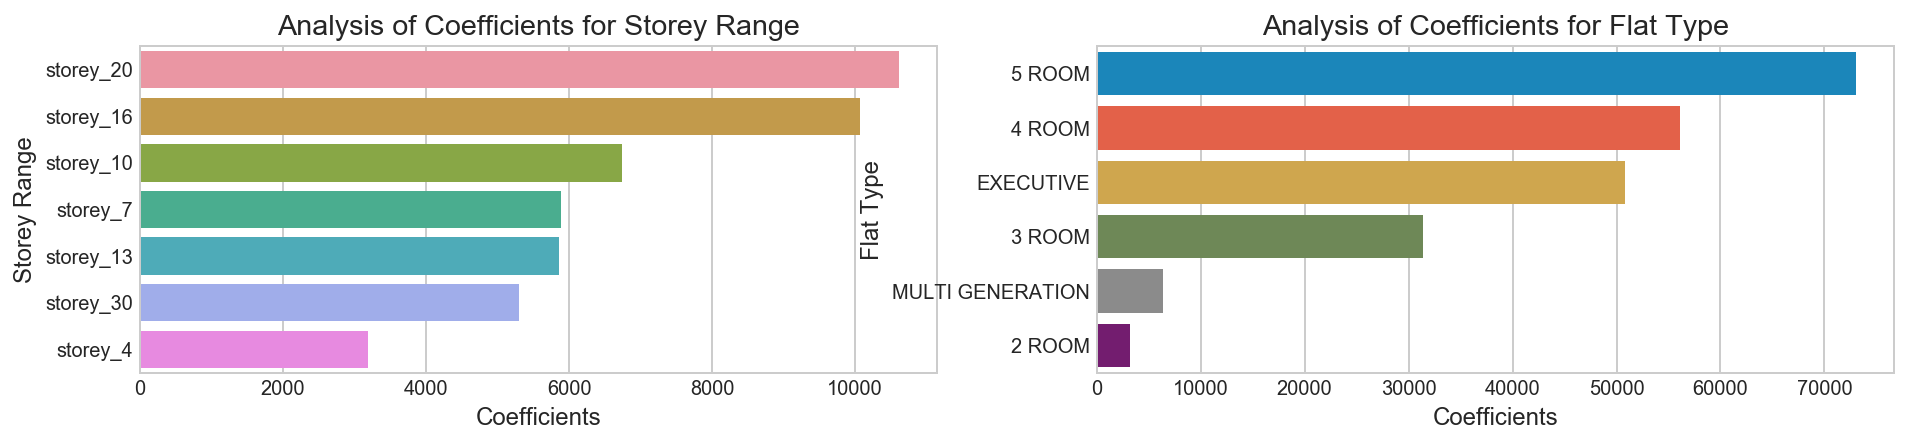

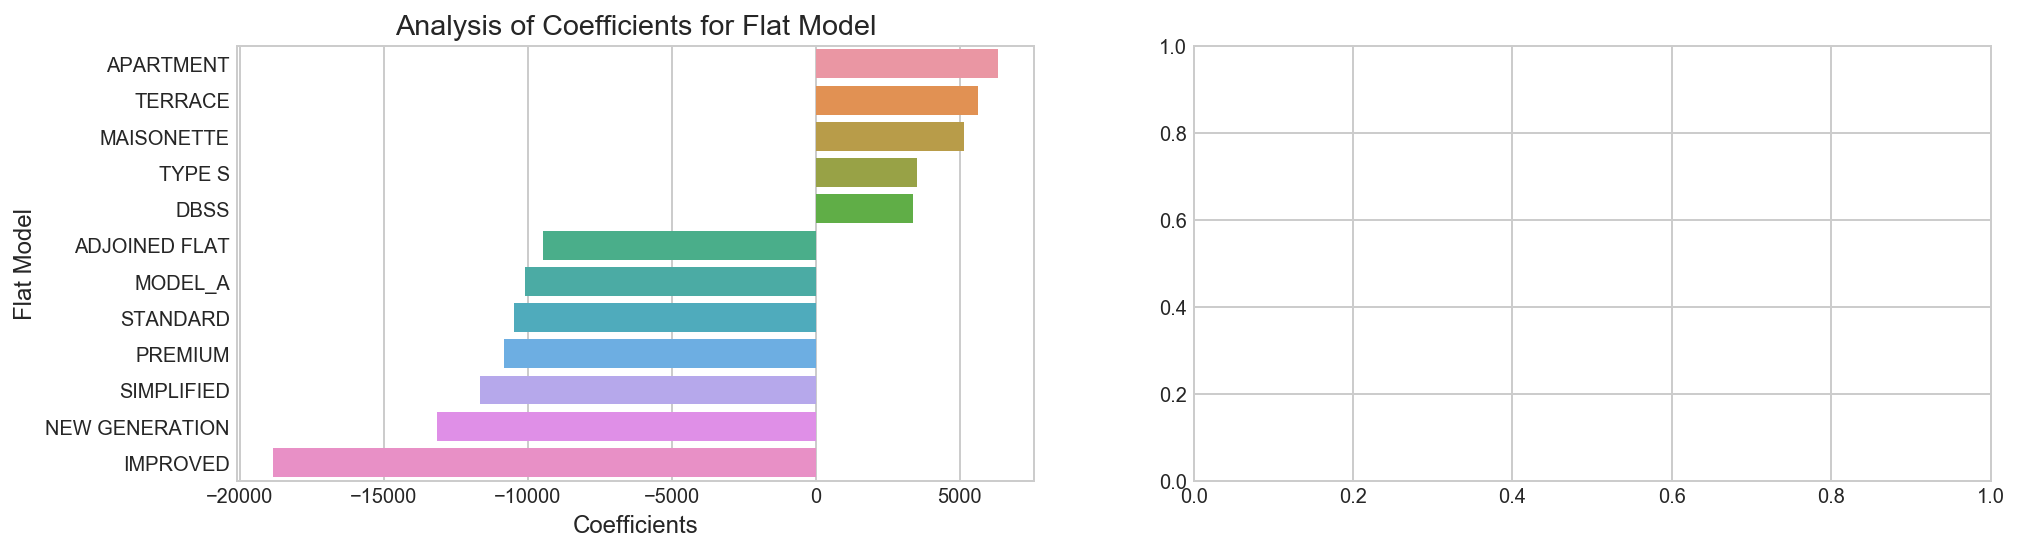

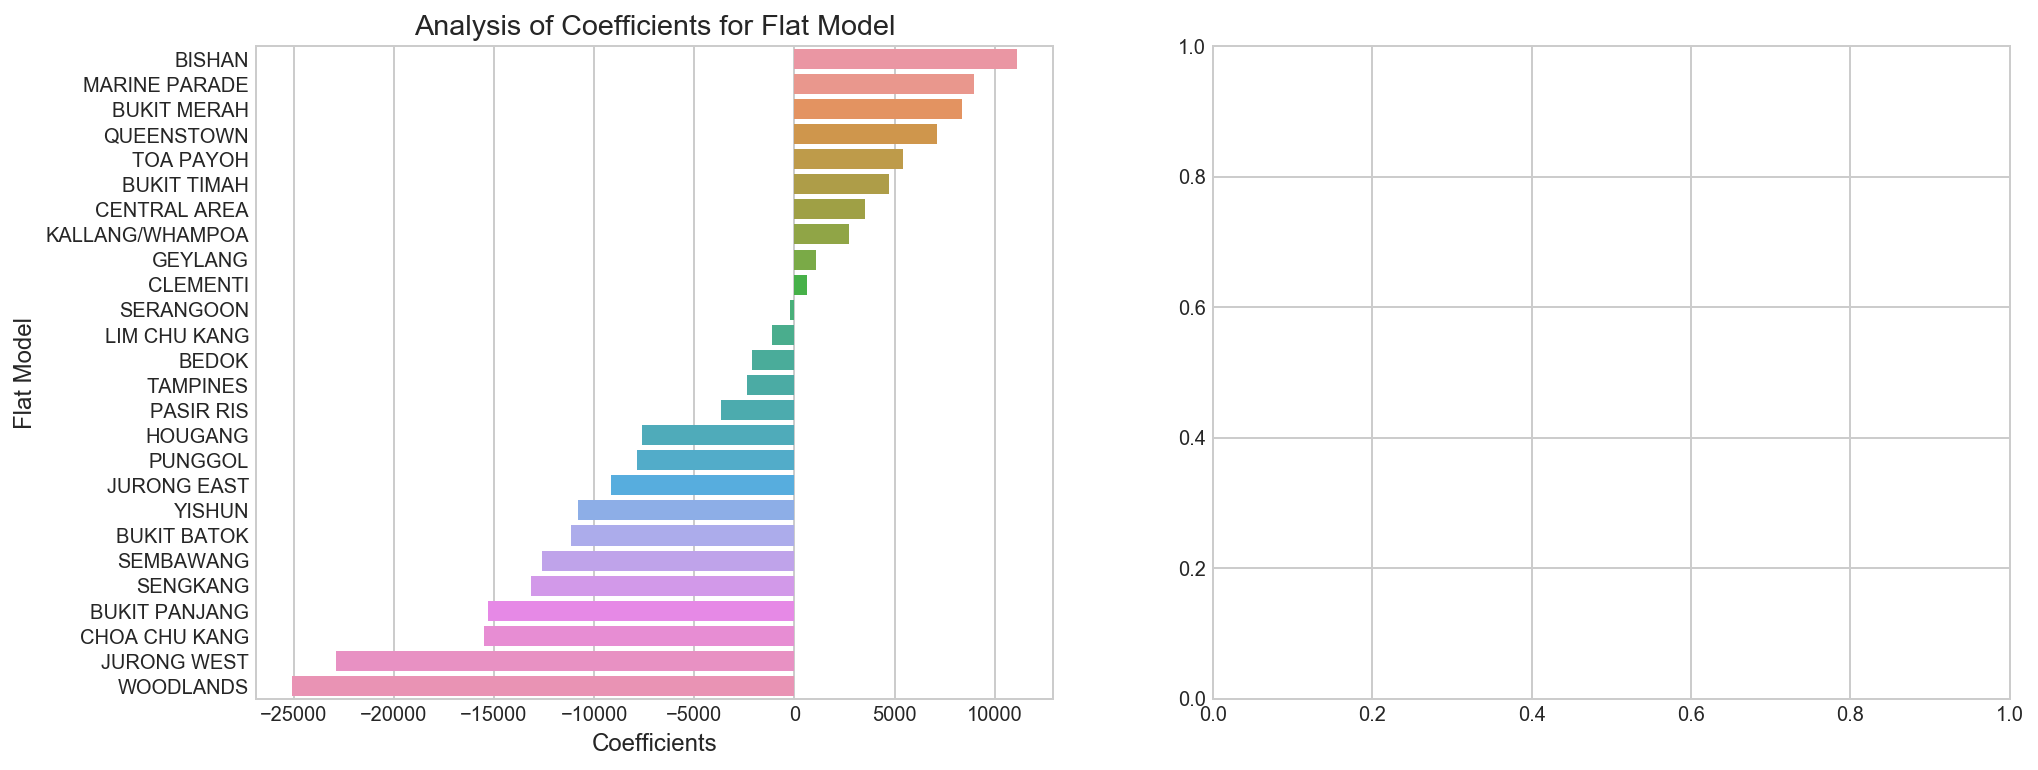

In [569]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
# summary = Add_model('iter3b_basic linreg',summary_model,summary)
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='3bregularization'></a>
#### Iteration 3b: Ridge, Lasso, enet

Mean of scores: 0.757013751551 | Std of scores: 0.00220733853868
Test score: 0.757695100537
56 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
15  72907.468113  72907.468113            flat_type_5 ROOM
55  69079.274399  69079.274399         lease_commence_date
54  64276.569200  64276.569200              floor_area_sqm
14  55981.388879  55981.388879            flat_type_4 ROOM
16  50729.594001  50729.594001         flat_type_EXECUTIVE
53  50360.119259 -50360.119259  calculated_remaining_lease
13  31271.891733  31271.891733            flat_type_3 ROOM
49  25062.245459 -25062.245459              town_WOODLANDS
37  22874.340249 -22874.340249            town_JURONG WEST
1   18802.901027 -18802.901027         flat_model_IMPROVED


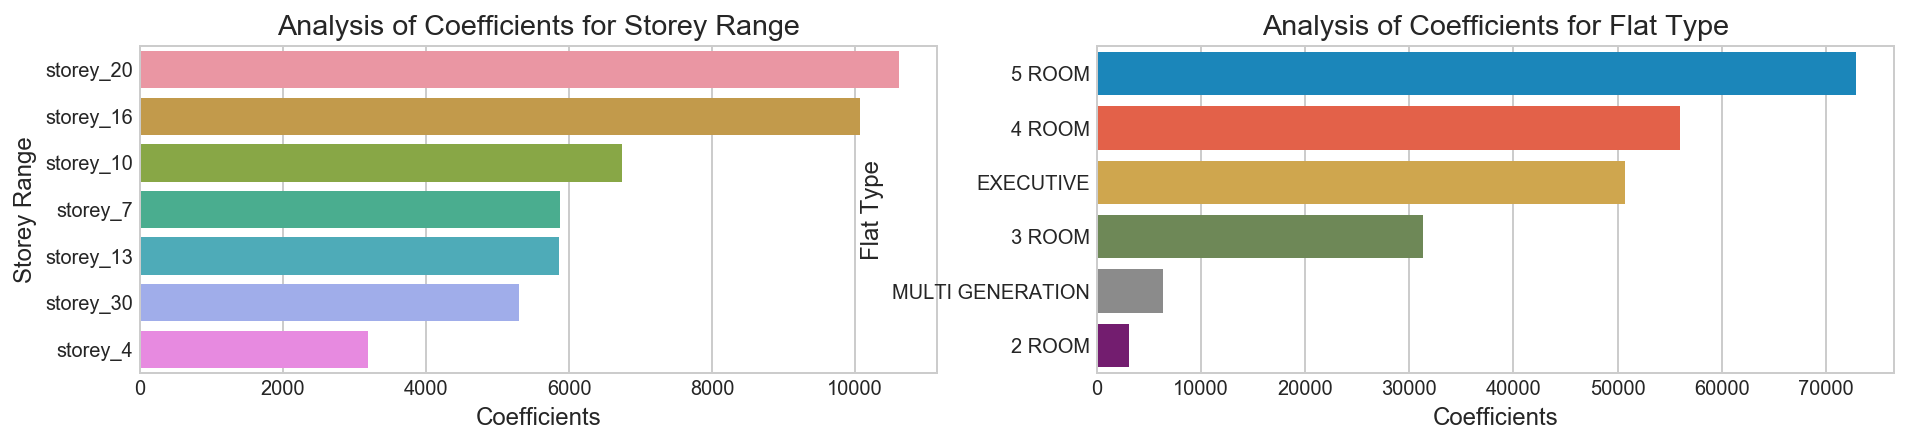

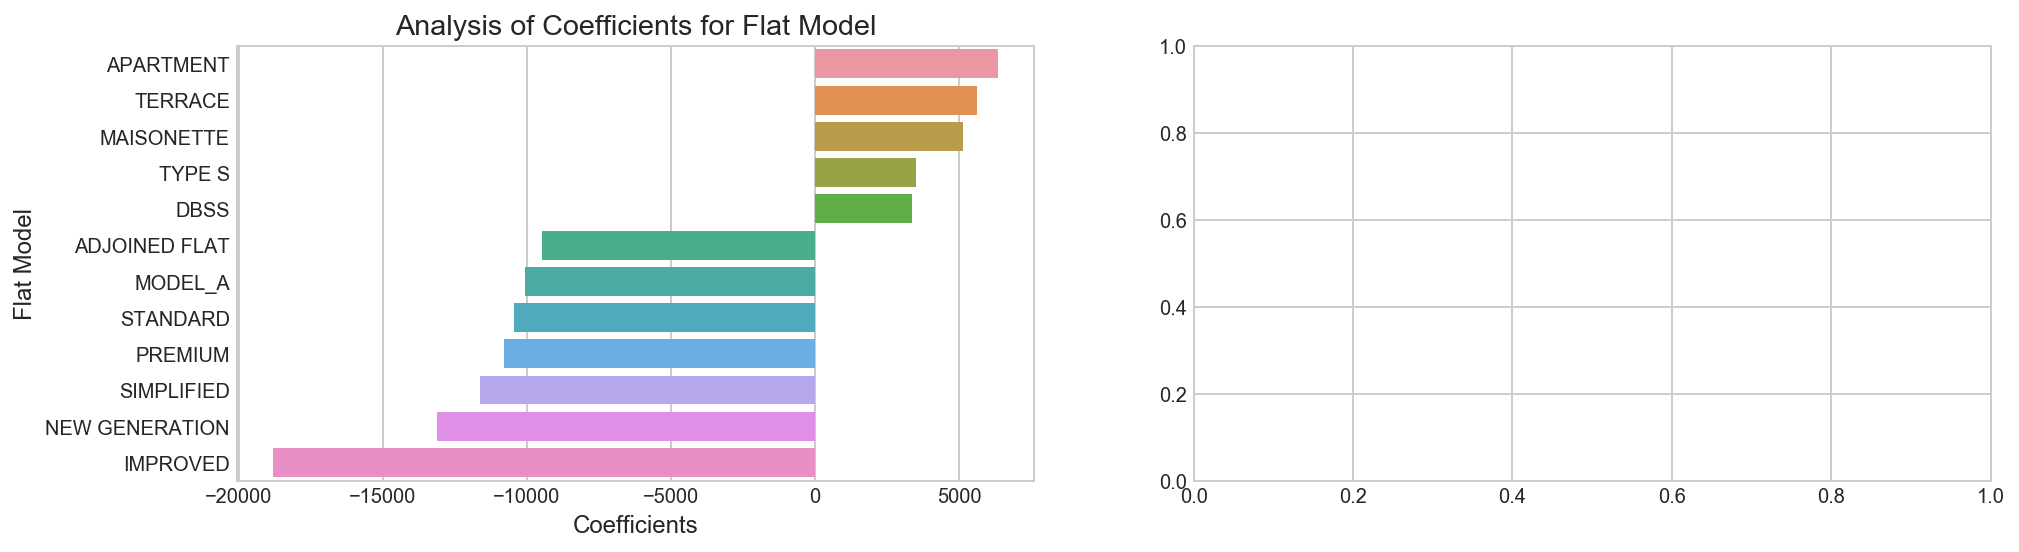

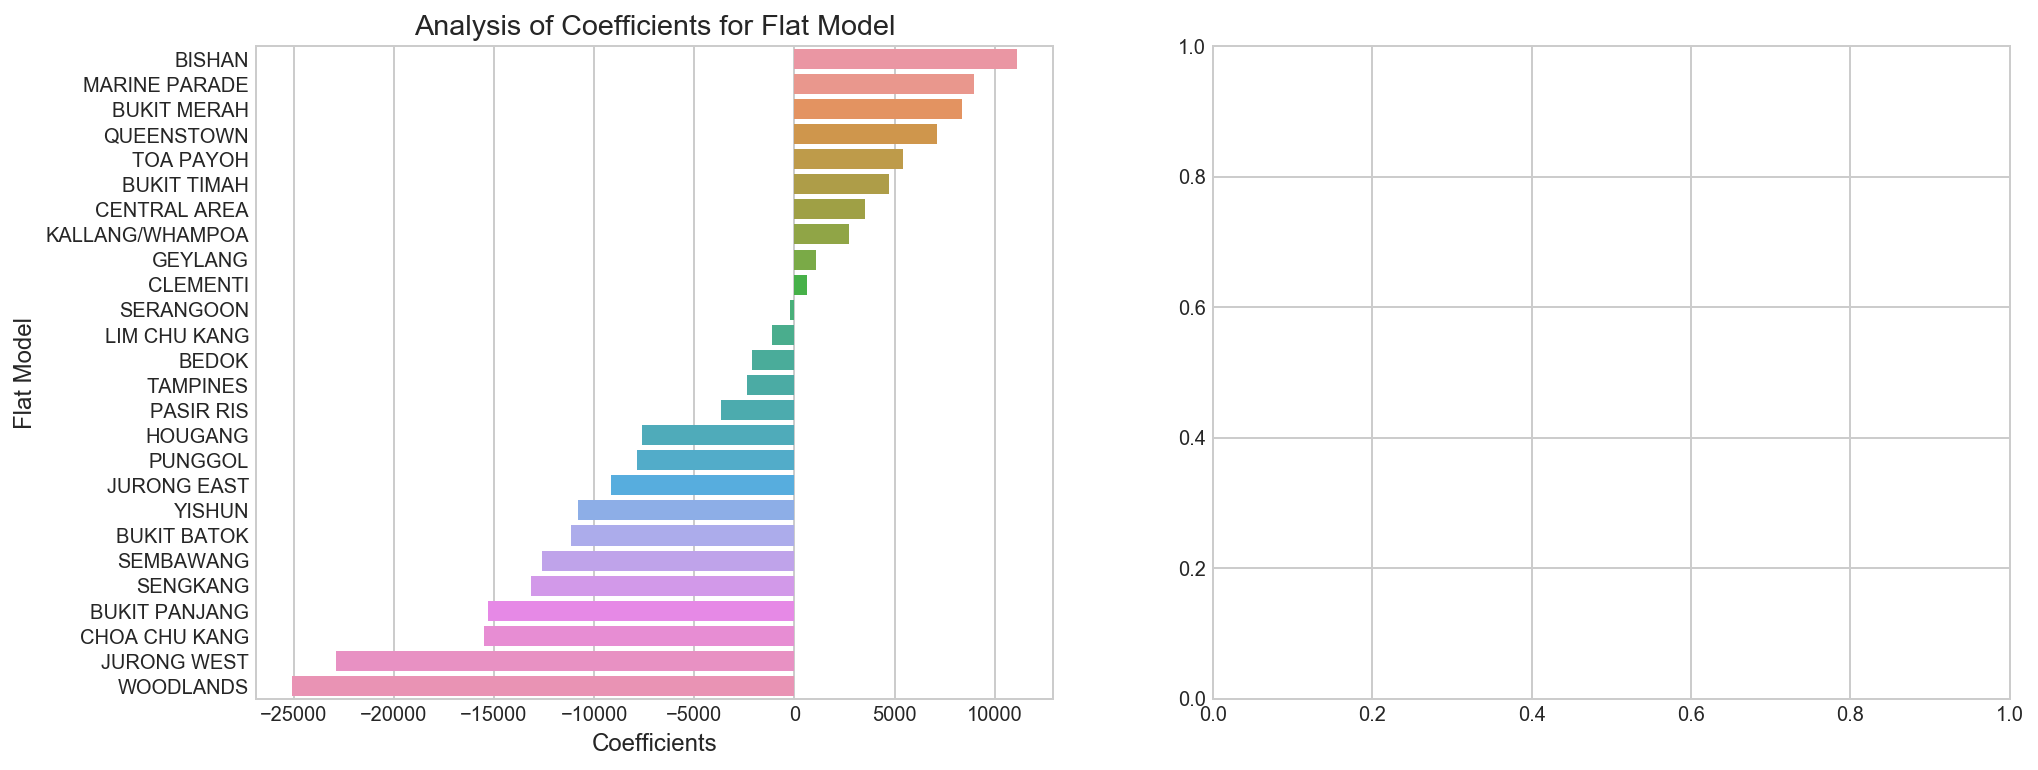

In [570]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.75653788795 | Std of scores: 0.00214152910796
Test score: 0.757252983499
52 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
54  71840.989336  71840.989336              floor_area_sqm
55  69446.502350  69446.502350         lease_commence_date
53  50078.560921 -50078.560921  calculated_remaining_lease
15  39041.125281  39041.125281            flat_type_5 ROOM
16  32015.297200  32015.297200         flat_type_EXECUTIVE
49  22124.463348 -22124.463348              town_WOODLANDS
37  20267.414719 -20267.414719            town_JURONG WEST
14  20161.159581  20161.159581            flat_type_4 ROOM
29  13586.703875 -13586.703875          town_BUKIT PANJANG
32  13361.578434 -13361.578434          town_CHOA CHU KANG


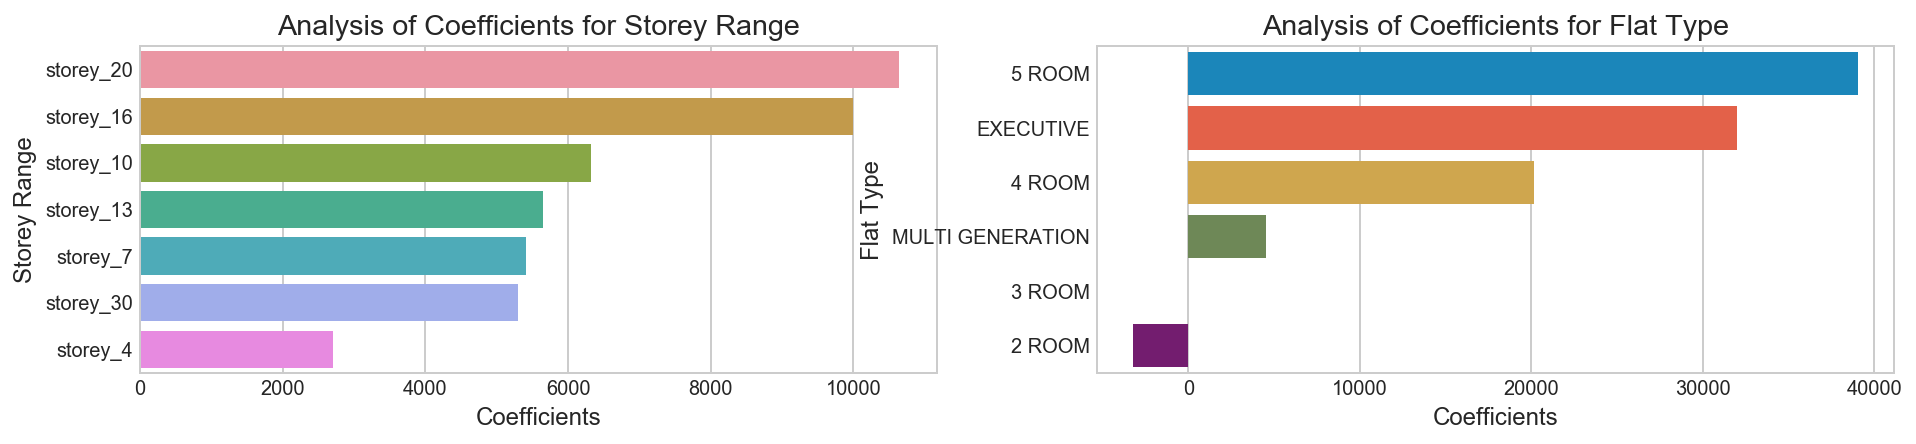

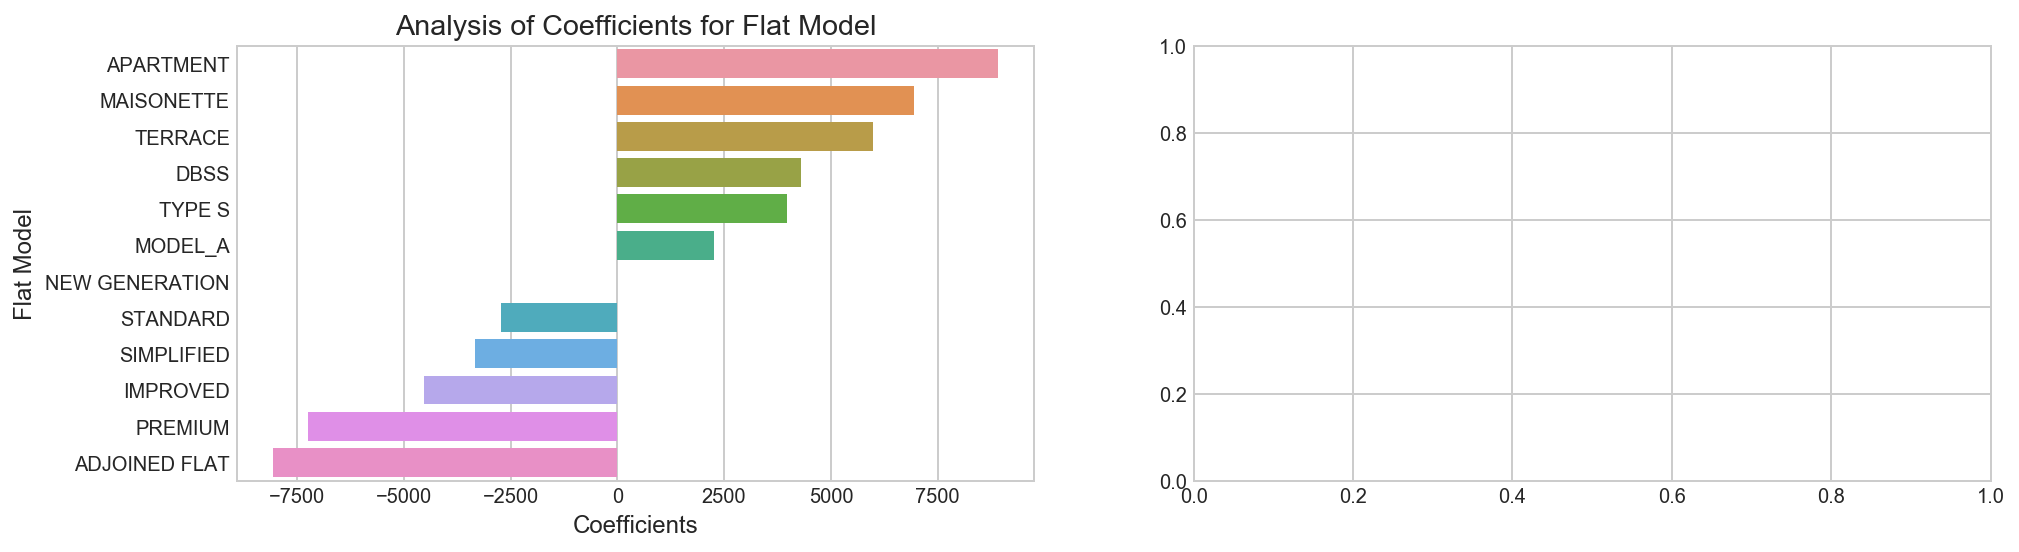

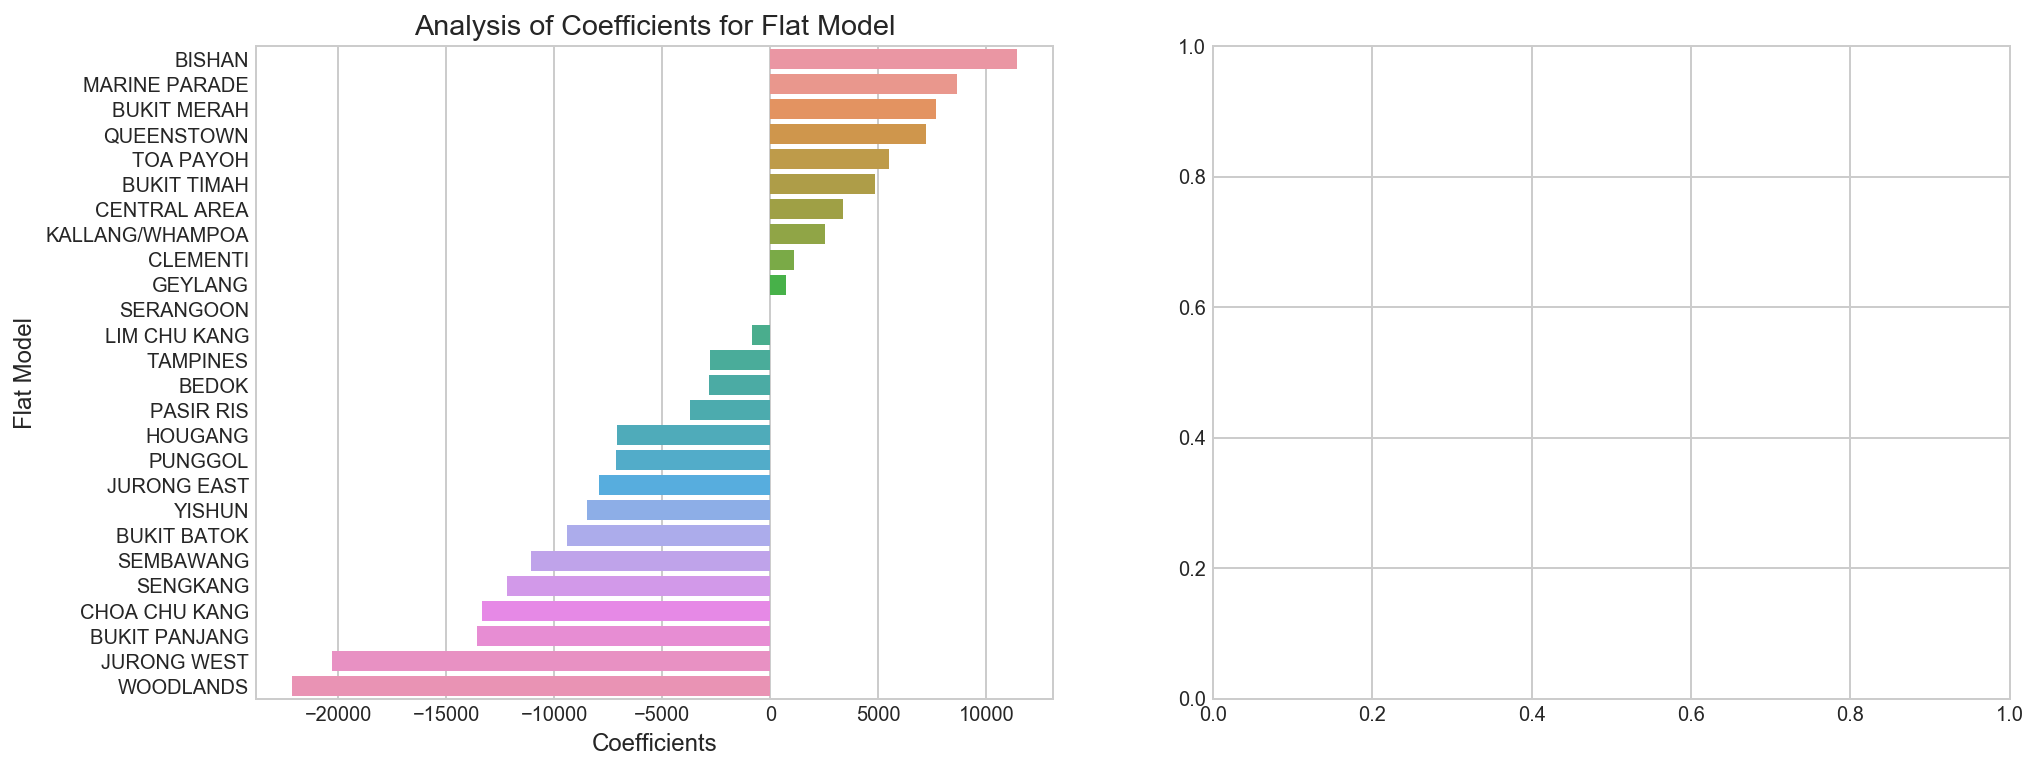

In [571]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.75653788795 | Std of scores: 0.00214152910796
Test score: 0.757252983499
52 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
54  71840.989336  71840.989336              floor_area_sqm
55  69446.502350  69446.502350         lease_commence_date
53  50078.560921 -50078.560921  calculated_remaining_lease
15  39041.125281  39041.125281            flat_type_5 ROOM
16  32015.297200  32015.297200         flat_type_EXECUTIVE
49  22124.463348 -22124.463348              town_WOODLANDS
37  20267.414719 -20267.414719            town_JURONG WEST
14  20161.159581  20161.159581            flat_type_4 ROOM
29  13586.703875 -13586.703875          town_BUKIT PANJANG
32  13361.578434 -13361.578434          town_CHOA CHU KANG


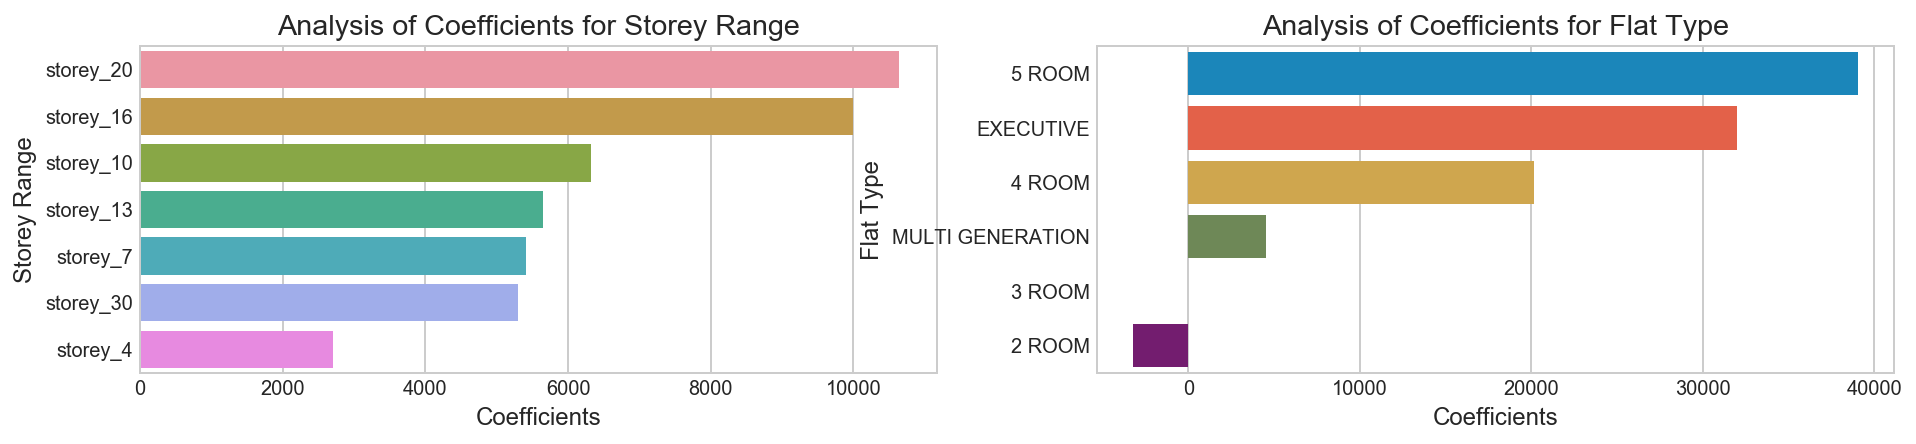

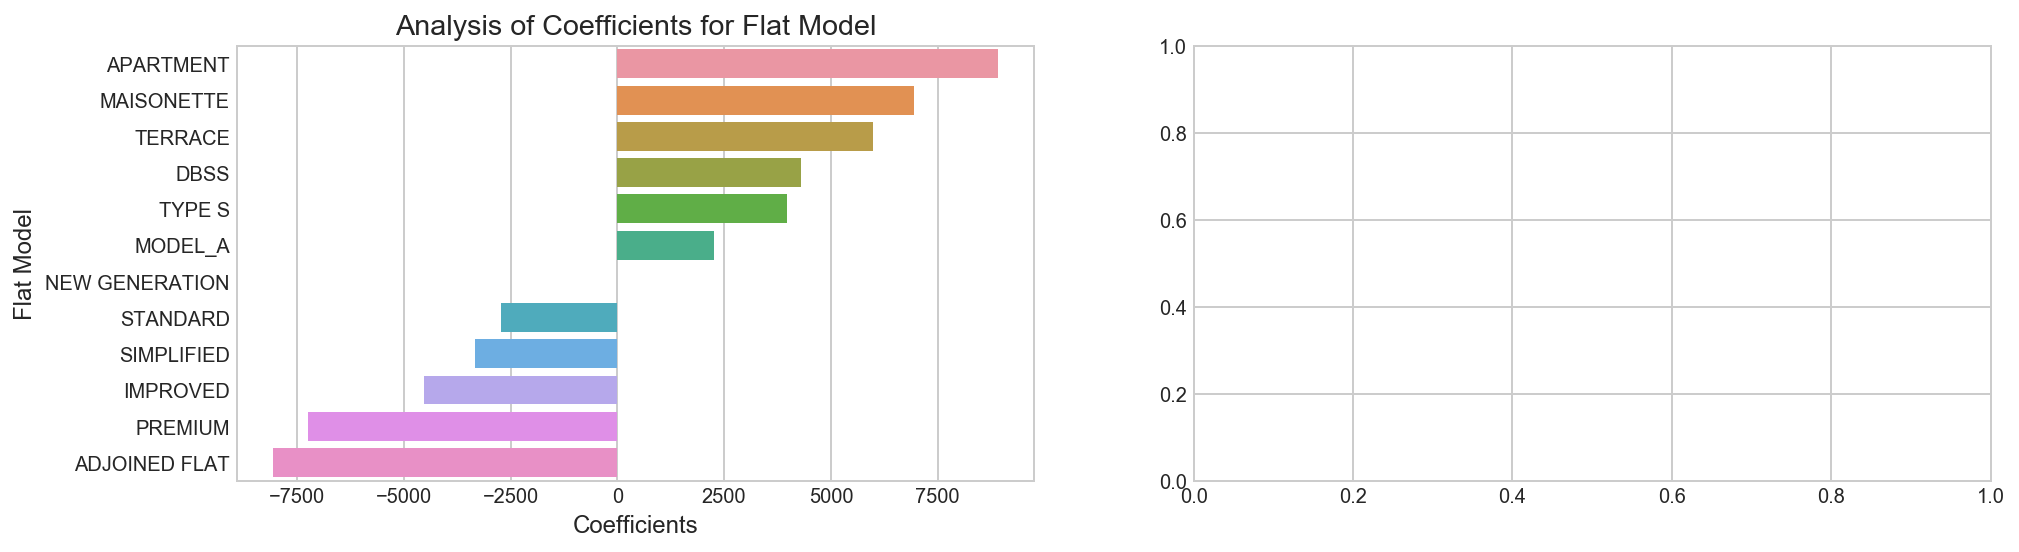

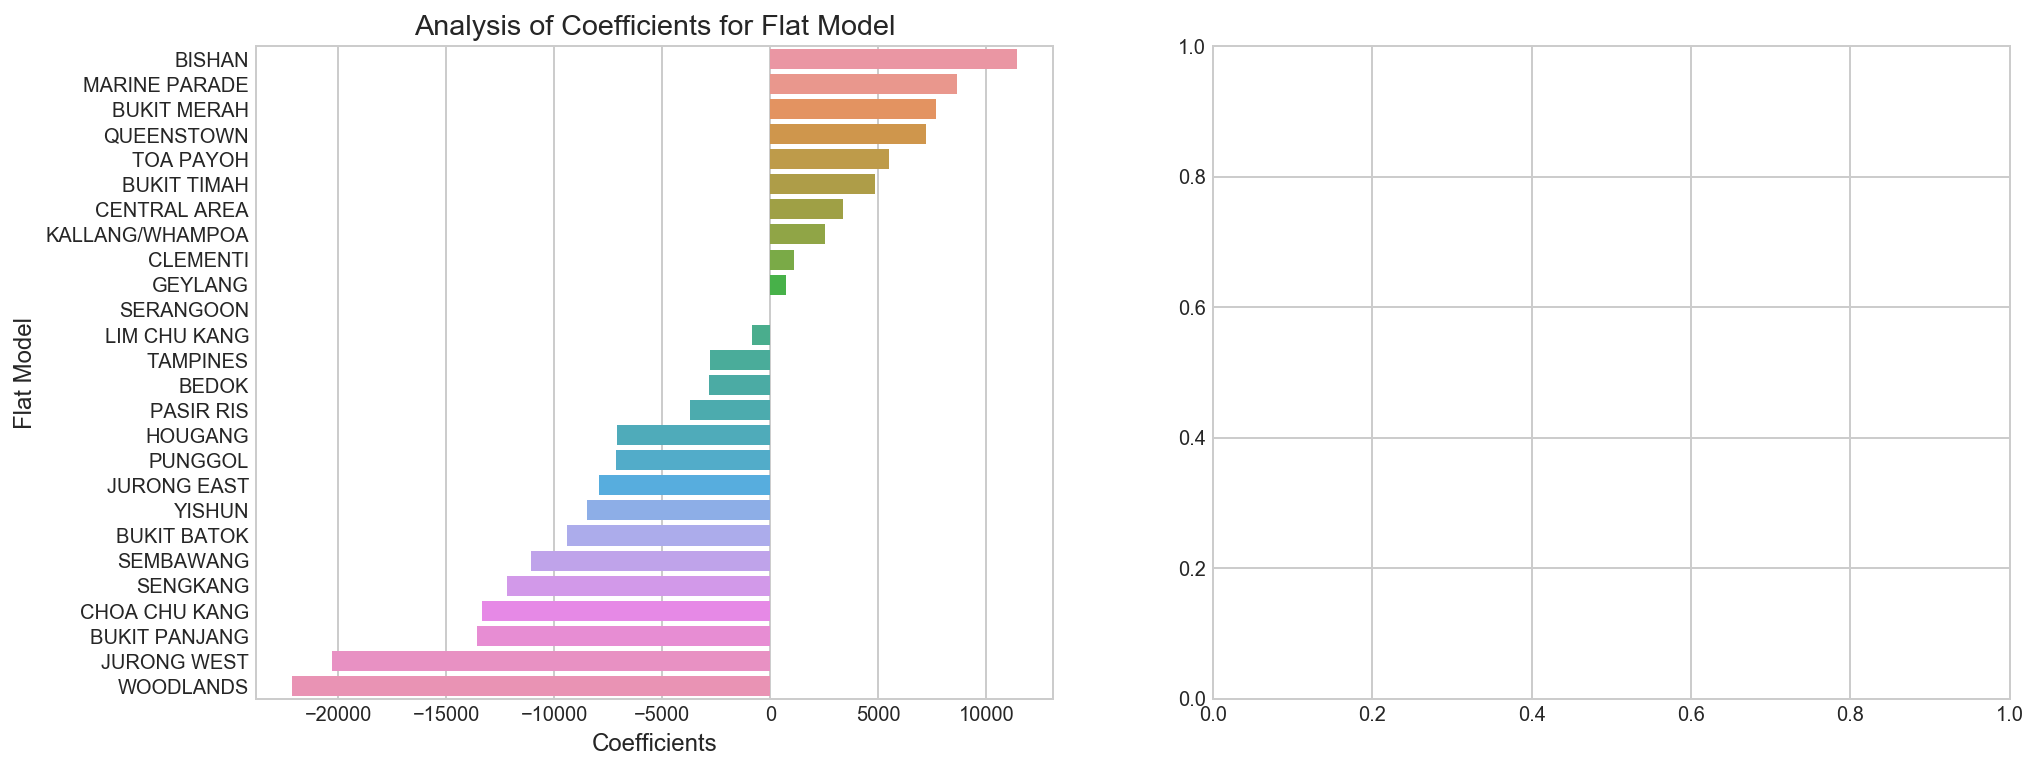

In [572]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a  id='1ainsights'></a>
#### Round1a Insights 

In [574]:
summary.sort_values('train_mean_score',ascending = False)

model train_mean_score train_std_score test_score
0    iter1_basic ridge         0.912607      0.00103117   0.912678
0   iter1_basic linreg         0.912605      0.00103202   0.912679
0    iter1_basic lasso         0.912251      0.00103463   0.912325
0     iter1_basic enet         0.912251      0.00103463   0.912325
0    iter2_basic ridge         0.881519      0.00141536   0.881433
0   iter2_basic linreg         0.881517       0.0014095   0.881433
0    iter2_basic lasso         0.880749      0.00141474   0.880648
0     iter2_basic enet         0.880749      0.00141474   0.880648
0   iter3a_basic ridge         0.758122      0.00204411   0.758709
0  iter3a_basic linreg         0.758122      0.00204435   0.758709
0   iter3a_basic lasso         0.757609       0.0019971   0.758224
0    iter3a_basic enet         0.757609       0.0019971   0.758224
0   iter3b_basic ridge         0.757014      0.00220734   0.757695
0  iter3b_basic linreg         0.757014      0.00220762   0.757695
0   iter3b_basic lasso         0.756538      0.00214153   0.757253
0    iter3b_basic enet         0.756538      0.00214153   0.757253

Iter1 : (all X variables)                                 + (y = resale price) <br>
Iter2 : (all X variables)                                 + (y = adj price)<br>
Iter3a: (all X variables except year variables)           + (y = adj price)<br>
Iter3b: (all X variables except year and month variables) + (y = adj price)<br>

From the `summary` above, we have the following insights: 
- using all X variables including year and month gives a very good score
- However does not help my final model, which is to take in features and predict the price at that point in time
- Once price was adjusted for inflation, the scores fall by quite a bit 
- Once time variables were removed, the score fell even further, although it is still good at 0.75. 
- this means that even though inlfation has been taken into consideration, certain events that happen at certain years impact the price of the houses, and I should take into consideration that. 
> - Isolate the events 
> - building a model which separates the mean and the variance. So my factors predict the 'variance' while time series analysis can predict the mean 


<a id='iter4'></a>
## Iteration 4
Changing train test set such that test set consist of data from recent years  <br>

In [609]:
df = pd.concat([df1,df2,df3,df4,df5,resale[['resale_price','adj_price','year']]],axis=1)
train = df[df['year']<2014]
test = df[df['year']>=2014]
print train.shape
print test.shape
print float(test.shape[0])/train.shape[0]

(693902, 98)
(81347, 98)
0.117231251675


<a id='4slr'></a>
#### Iteration 4: SLR

In [614]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for col in df.drop(['resale_price','adj_price','year'],axis=1).columns:
    X_train = train[[col]]
    y_train = train['resale_price']
    X_test = test[[col]]
    y_test = test['resale_price']
    
    ss = StandardScaler()

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '--------------------------------------'

flat_model_PREMIUM
Mean of scores: -0.33054639453 | Std of scores: 0.253458100455
Test score: -1.47794048085
--------------------------------------
flat_model_IMPROVED
Mean of scores: -0.369716216242 | Std of scores: 0.284961734497
Test score: -1.58603504655
--------------------------------------
flat_model_MODEL_A
Mean of scores: -0.373463751575 | Std of scores: 0.286749121054
Test score: -1.58247389782
--------------------------------------
flat_model_ADJOINED FLAT
Mean of scores: -0.369083150292 | Std of scores: 0.286433583579
Test score: -1.58362548554
--------------------------------------
flat_model_APARTMENT
Mean of scores: -0.206389119681 | Std of scores: 0.205061206307
Test score: -1.40148493641
--------------------------------------
flat_model_DBSS
Mean of scores: -0.368838310015 | Std of scores: 0.286128118931
Test score: -1.58375222048
--------------------------------------
flat_model_MAISONETTE
Mean of scores: -0.283035006887 | Std of scores: 0.339066719693
Test score: -1.

Mean of scores: -0.368696576823 | Std of scores: 0.286145327375
Test score: -1.5842409648
--------------------------------------
month_str_07
Mean of scores: -0.368764029495 | Std of scores: 0.286040840591
Test score: -1.58471968103
--------------------------------------
month_str_08
Mean of scores: -0.368741266248 | Std of scores: 0.286050324044
Test score: -1.58416017138
--------------------------------------
month_str_09
Mean of scores: -0.368679201962 | Std of scores: 0.286024008106
Test score: -1.58431093691
--------------------------------------
month_str_10
Mean of scores: -0.368563314682 | Std of scores: 0.285973787872
Test score: -1.58488201956
--------------------------------------
month_str_11
Mean of scores: -0.368825492258 | Std of scores: 0.286128482076
Test score: -1.58353739381
--------------------------------------
month_str_12
Mean of scores: -0.368757324597 | Std of scores: 0.286069320769
Test score: -1.58308610056
--------------------------------------
town_BEDOK
Me

In [618]:
summary_SLR.sort_values('test_score',ascending = False).head(10)

model train_mean_score train_std_score test_score
0        lease_commence_date      -0.00272098       0.0719033  -0.880644
0             floor_area_sqm         0.304749          0.2412   -1.05553
0           flat_type_3 ROOM         0.050693        0.155044   -1.13825
0           flat_type_5 ROOM         -0.15207        0.277488   -1.38666
0       flat_model_APARTMENT        -0.206389        0.205061   -1.40148
0  flat_model_NEW GENERATION        -0.233246        0.204503   -1.40609
0        flat_type_EXECUTIVE         -0.13039        0.305507   -1.42848
0         flat_model_PREMIUM        -0.330546        0.253458   -1.47794
0                  storey_30        -0.368667        0.286541   -1.49284
0                  storey_20        -0.351524        0.274226   -1.50388

In [619]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for col in df.drop(['resale_price','adj_price','year'],axis=1).columns:
    X_train = train[[col]]
    y_train = train['adj_price']
    X_test = test[[col]]
    y_test = test['adj_price']
    
    ss = StandardScaler()

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '--------------------------------------'

flat_model_PREMIUM
Mean of scores: -0.365577491652 | Std of scores: 0.293603181475
Test score: -0.318722404093
--------------------------------------
flat_model_IMPROVED
Mean of scores: -0.384366286923 | Std of scores: 0.295330305209
Test score: -0.353509457109
--------------------------------------
flat_model_MODEL_A
Mean of scores: -0.392209629993 | Std of scores: 0.303531956004
Test score: -0.354827208594
--------------------------------------
flat_model_ADJOINED FLAT
Mean of scores: -0.385554716429 | Std of scores: 0.299470606126
Test score: -0.351842730355
--------------------------------------
flat_model_APARTMENT
Mean of scores: -0.282290079783 | Std of scores: 0.372190817846
Test score: -0.310683803481
--------------------------------------
flat_model_DBSS
Mean of scores: -0.385285319134 | Std of scores: 0.299184279012
Test score: -0.352007749708
--------------------------------------
flat_model_MAISONETTE
Mean of scores: -0.278261401644 | Std of scores: 0.362537080273
Test sco

Mean of scores: -0.385236372099 | Std of scores: 0.299214191909
Test score: -0.35098438749
--------------------------------------
month_str_06
Mean of scores: -0.385189899448 | Std of scores: 0.299212105131
Test score: -0.352344710923
--------------------------------------
month_str_07
Mean of scores: -0.385226695328 | Std of scores: 0.299118204567
Test score: -0.35253809526
--------------------------------------
month_str_08
Mean of scores: -0.385150267303 | Std of scores: 0.299079149322
Test score: -0.352353870753
--------------------------------------
month_str_09
Mean of scores: -0.385039331266 | Std of scores: 0.299013677837
Test score: -0.352514532663
--------------------------------------
month_str_10
Mean of scores: -0.384786515776 | Std of scores: 0.298890959307
Test score: -0.353459717218
--------------------------------------
month_str_11
Mean of scores: -0.385300716618 | Std of scores: 0.299205224202
Test score: -0.352012571691
--------------------------------------
month_s

In [620]:
summary_SLR.sort_values('test_score',ascending = False).head(10)

model train_mean_score train_std_score  test_score
0             floor_area_sqm         0.462849        0.180636    0.116566
0           flat_type_3 ROOM         0.137585        0.158864  0.00094524
0        lease_commence_date       -0.0462317        0.136634  -0.0439535
0           flat_type_5 ROOM        -0.125928        0.324339    -0.21262
0  flat_model_NEW GENERATION        -0.214788        0.202026   -0.216207
0        flat_type_EXECUTIVE        -0.104383        0.314674    -0.22222
0      flat_model_MAISONETTE        -0.278261        0.362537   -0.280023
0                  storey_20        -0.359689        0.289724   -0.281851
0                  storey_30        -0.385212         0.29957   -0.286315
0                  storey_16        -0.362296        0.292064   -0.304613

As expected the scores become extremely bad even for the adjusted price: 


<a id='4mlrcat'></a>
#### Iteration 4: Multiple Variable Linear Regression by Category

In [624]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
y = resale['resale_price']

for cat in ['flat_type','storey','year_str','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in train.columns if cat in col]
    X_train = train[cat_pred]
    y_train = train['resale_price']
    X_test = test[cat_pred]
    y_test = test['resale_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: -7.31598311332e+15 | Std of scores: 2.194794934e+16
Test score: -0.946833573362
--------------------------------
storey
Mean of scores: -0.326057595819 | Std of scores: 0.261082727793
Test score: -1.30787604425
--------------------------------
year_str
Mean of scores: 0.194334241457 | Std of scores: 0.232829007559
Test score: -7.14994713343
--------------------------------
month_str
Mean of scores: -0.366503582831 | Std of scores: 0.284914966588
Test score: -1.58303838368
--------------------------------
town
Mean of scores: -0.42392492303 | Std of scores: 0.669196500722
Test score: -1.43314762816
--------------------------------
flat_model
Mean of scores: 0.0063517619215 | Std of scores: 0.215541939215
Test score: -1.10534270675
--------------------------------


In [625]:
summary_MLR.sort_values('test_score',ascending = False).head(10)

model no_of_feat test_score train_mean_score train_std_score
0   flat_type        NaN  -0.946834     -7.31598e+15     2.19479e+16
0  flat_model        NaN   -1.10534       0.00635176        0.215542
0      storey        NaN   -1.30788        -0.326058        0.261083
0        town        NaN   -1.43315        -0.423925        0.669197
0   month_str        NaN   -1.58304        -0.366504        0.284915
0    year_str        NaN   -7.14995         0.194334        0.232829

In [626]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
y = resale['resale_price']

for cat in ['flat_type','storey','year_str','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in train.columns if cat in col]
    X_train = train[cat_pred]
    y_train = train['adj_price']
    X_test = test[cat_pred]
    y_test = test['adj_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: -2.16195996437e+16 | Std of scores: 6.48587989312e+16
Test score: 0.161792896086
--------------------------------
storey
Mean of scores: -0.324019406951 | Std of scores: 0.284735180521
Test score: -0.134018910962
--------------------------------
year_str
Mean of scores: -0.0738565061884 | Std of scores: 0.291709869205
Test score: -5.26587401416
--------------------------------
month_str
Mean of scores: -0.382372842781 | Std of scores: 0.297609652698
Test score: -0.355325961226
--------------------------------
town
Mean of scores: -0.520516034291 | Std of scores: 0.930244229514
Test score: -0.341997260374
--------------------------------
flat_model
Mean of scores: 0.048393598749 | Std of scores: 0.221609167818
Test score: 0.0109463502774
--------------------------------


In [627]:
summary_MLR.sort_values('test_score',ascending = False).head(10)

model no_of_feat test_score train_mean_score train_std_score
0   flat_type        NaN   0.161793     -2.16196e+16     6.48588e+16
0  flat_model        NaN  0.0109464        0.0483936        0.221609
0      storey        NaN  -0.134019        -0.324019        0.284735
0        town        NaN  -0.341997        -0.520516        0.930244
0   month_str        NaN  -0.355326        -0.382373         0.29761
0    year_str        NaN   -5.26587       -0.0738565         0.29171

<a id='4mlrall'></a>
#### Iteration 4: Multiple Variable Linear Regression - ALL

In [632]:
X = train
X_train = train.drop(['resale_price','adj_price','year'],axis=1).values
y_train = train['resale_price']
X_test = test.drop(['resale_price','adj_price','year'],axis=1).values
y_test = test['resale_price']
ss = StandardScaler()

In [634]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4_resale px_basic linreg',summary_model,[])

coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

MemoryError: 

In [ ]:
X_train = train.drop(['resale_price','adj_price','year'],axis=1)
y_train = train['adj_price']
X_test = test.drop(['resale_price','adj_price','year'],axis=1)
y_test = test['adj_price']
ss = StandardScaler()